In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import random
import time
import matplotlib.pyplot as plt
import seaborn as sns
import gzip
import pickle

# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)

# Sklearn and Imbalanced-learn Libraries
from sklearn.model_selection import StratifiedKFold, train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFECV, VarianceThreshold, mutual_info_classif
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, balanced_accuracy_score,
    classification_report
)
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.utils import resample
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE




from sklearn.base import BaseEstimator, TransformerMixin

# Additional Libraries
from sklearn.base import clone
from sklearn.exceptions import NotFittedError
import warnings
warnings.filterwarnings('ignore')

# Machine Learning Libraries with GPU Support
import xgboost as xgb
import lightgbm as lgb

# For SHAP values
import shap

# Statistical Tests
from scipy.stats import friedmanchisquare
import scikit_posthocs as sp

# For progress monitoring
from tqdm import tqdm
from kneed import KneeLocator


import warnings

# Suppress warnings to reduce clutter
warnings.filterwarnings('ignore')

from sklearn.exceptions import ConvergenceWarning

# Suppress ConvergenceWarning
warnings.filterwarnings('ignore', category=ConvergenceWarning)

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

from joblib import Parallel, delayed
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import mannwhitneyu
import numpy as np
import pandas as pd

# Necessary imports
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import cross_val_score
from sklearn.utils.validation import check_X_y, check_array
import pandas as pd
import numpy as np

from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')



In [2]:
# File paths for clinical, extracted features and radiomics features
clinical_data_path = '/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/Clinical_and_Other_Features_final_comb.xlsx'
features_path = '/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/features_extracted_VGG16_tumor_mid10_5_augmented_bal_1.pkl.gz'
imaging_features_path = '/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/Imaging_Features.xlsx'

In [3]:
#Function: Load and Process Clinical and Extracted Features Data
def load_clinical_data(clinical_data_path):
    """
    Loads and preprocesses clinical data from an Excel file.

    Parameters:
    - clinical_data_path (str): Path to the clinical data Excel file.

    Returns:
    - pd.DataFrame: Preprocessed clinical data.
    """
    print("Loading clinical data...")
    clinical_data = pd.read_excel(clinical_data_path)

    # Rename columns for consistency
    clinical_data.columns = [col.replace(' ', '_') for col in clinical_data.columns]
    clinical_data = clinical_data.rename(
        columns={
            'Patient_ID': 'patient_id',
            'Pathologic_Response_to_Neoadjuvant_Therapy': 'response'
        }
    )

    # Convert 'Breast_MRI_001' to '001' in the patient_id column
    clinical_data['patient_id'] = clinical_data['patient_id'].apply(
        lambda x: x.split('_')[-1] if isinstance(x, str) else x
    )

    # Convert response to binary: 1 means pCR, else non-pCR
    clinical_data['response'] = clinical_data['response'].apply(
        lambda x: 1 if x == 1 else 0
    )

    # Preprocess clinical data
    clinical_data['patient_id'] = clinical_data['patient_id'].astype(str)

    # Separate numerical and categorical columns
    patient_id_cols = ["patient_id"]
    response_cols = ["response"]
    numerical_cols = ["Date_of_Birth"]  # Consider converting to 'Age at Diagnosis'
    categorical_cols = clinical_data.columns[
        (clinical_data.columns != "Date_of_Birth") &
        (clinical_data.columns != "patient_id") &
        (clinical_data.columns != "response")
    ]

    numerical_df = clinical_data[numerical_cols]
    patient_id_df = clinical_data[patient_id_cols]
    response_df = clinical_data[response_cols]

    # One-hot encode categorical columns
    clinical_data[categorical_cols] = clinical_data[categorical_cols].astype('category')
    categorical_df = pd.get_dummies(clinical_data[categorical_cols], drop_first=True)
    categorical_df = categorical_df.astype(int)

    # Concatenate all dataframes
    encoded_df = pd.concat(
        [patient_id_df, numerical_df, categorical_df, response_df],
        axis=1
    )

    print("Clinical data loaded and processed.")
    return encoded_df

def load_image_features(features_path):
    """
    Loads and processes image features from a compressed pickle file.

    Parameters:
    - features_path (str): Path to the compressed pickle file containing image features.

    Returns:
    - pd.DataFrame: Processed image features.
    """
    print("Loading image features...")
    with gzip.open(features_path, 'rb') as f:
        features_dict = pickle.load(f)

    # Extract patient IDs and features
    features_data = {
        'patient_id': [key.split('-')[0] for key in features_dict.keys()],
        **{
            f'feature_{i}': [features_dict[key][i] for key in features_dict.keys()]
            for i in range(len(next(iter(features_dict.values()))))
        }
    }

    # Create a DataFrame
    features_df = pd.DataFrame(features_data)
    features_df['patient_id'] = features_df['patient_id'].astype(str)
    print("Image features loaded.")
    return features_df



def load_and_preprocess_data(clinical_data_path, features_path):
    clinical_data_processed = load_clinical_data(clinical_data_path)
    features_df = load_image_features(features_path)
    clinical_data_processed['patient_id'] = clinical_data_processed['patient_id'].astype(str)
    features_df['patient_id'] = features_df['patient_id'].astype(str)

    # Prepare three variations of the dataset
    print("Preparing dataset variations...")

    datasets = {}

    # Handle missing data in image features
    print("Imputing missing values in image features...")
    imputer = SimpleImputer(strategy='mean')
    features_df_imputed = imputer.fit_transform(features_df.drop(columns=['patient_id']))

    # Feature scaling
    print("Scaling image features...")
    scaler = MinMaxScaler()
    features_df_scaled = scaler.fit_transform(features_df_imputed)

    # Create a DataFrame for scaled features
    features_scaled_df = pd.DataFrame(features_df_scaled, columns=[f'feature_{i}' for i in range(features_df_scaled.shape[1])])
    features_scaled_df['patient_id'] = features_df['patient_id'].values

    # Now, merge scaled image features with clinical data
    data_scaled = features_scaled_df.merge(
        clinical_data_processed,
        on='patient_id',
        how='inner'
    ).reset_index(drop=True)

    # 1. Image Features (Scaled)
    image_feature_columns = [col for col in data_scaled.columns if 'feature_' in col]

    X_image = data_scaled[image_feature_columns]
    y_image = data_scaled['response'].astype(int)
    groups_image = data_scaled['patient_id']

    # 2. Clinical Features
    # Subset clinical data to include only patients present in data_scaled
    patient_ids_in_data_scaled = clinical_data_processed['patient_id'].isin(data_scaled['patient_id'])
    clinical_data_in_data_scaled = clinical_data_processed[patient_ids_in_data_scaled].reset_index(drop=True)

    X_clinical = clinical_data_in_data_scaled.drop(columns=['patient_id', 'response'])
    y_clinical = clinical_data_in_data_scaled['response'].astype(int)
    groups_clinical = clinical_data_in_data_scaled['patient_id']

    # 3. Combined Features (Scaled image features + clinical data)
    # Exclude 'patient_id' and 'response' from features
    exclude_columns = ['patient_id', 'response']
    X_combined = data_scaled.drop(columns=exclude_columns)
    y_combined = data_scaled['response'].astype(int)
    groups_combined = data_scaled['patient_id']

    # Preprocess each dataset variation
    def preprocess_data(X):
        # Remove features with zero variance
        variance_threshold = VarianceThreshold(threshold=0)
        X_var = variance_threshold.fit_transform(X)
        feature_names = X.columns[variance_threshold.get_support(indices=True)]
        X = pd.DataFrame(X_var, columns=feature_names)
        return X

    X_combined = preprocess_data(X_combined)
    X_clinical = preprocess_data(X_clinical)
    X_image = preprocess_data(X_image)

    datasets['Combined'] = (X_combined, y_combined, groups_combined)
    datasets['Clinical'] = (X_clinical, y_clinical, groups_clinical)
    datasets['Image'] = (X_image, y_image, groups_image)

    return datasets


In [4]:
# Make Clinical, Image and Combined Data in data variations
data_variations = load_and_preprocess_data(clinical_data_path, features_path)

Loading clinical data...
Clinical data loaded and processed.
Loading image features...
Image features loaded.
Preparing dataset variations...
Imputing missing values in image features...
Scaling image features...


In [5]:
#Function: Load additional imaging features from radiomics Imaging_Features.xlsx

def load_additional_imaging_features(imaging_features_path):
    print("Loading additional imaging features...")
    imaging_features_df = pd.read_excel(imaging_features_path)
    
    # Rename the 'Patient ID' column to 'patient_id'
    imaging_features_df = imaging_features_df.rename(columns={'Patient ID': 'patient_id'})
    
    # Convert 'Breast_MRI_001' to '001' in the patient_id column
    imaging_features_df['patient_id'] = imaging_features_df['patient_id'].apply(
        lambda x: x.split('_')[-1] if isinstance(x, str) else x
    )
    
    # Ensure patient_id is string type
    imaging_features_df['patient_id'] = imaging_features_df['patient_id'].astype(str)
    
    # Clean up feature names by replacing spaces and special characters
    imaging_features_df.columns = [col.replace(' ', '_')
                                     .replace('(', '')
                                     .replace(')', '')
                                     .replace(',', '_')
                                     .replace('.', '_') for col in imaging_features_df.columns]
    
    print("Additional imaging features loaded.")
    return imaging_features_df

# Load the additional imaging features
additional_imaging_features_df = load_additional_imaging_features(imaging_features_path)


Loading additional imaging features...
Additional imaging features loaded.


In [6]:
# Prepare new datasets with the radiomics imaging features

print("Preparing new datasets with additional imaging features...")

clinical_data_processed = load_clinical_data(clinical_data_path)
# Ensure patient IDs are strings
additional_imaging_features_df['patient_id'] = additional_imaging_features_df['patient_id'].astype(str)
clinical_data_processed['patient_id'] = clinical_data_processed['patient_id'].astype(str)

# Imaging Only Dataset (from Imaging_Features.xlsx)
# Merge the imaging features with the response variable from clinical data
imaging_only_df = additional_imaging_features_df.merge(
    clinical_data_processed[['patient_id', 'response']],
    on='patient_id',
    how='inner'
)

# Create X and y for Imaging Only dataset
X_imaging_only = imaging_only_df.drop(columns=['patient_id', 'response'])
y_imaging_only = imaging_only_df['response'].astype(int)
groups_imaging_only = imaging_only_df['patient_id']

# Clinical + Imaging Dataset
# Merge imaging features with clinical data
clinical_imaging_df = additional_imaging_features_df.merge(
    clinical_data_processed,
    on='patient_id',
    how='inner'
)

# Create X and y for Clinical + Imaging dataset
X_clinical_imaging = clinical_imaging_df.drop(columns=['patient_id', 'response'])
y_clinical_imaging = clinical_imaging_df['response'].astype(int)
groups_clinical_imaging = clinical_imaging_df['patient_id']

# Combined Existing Dataset + Imaging Features (Extracted Features + Clinical + Imaging)
# Get existing combined dataset
X_combined_existing, y_combined_existing, groups_combined_existing = data_variations['Combined']

# Ensure patient IDs are strings
X_combined_existing = X_combined_existing.copy()
X_combined_existing['patient_id'] = groups_combined_existing.astype(str)

# Merge with additional imaging features
combined_with_imaging_df = X_combined_existing.merge(
    additional_imaging_features_df,
    on='patient_id',
    how='inner'
)

# Ensure response variable is included
combined_with_imaging_df = combined_with_imaging_df.merge(
    clinical_data_processed[['patient_id', 'response']],
    on='patient_id',
    how='left'
)

# Create X and y for Combined with Imaging dataset
X_combined_with_imaging = combined_with_imaging_df.drop(columns=['patient_id', 'response'])
y_combined_with_imaging = combined_with_imaging_df['response'].astype(int)
groups_combined_with_imaging = combined_with_imaging_df['patient_id']

# Add new datasets to data_variations
data_variations['RadiomicsOnly'] = (X_imaging_only, y_imaging_only, groups_imaging_only)
data_variations['ClinicalRadiomics'] = (X_clinical_imaging, y_clinical_imaging, groups_clinical_imaging)
data_variations['CombinedRadiomics'] = (X_combined_with_imaging, y_combined_with_imaging, groups_combined_with_imaging)

print("New datasets added to data_variations.")


Preparing new datasets with additional imaging features...
Loading clinical data...
Clinical data loaded and processed.
New datasets added to data_variations.


In [9]:
#Data Train Test Split
def stratified_group_split(X, y, groups, test_size=0.3, random_state=None):
    # Create a DataFrame with groups and their corresponding class labels
    group_df = pd.DataFrame({'group': groups, 'label': y})
    group_df = group_df.drop_duplicates()

    # Perform stratified split on groups
    stratify = group_df['label']
    group_train, group_test = train_test_split(
        group_df['group'], test_size=test_size, random_state=random_state, stratify=stratify
    )

    # Select samples based on group splits
    train_idx = X[groups.isin(group_train)].index
    test_idx = X[groups.isin(group_test)].index

    return train_idx, test_idx

# Usage
data_splits = {}

for dataset_name, (X_full, y_full, groups) in data_variations.items():
    print(f"\nProcessing {dataset_name} Dataset")

    # Ensure groups is a pandas Series with reset index
    groups = pd.Series(groups).reset_index(drop=True)
    y_full_series = pd.Series(y_full).reset_index(drop=True)
    X_full = X_full.reset_index(drop=True)

    train_idx, test_idx = stratified_group_split(X_full, y_full_series, groups, test_size=0.3, random_state=42)

    X_train_full = X_full.loc[train_idx].reset_index(drop=True)
    y_train_full = y_full_series.loc[train_idx].reset_index(drop=True)
    X_test_full = X_full.loc[test_idx].reset_index(drop=True)
    y_test = y_full_series.loc[test_idx].reset_index(drop=True)

    # Retrieve patient IDs for train and test sets
    patient_ids_train = groups.loc[train_idx].reset_index(drop=True)
    patient_ids_test = groups.loc[test_idx].reset_index(drop=True)

    data_splits[dataset_name] = {
        'X_train_full': X_train_full,
        'X_test_full': X_test_full,
        'y_train_full': y_train_full,
        'y_test': y_test,
        'patient_ids_train': patient_ids_train,
        'patient_ids_test': patient_ids_test
    }

    # Verify class distribution
    print("Training set class distribution:")
    print(y_train_full.value_counts(normalize=True))
    print("Test set class distribution:")
    print(y_test.value_counts(normalize=True))


Processing Combined Dataset
Training set class distribution:
response
1    0.542263
0    0.457737
Name: proportion, dtype: float64
Test set class distribution:
response
1    0.54207
0    0.45793
Name: proportion, dtype: float64

Processing Clinical Dataset
Training set class distribution:
response
0    0.770492
1    0.229508
Name: proportion, dtype: float64
Test set class distribution:
response
0    0.772152
1    0.227848
Name: proportion, dtype: float64

Processing Image Dataset
Training set class distribution:
response
1    0.542263
0    0.457737
Name: proportion, dtype: float64
Test set class distribution:
response
1    0.54207
0    0.45793
Name: proportion, dtype: float64

Processing RadiomicsOnly Dataset
Training set class distribution:
response
0    0.766304
1    0.233696
Name: proportion, dtype: float64
Test set class distribution:
response
0    0.772152
1    0.227848
Name: proportion, dtype: float64

Processing ClinicalRadiomics Dataset
Training set class distribution:
respons


Starting feature selection for 'Combined' Dataset

Handling missing data with SimpleImputer...

Scaling features...

Performing L1-based feature selection...
Number of features after L1-based selection: 100

Performing Mann-Whitney U Test feature selection with Bonferroni correction and parallelization...
Number of features after Mann-Whitney U Test: 73

Performing Stability Analysis with RFECV and Secondary Sorting based on Mean Feature Importance...
Number of stable features selected: 10

Best Stable Features Selected: ['feature_3552', 'feature_480', 'feature_21780', 'feature_276', 'feature_22006', 'feature_382', 'PR_"{0_=_neg,\n1_=_pos}"_1', 'feature_11752', 'feature_21703', 'feature_21673']


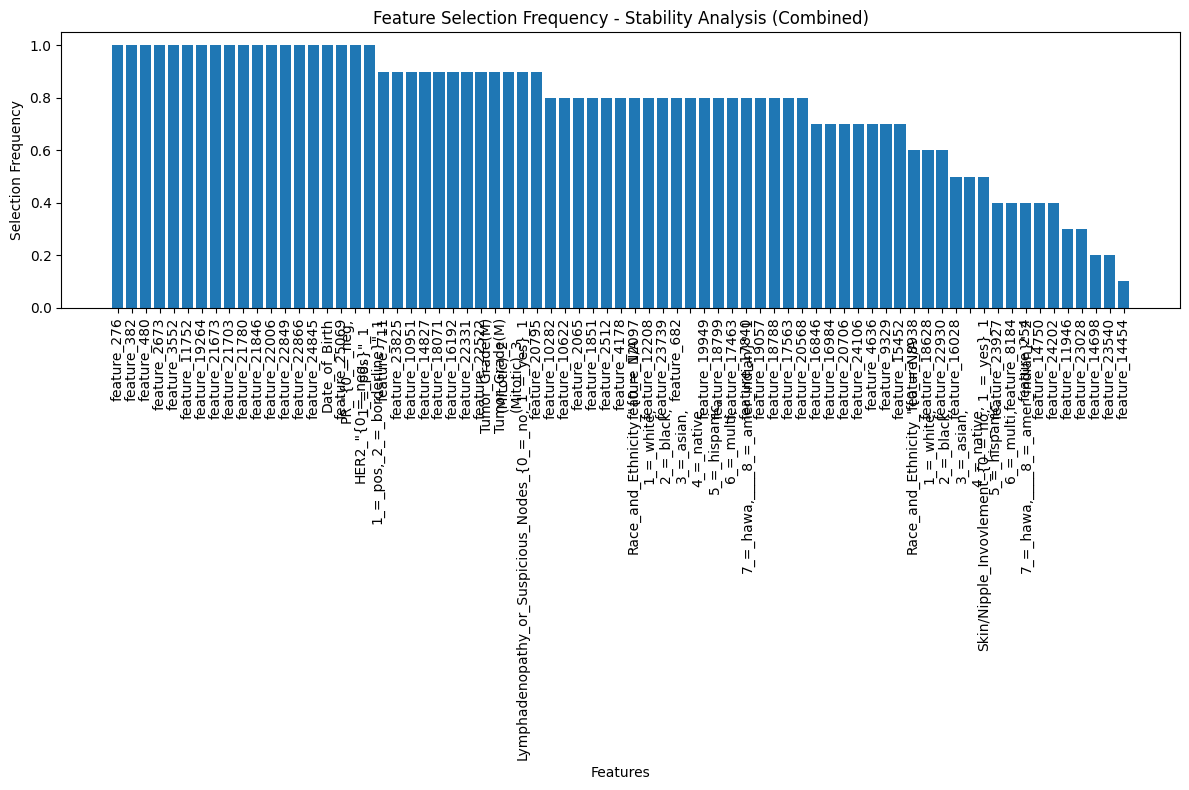


Skipping SMOTE. Using original training data.

Final datasets for 'Combined' stored with selected features.

Starting feature selection for 'Clinical' Dataset

Handling missing data with SimpleImputer...

Scaling features...

Performing L1-based feature selection...
Number of features after L1-based selection: 16

Skipping Mann-Whitney U Test for 'Clinical' dataset. Using L1-selected features.

Performing Stability Analysis with RFECV and Secondary Sorting based on Mean Feature Importance...
Number of stable features selected: 7

Best Stable Features Selected: ['Race_and_Ethnicity_"{0_=_N/A\n1_=_white,\n2_=_black,\n3_=_asian,\n4_=_native,\n5_=_hispanic,\n6_=_multi,\n7_=_hawa,____8_=_amer_indian}"_2', 'ER_"{0_=_neg,\n1_=_pos}"_1', 'PR_"{0_=_neg,\n1_=_pos}"_1', 'Tumor_Grade(M)\n(Mitotic)_2', 'Tumor_Grade(M)\n(Mitotic)_3', 'Lymphadenopathy_or_Suspicious_Nodes_{0_=_no,_1_=_yes}_1', 'Multicentric/Multifocal_{0_=_no,_1_=_yes}_1']


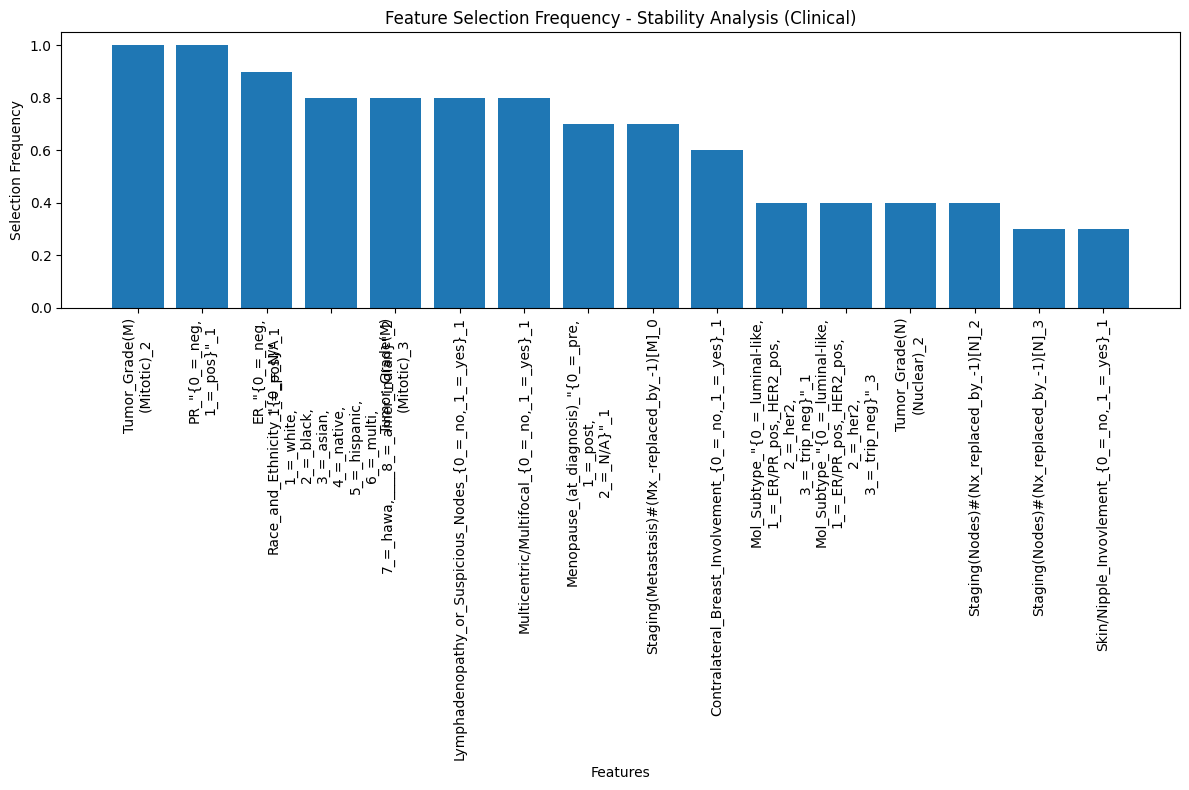


Skipping SMOTE. Using original training data.

Final datasets for 'Clinical' stored with selected features.

Starting feature selection for 'Image' Dataset

Handling missing data with SimpleImputer...

Scaling features...

Performing L1-based feature selection...
Number of features after L1-based selection: 100

Performing Mann-Whitney U Test feature selection with Bonferroni correction and parallelization...
Number of features after Mann-Whitney U Test: 71

Performing Stability Analysis with RFECV and Secondary Sorting based on Mean Feature Importance...
Number of stable features selected: 10

Best Stable Features Selected: ['feature_3552', 'feature_480', 'feature_21780', 'feature_3348', 'feature_276', 'feature_24852', 'feature_23634', 'feature_2324', 'feature_21984', 'feature_382']


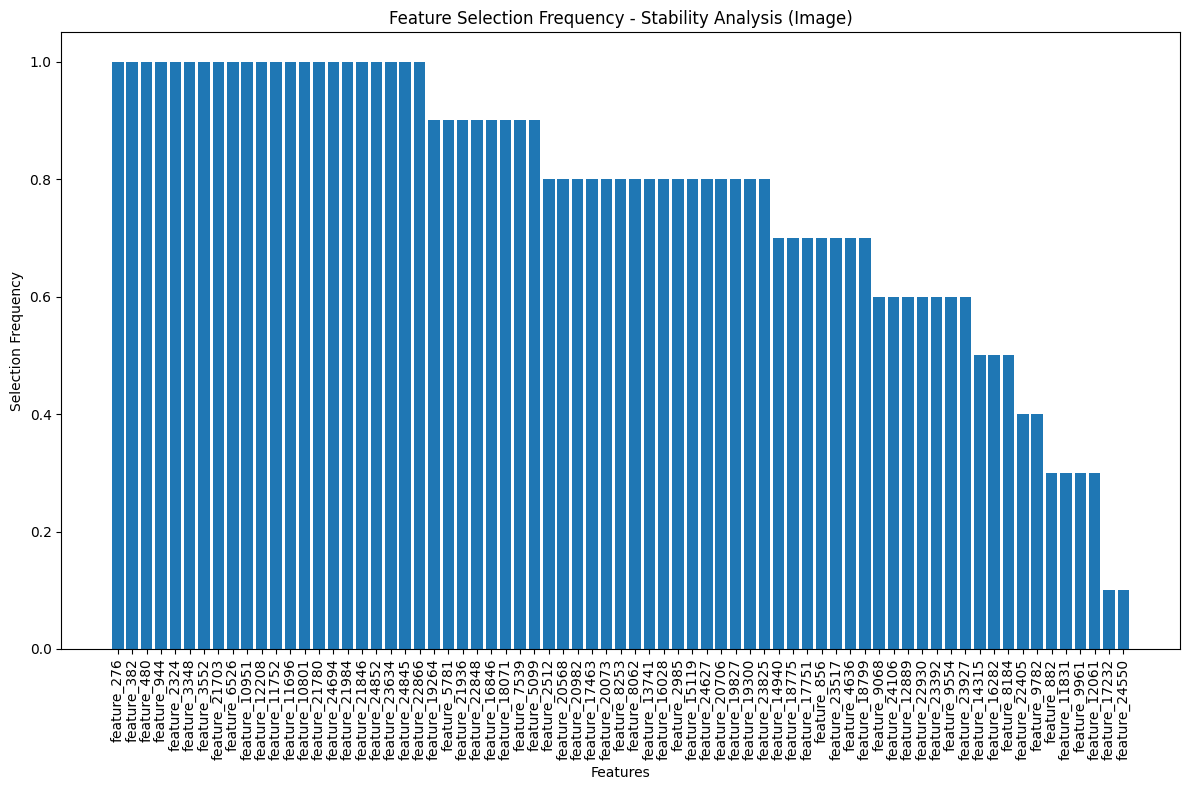


Skipping SMOTE. Using original training data.

Final datasets for 'Image' stored with selected features.

Starting feature selection for 'RadiomicsOnly' Dataset

Handling missing data with SimpleImputer...

Scaling features...

Performing L1-based feature selection...
Number of features after L1-based selection: 82

Skipping Mann-Whitney U Test for 'RadiomicsOnly' dataset. Using L1-selected features.

Performing Stability Analysis with RFECV and Secondary Sorting based on Mean Feature Importance...
Number of stable features selected: 5

Best Stable Features Selected: ['WashinRate_map_Cluster_Shade_tissue_PostCon', 'Grouping_based_proportion_of_3D_tissue_T1_Group_3', 'Ratio_Tissue_vol_enhancing_more_than_20percent_from_PostCon_to_Breast_Vol', 'SER_map_information_measure_correlation1_tumor', 'BEDR2_Tumor']


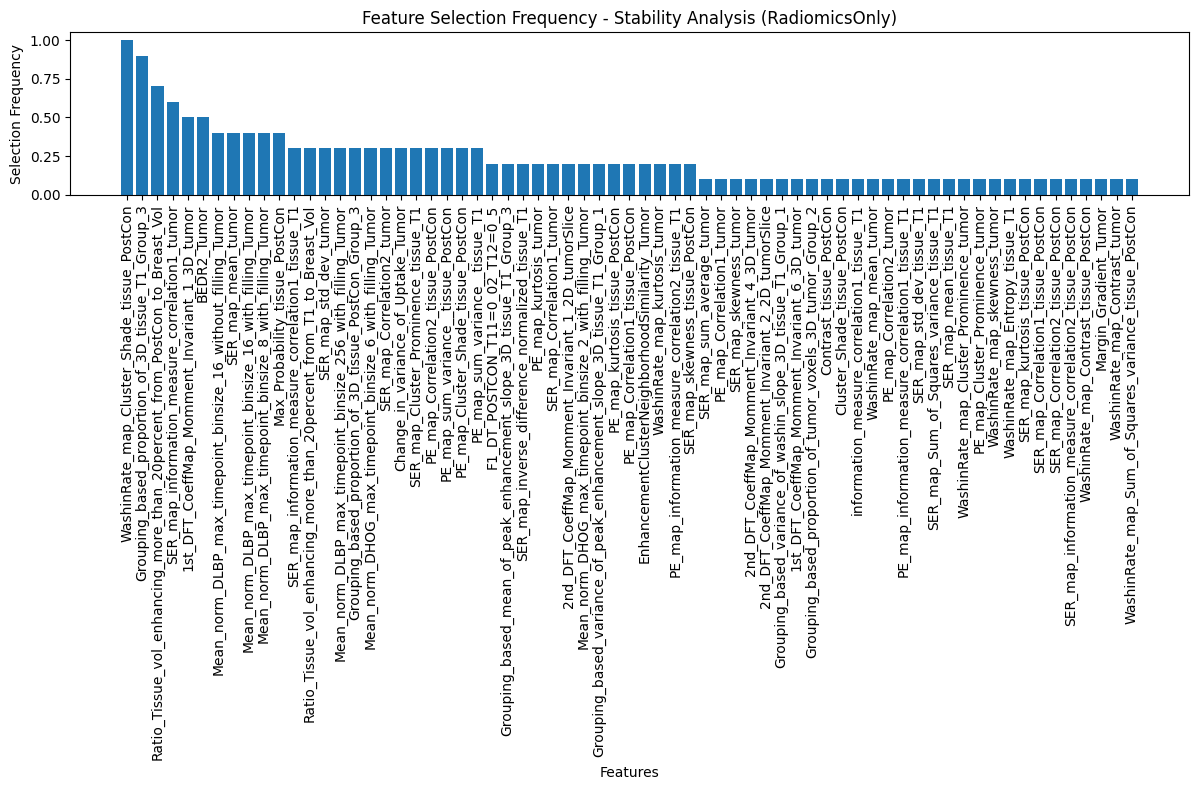


Skipping SMOTE. Using original training data.

Final datasets for 'RadiomicsOnly' stored with selected features.

Starting feature selection for 'ClinicalRadiomics' Dataset

Handling missing data with SimpleImputer...

Scaling features...

Performing L1-based feature selection...
Number of features after L1-based selection: 90

Skipping Mann-Whitney U Test for 'ClinicalRadiomics' dataset. Using L1-selected features.

Performing Stability Analysis with RFECV and Secondary Sorting based on Mean Feature Importance...
Number of stable features selected: 5

Best Stable Features Selected: ['WashinRate_map_Cluster_Shade_tissue_PostCon', 'Ratio_Tissue_vol_enhancing_more_than_20percent_from_PostCon_to_Breast_Vol', 'Mean_norm_DLBP_max_timepoint_binsize_16_with_filling_Tumor', 'PE_map_sum_variance__tissue_PostCon', 'Date_of_Birth']


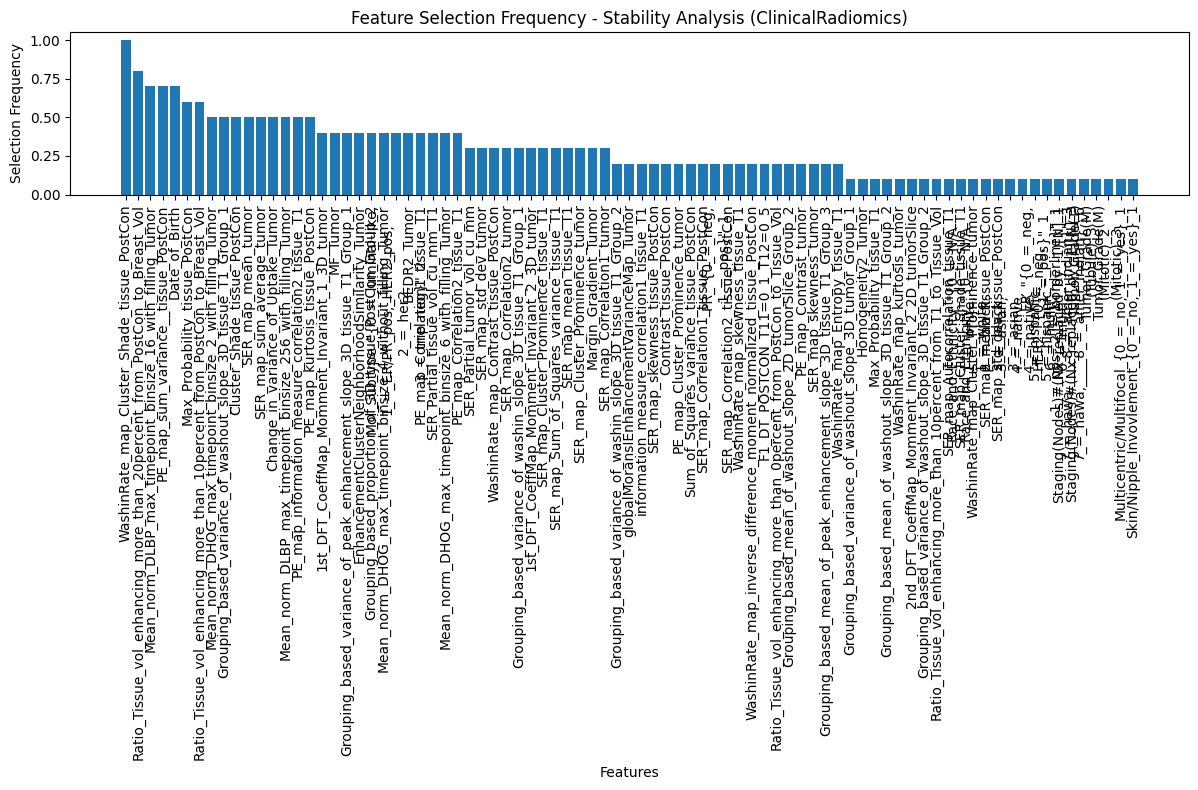


Skipping SMOTE. Using original training data.

Final datasets for 'ClinicalRadiomics' stored with selected features.

Starting feature selection for 'CombinedRadiomics' Dataset

Handling missing data with SimpleImputer...

Scaling features...

Performing L1-based feature selection...
Number of features after L1-based selection: 100

Performing Mann-Whitney U Test feature selection with Bonferroni correction and parallelization...
Number of features after Mann-Whitney U Test: 71

Performing Stability Analysis with RFECV and Secondary Sorting based on Mean Feature Importance...
Number of stable features selected: 10

Best Stable Features Selected: ['feature_3552', 'feature_21780', 'feature_276', 'WashinRate_map_Cluster_Prominence_tumor', 'feature_22006', 'feature_24852', 'Variance_of_Uptake_Tumor', 'feature_382', 'WashinRate_map_sum_entropy_tumor', 'PR_"{0_=_neg,\n1_=_pos}"_1']


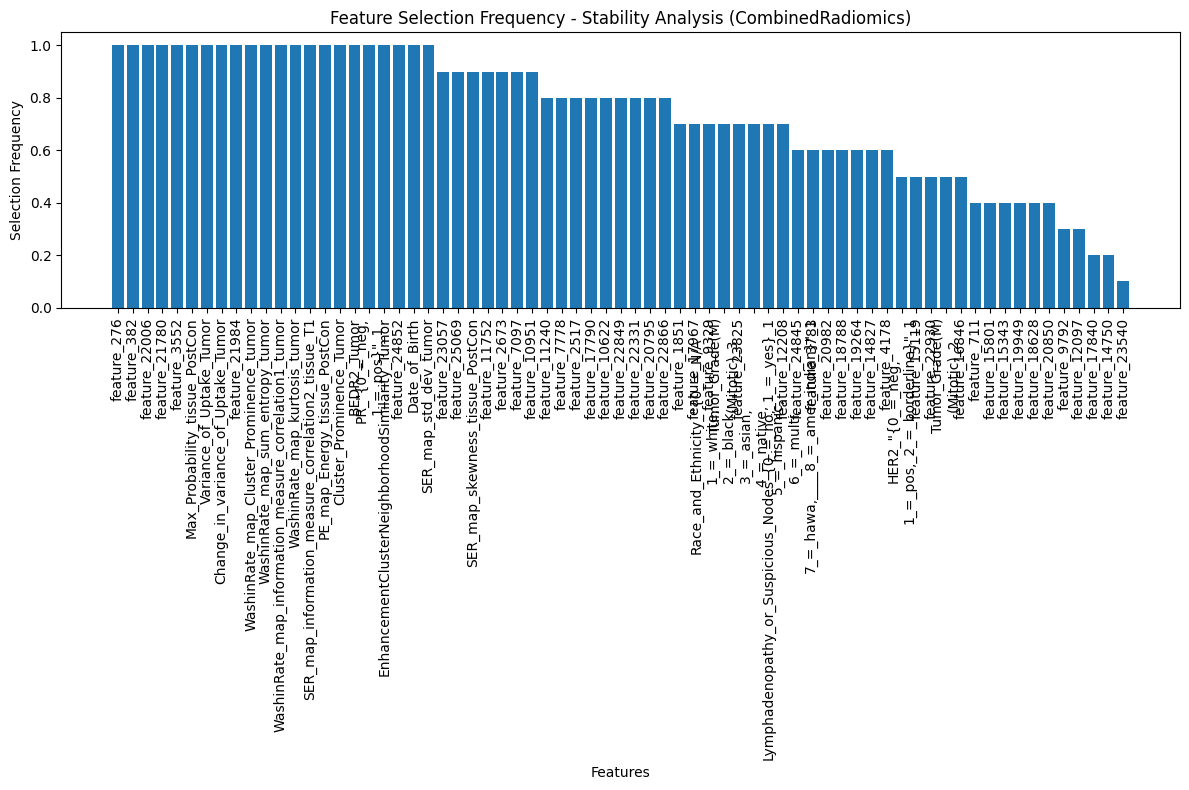


Skipping SMOTE. Using original training data.

Final datasets for 'CombinedRadiomics' stored with selected features.


In [10]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import mannwhitneyu
from joblib import Parallel, delayed
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFECV
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from sklearn.utils import resample
import logging

# =================== Configurable Parameters ===================
MIN_FEATURES = 5          # Minimum number of features to select
MAX_FEATURES = 10         # Maximum number of features to select (set to None to disable)
STABILITY_ITERATIONS = 10    # Number of iterations for stability analysis
STABILITY_THRESHOLD = 0.8    # Threshold for feature selection frequency (e.g., 0.8 for 80%)
# ===============================================================

# =================== Logging Configuration =====================
logging.basicConfig(
    filename='feature_selection_stability.log',
    filemode='a',
    format='%(asctime)s - %(levelname)s - %(message)s',
    level=logging.INFO
)
logger = logging.getLogger(__name__)
# ===============================================================

# =================== Custom Mann-Whitney U Test Feature Selector ===================
class MannWhitneyUTestFeatureSelector(BaseEstimator, TransformerMixin):
    """
    Custom transformer for feature selection using the Mann-Whitney U test
    with Bonferroni correction and optional parallelization.
    """
    def __init__(self, alpha=0.05, bonferroni=True, n_jobs=-1):
        """
        Initialize the selector.

        Parameters:
        - alpha (float): The significance level for the Mann-Whitney U test.
        - bonferroni (bool): Whether to apply Bonferroni correction.
        - n_jobs (int): The number of jobs to run in parallel (default is -1, using all available cores).
        """
        self.alpha = alpha
        self.bonferroni = bonferroni
        self.n_jobs = n_jobs
        self.selected_features_ = None

    def _perform_test(self, col, X, y):
        """
        Helper function to perform Mann-Whitney U test on a single feature.
        """
        group0 = X.loc[y == 0, col]
        group1 = X.loc[y == 1, col]
        try:
            _, p = mannwhitneyu(group0, group1, alternative='two-sided')
        except ValueError:
            p = 1  # Assign high p-value if test fails
        return p

    def fit(self, X, y):
        """
        Fit the selector to the data by performing the Mann-Whitney U test for each feature.
        
        Parameters:
        - X (pd.DataFrame): The input feature matrix.
        - y (pd.Series): The target variable.
        
        Returns:
        - self: The fitted selector.
        """
        # Ensure X is a DataFrame and y is a Series with matching indices
        X = pd.DataFrame(X)
        y = pd.Series(y, index=X.index)
        
        # Parallelized Mann-Whitney U tests
        p_values = Parallel(n_jobs=self.n_jobs)(
            delayed(self._perform_test)(col, X, y) for col in X.columns
        )
        
        self.p_values_ = np.array(p_values)
        
        # Apply Bonferroni correction if needed
        if self.bonferroni:
            corrected_alpha = self.alpha / X.shape[1]  # Adjust alpha by number of tests
        else:
            corrected_alpha = self.alpha

        # Select features with p-values below the corrected alpha level
        self.selected_features_ = X.columns[self.p_values_ < corrected_alpha]
        
        return self

    def transform(self, X):
        """
        Transform the data by selecting the features that passed the Mann-Whitney U test.

        Parameters:
        - X (pd.DataFrame): The input feature matrix.

        Returns:
        - pd.DataFrame: The selected feature matrix.
        """
        # Ensure X is a DataFrame
        X = pd.DataFrame(X)
        return X.loc[:, self.selected_features_]
# =======================================================================================

# =================== Stability Analysis Function ===================
def perform_single_stability_iteration(i, X, y, groups, estimator, cv, scoring, min_features_to_select, step):
    """
    Perform a single stability iteration.

    Parameters:
    - i (int): Current iteration index.
    - X (pd.DataFrame): Feature matrix.
    - y (pd.Series): Target vector.
    - groups (pd.Series): Group labels.
    - estimator: ML estimator for RFECV.
    - cv: Cross-validation strategy.
    - scoring (str): Scoring metric.
    - min_features_to_select (int): Minimum number of features to select.
    - step (int): Number of features to remove at each iteration.

    Returns:
    - selected_features (list): Features selected in this iteration.
    - feature_importances (dict): Feature importances from the estimator.
    """
    logger.info(f"Stability Iteration {i+1}")
    
    # Group-wise Bootstrapping
    unique_groups = groups.unique()
    resampled_groups = resample(unique_groups, replace=True, random_state=42+i)
    mask = groups.isin(resampled_groups)
    X_sample = X.loc[mask].reset_index(drop=True)
    y_sample = y.loc[mask].reset_index(drop=True)
    groups_sample = groups.loc[mask].reset_index(drop=True)

    # RFECV Execution with Group-Aware Cross-Validation
    rfecv = RFECV(
        estimator=estimator,
        step=step,
        cv=cv,
        scoring=scoring,
        min_features_to_select=min_features_to_select,
        n_jobs=1  # Set to 1 to prevent over-parallelization
    )

    rfecv.fit(X_sample, y_sample, groups=groups_sample)
    selected = X_sample.columns[rfecv.support_].tolist()
    logger.info(f"Iteration {i+1}: Selected {len(selected)} features.")

    # Accumulate feature importances if available
    feature_importances = {}
    if hasattr(rfecv.estimator_, 'feature_importances_'):
        importances = rfecv.estimator_.feature_importances_
        for feature, importance in zip(X_sample.columns[rfecv.support_], importances):
            feature_importances[feature] = importance

    return selected, feature_importances

def perform_stability_analysis(X, y, groups, estimator, cv, scoring='f1',
                               min_features_to_select=5, step=1,
                               stability_iterations=10, stability_threshold=0.8,
                               max_features=None):
    """
    Perform stability analysis by running RFECV multiple times on bootstrapped samples
    and selecting features that are consistently selected across iterations,
    using mean feature importance as a secondary sorting criterion.

    Parameters:
    - X (pd.DataFrame): Feature matrix.
    - y (pd.Series): Target vector.
    - groups (pd.Series or array-like): Group labels for the samples.
    - estimator: The machine learning estimator to use for feature selection.
    - cv: Cross-validation strategy.
    - scoring (str): Scoring metric (default is 'f1').
    - min_features_to_select (int): Minimum number of features to select.
    - step (int): Number of features to remove at each iteration.
    - stability_iterations (int): Number of iterations for stability analysis.
    - stability_threshold (float): Proportion threshold to consider a feature as stable.
    - max_features (int or None): Maximum number of features to select. If None, no upper limit.

    Returns:
    - stable_features (list): List of stable features selected based on frequency and importance.
    - feature_counts (Counter): Counts of feature selections across iterations.
    """
    feature_counts = Counter()
    feature_importances_total = defaultdict(float)  # To accumulate feature importances

    # Ensure groups is a pandas Series
    if not isinstance(groups, pd.Series):
        groups = pd.Series(groups).reset_index(drop=True)
    else:
        groups = groups.reset_index(drop=True)

    # Parallelize stability iterations
    results = Parallel(n_jobs=-1, verbose=0)(
        delayed(perform_single_stability_iteration)(
            i, X, y, groups, estimator, cv, scoring, min_features_to_select, step
        )
        for i in range(stability_iterations)
    )

    # Process results
    for selected, feature_importances in results:
        feature_counts.update(selected)
        for feature, importance in feature_importances.items():
            feature_importances_total[feature] += importance

    # Determine stable features based on threshold
    stable_features = [feature for feature, count in feature_counts.items()
                       if (count / stability_iterations) >= stability_threshold]

    # If the number of stable features exceeds max_features, sort by count and then by mean importance
    if max_features is not None and len(stable_features) > max_features:
        # Create a DataFrame for easier manipulation
        freq_df = pd.DataFrame.from_dict(feature_counts, orient='index', columns=['count'])
        freq_df['frequency'] = freq_df['count'] / stability_iterations
        # Filter based on stability threshold
        freq_df = freq_df[freq_df['frequency'] >= stability_threshold]

        # Calculate mean importance
        freq_df['mean_importance'] = freq_df.index.map(lambda x: feature_importances_total[x] / feature_counts[x])

        # Sort by count descending and then by mean importance descending
        freq_df_sorted = freq_df.sort_values(by=['count', 'mean_importance'], ascending=[False, False])

        # Select top max_features
        stable_features = freq_df_sorted.head(max_features).index.tolist()

    # Ensure at least min_features are selected
    if len(stable_features) < min_features_to_select:
        # Select top features to meet the minimum requirement
        stable_features = [feature for feature, count in feature_counts.most_common(min_features_to_select)]

    logger.info(f"Number of stable features selected: {len(stable_features)}")
    print(f"Number of stable features selected: {len(stable_features)}")

    return stable_features, feature_counts
# =======================================================================================

# =================== Feature Selection Pipeline ===================
# Assuming data_splits is a dictionary with keys as dataset names and values as dictionaries:
# {
#     'Dataset1': {
#         'X_train_full': ...,
#         'X_test_full': ...,
#         'y_train_full': ...,
#         'y_test': ...,
#         'patient_ids_train': ...,
#         'patient_ids_test': ...
#     },
#     'Dataset2': { ... },
#     ...
# }

selected_features_dict = {}

apply_smote = False        # Set to False if you want to skip SMOTE
apply_mannwhitney = True   # Set to False if you want to skip Mann-Whitney U Test

datasets_to_skip_mannwhitney = ['Clinical', 'RadiomicsOnly', 'ClinicalRadiomics']
datasets_to_skip_L1 = ['Clinical', 'RadiomicsOnly', 'ClinicalRadiomics']
datasets_for_standard = ['RadiomicsOnly', 'ClinicalRadiomics']

for dataset_name in data_splits.keys():
    
    logger.info(f"\nStarting feature selection for '{dataset_name}' Dataset")
    print(f"\nStarting feature selection for '{dataset_name}' Dataset")
    
    # Retrieve data
    data = data_splits[dataset_name]
    X_train_full = data['X_train_full']
    y_train_full = data['y_train_full']
    X_test_full = data['X_test_full']
    y_test = data['y_test']
    patient_ids_train = data['patient_ids_train']  # Preserving group labels
    patient_ids_test = data['patient_ids_test']
    
    # Handle Missing Data - Imputation
    logger.info("\nHandling missing data with SimpleImputer...")
    print("\nHandling missing data with SimpleImputer...")
    imputer = SimpleImputer(strategy='mean')
    X_train_imputed = imputer.fit_transform(X_train_full)
    X_train_imputed = pd.DataFrame(X_train_imputed, columns=X_train_full.columns, index=X_train_full.index)
    
    # Feature Scaling using MinMaxScaler or StandardScaler
    logger.info("\nScaling features...")
    print("\nScaling features...")
    if dataset_name in datasets_for_standard:
        scaler = StandardScaler()
    else:
        scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train_imputed)
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train_full.columns, index=X_train_full.index)
    
    # L1-based Feature Selection
    logger.info("\nPerforming L1-based feature selection...")
    print("\nPerforming L1-based feature selection...")
    if dataset_name in datasets_to_skip_L1:
        l1_selector = SelectFromModel(
            LogisticRegression(penalty='l1', solver='liblinear', random_state=42, max_iter=1000)
        )
    else:
        l1_selector = SelectFromModel(
            LogisticRegression(penalty='l1', solver='liblinear', random_state=42, max_iter=1000),
            max_features=100  # Adjust as needed or set to None
        )
    l1_selector.fit(X_train_scaled, y_train_full)
    X_train_l1 = l1_selector.transform(X_train_scaled)
    selected_L1_features = X_train_scaled.columns[l1_selector.get_support()].tolist()
    X_train_l1 = pd.DataFrame(X_train_l1, columns=selected_L1_features)
    logger.info(f"Number of features after L1-based selection: {X_train_l1.shape[1]}")
    print(f"Number of features after L1-based selection: {X_train_l1.shape[1]}")
    
    # Mann-Whitney U Test Feature Selection
    if apply_mannwhitney and dataset_name not in datasets_to_skip_mannwhitney:
        logger.info("\nPerforming Mann-Whitney U Test feature selection with Bonferroni correction and parallelization...")
        print("\nPerforming Mann-Whitney U Test feature selection with Bonferroni correction and parallelization...")
        mannwhitney_selector = MannWhitneyUTestFeatureSelector(alpha=0.05, bonferroni=True, n_jobs=-1)
        mannwhitney_selector.fit(X_train_l1, y_train_full)
        X_train_mwu = mannwhitney_selector.transform(X_train_l1)
        logger.info(f"Number of features after Mann-Whitney U Test: {X_train_mwu.shape[1]}")
        print(f"Number of features after Mann-Whitney U Test: {X_train_mwu.shape[1]}")
    else:
        logger.info(f"\nSkipping Mann-Whitney U Test for '{dataset_name}' dataset. Using L1-selected features.")
        print(f"\nSkipping Mann-Whitney U Test for '{dataset_name}' dataset. Using L1-selected features.")
        X_train_mwu = X_train_l1
    
    # Stability Analysis with RFECV and Secondary Sorting
    logger.info("\nPerforming Stability Analysis with RFECV and Secondary Sorting based on Mean Feature Importance...")
    print("\nPerforming Stability Analysis with RFECV and Secondary Sorting based on Mean Feature Importance...")
    
    rf_estimator = RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=50, max_depth=5)
    cv_strategy = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
    
    stable_features, feature_counts = perform_stability_analysis(
        X_train_mwu,
        y_train_full,
        groups=patient_ids_train,
        estimator=rf_estimator,
        cv=cv_strategy,
        scoring='f1',
        min_features_to_select=MIN_FEATURES,
        step=1,                # Remove one feature at a time
        stability_iterations=STABILITY_ITERATIONS,
        stability_threshold=STABILITY_THRESHOLD,
        max_features=MAX_FEATURES  # Set to None to remove the upper limit
    )
    
    logger.info(f"\nBest Stable Features Selected: {stable_features}")
    print(f"\nBest Stable Features Selected: {stable_features}")
    
    # Plot Feature Selection Frequency
    feature_selection_frequency = pd.DataFrame.from_dict(feature_counts, orient='index', columns=['count'])
    feature_selection_frequency['frequency'] = feature_selection_frequency['count'] / STABILITY_ITERATIONS
    feature_selection_frequency = feature_selection_frequency.sort_values(by='frequency', ascending=False)
    
    plt.figure(figsize=(12, 8))
    plt.bar(feature_selection_frequency.index, feature_selection_frequency['frequency'])
    plt.xlabel("Features")
    plt.ylabel("Selection Frequency")
    plt.title(f"Feature Selection Frequency - Stability Analysis ({dataset_name})")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()
    
    # Apply SMOTE **after** feature selection
    if apply_smote:
        logger.info("\nApplying SMOTE to balance the classes after feature selection...")
        print("\nApplying SMOTE to balance the classes after feature selection...")
        smote = SMOTE(random_state=42, n_jobs=-1)
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train_mwu[stable_features], y_train_full)
        X_train_resampled = pd.DataFrame(X_train_resampled, columns=stable_features).reset_index(drop=True)
        y_train_resampled = pd.Series(y_train_resampled).reset_index(drop=True)
        logger.info(f"Number of samples after SMOTE: {X_train_resampled.shape[0]}")
        print(f"Number of samples after SMOTE: {X_train_resampled.shape[0]}")
        logger.info(f"Class distribution after SMOTE:\n{y_train_resampled.value_counts()}")
        print(f"Class distribution after SMOTE:\n{y_train_resampled.value_counts()}")
    else:
        logger.info("\nSkipping SMOTE. Using original training data.")
        print("\nSkipping SMOTE. Using original training data.")
        X_train_resampled = X_train_mwu[stable_features].reset_index(drop=True)
        y_train_resampled = y_train_full.reset_index(drop=True)
    
    # Ensure that all selected features exist in the test dataset
    missing_in_train = set(stable_features) - set(X_train_full.columns)
    missing_in_test = set(stable_features) - set(X_test_full.columns)
    if missing_in_train:
        raise ValueError(f"The following selected features are missing in X_train_full: {missing_in_train}")
    if missing_in_test:
        raise ValueError(f"The following selected features are missing in X_test_full: {missing_in_test}")
    
    # Subset the original X_train_full and X_test_full to include only the selected features
    X_test_final = X_test_full[stable_features].copy().reset_index(drop=True)
    y_test_final = y_test.reset_index(drop=True)
    
    # Store the final datasets with selected features in data_splits
    data_splits[dataset_name] = {
        'X_train_full': X_train_resampled,
        'X_test_full': X_test_final,
        'y_train_full': y_train_resampled,
        'y_test': y_test_final,
        'patient_ids_train': patient_ids_train.reset_index(drop=True),
        'patient_ids_test': patient_ids_test.reset_index(drop=True)
    }

    selected_features_dict[dataset_name] = stable_features
    logger.info(f"\nFinal datasets for '{dataset_name}' stored with selected features.")
    print(f"\nFinal datasets for '{dataset_name}' stored with selected features.")


In [11]:
# Create a new dataset 'CombinedSelected' that combines the selected features from 'Clinical' and 'Image' datasets

print("\nCreating new dataset 'CombinedSelected' from the selected features of 'Clinical' and 'Image' datasets.")

# Retrieve the selected features for 'Clinical' and 'Image' datasets
clinical_selected_features = selected_features_dict['Clinical']
image_selected_features = selected_features_dict['Image']

# Identify overlapping features
overlapping_features = set(clinical_selected_features).intersection(set(image_selected_features))
if overlapping_features:
    print(f"Overlapping features detected: {overlapping_features}")
    logger.info(f"Overlapping features detected: {overlapping_features}")
    # Example handling: Drop overlapping features from Image dataset
    image_selected_features = [feat for feat in image_selected_features if feat not in overlapping_features]
    print(f"Adjusted Image selected features to remove overlaps: {image_selected_features}")
    logger.info(f"Adjusted Image selected features to remove overlaps: {image_selected_features}")

# Retrieve full datasets before splitting from data_variations
X_clinical_full, y_clinical_full, groups_clinical = data_variations['Clinical']
X_image_full, y_image_full, groups_image = data_variations['Image']

# Apply the selected features to the full datasets
X_clinical_selected = X_clinical_full[clinical_selected_features].copy()
X_image_selected = X_image_full[image_selected_features].copy()

# Add 'patient_id' to each dataset
X_clinical_selected['patient_id'] = groups_clinical.astype(str)
X_image_selected['patient_id'] = groups_image.astype(str)

# Merge the datasets on 'patient_id'
combined_df = pd.merge(X_clinical_selected, X_image_selected, on='patient_id', how='inner')

# Remove duplicate columns
combined_df = combined_df.loc[:, ~combined_df.columns.duplicated()]

# Optional: Verify no duplicates remain
assert not combined_df.columns.duplicated().any(), "Duplicate columns still exist in combined_df."

clinical_data_processed = load_clinical_data(clinical_data_path)

# Get the response variable
y_combined = combined_df.merge(
    clinical_data_processed[['patient_id', 'response']],
    on='patient_id',
    how='left')['response'].astype(int)

# Extract patient IDs
groups_combined = combined_df['patient_id']

# Drop 'patient_id' from features
X_combined = combined_df.drop(columns=['patient_id'])

# Now perform train-test split for 'CombinedSelected' dataset
train_idx, test_idx = stratified_group_split(X_combined, y_combined, groups_combined, test_size=0.3, random_state=42)

X_train_full = X_combined.loc[train_idx].reset_index(drop=True)
y_train_full = y_combined.loc[train_idx].reset_index(drop=True)
X_test_full = X_combined.loc[test_idx].reset_index(drop=True)
y_test = y_combined.loc[test_idx].reset_index(drop=True)

patient_ids_train = groups_combined.loc[train_idx].reset_index(drop=True)
patient_ids_test = groups_combined.loc[test_idx].reset_index(drop=True)

# Store in data_splits
data_splits['CombinedSelected'] = {
    'X_train_full': X_train_full,
    'X_test_full': X_test_full,
    'y_train_full': y_train_full,
    'y_test': y_test,
    'patient_ids_train': patient_ids_train,
    'patient_ids_test': patient_ids_test
}

print("New dataset 'CombinedSelected' created and added to data_splits.")
logger.info("New dataset 'CombinedSelected' created and added to data_splits.")



Creating new dataset 'CombinedSelected' from the selected features of 'Clinical' and 'Image' datasets.
Loading clinical data...
Clinical data loaded and processed.
New dataset 'CombinedSelected' created and added to data_splits.


In [12]:
# =================== Define Classifiers and Parameter Grids ===================
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
import xgboost as xgb
import lightgbm as lgb
import numpy as np

# Define classifiers with balanced class weights to handle class imbalance
classifiers = {
    'Logistic Regression': LogisticRegression(
        max_iter=1000,
        solver='liblinear',
        random_state=42,
        class_weight='balanced'
    ),
    'Random Forest': RandomForestClassifier(
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        random_state=42
    ),
    'XGBoost': xgb.XGBClassifier(
        eval_metric='logloss',
        random_state=42,
        n_jobs=-1,
        use_label_encoder=False  # Suppress warning in newer versions
    ),
    'LightGBM': lgb.LGBMClassifier(
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    ),
    'SVM': SVC(
        kernel='rbf',
        probability=True,
        random_state=42,
        max_iter=5000,
        class_weight='balanced'
    )
}

# Define parameter grids with adjustments to prevent overfitting
param_grids = {
    'XGBoost': {
        'classifier__n_estimators': [50, 100],  # Reduced range
        'classifier__learning_rate': [0.01, 0.05, 0.1],  # Added 0.05 for finer tuning
        'classifier__max_depth': [3, 5],  # Limited to prevent overly complex trees
        'classifier__subsample': [0.6, 0.8, 1.0],  # Control overfitting by subsampling
        'classifier__colsample_bytree': [0.6, 0.8, 1.0]  # Control overfitting by feature subsampling
    },
    'LightGBM': {
        'classifier__n_estimators': [50, 100],  # Reduced range
        'classifier__learning_rate': [0.01, 0.05, 0.1],  # Added 0.05 for finer tuning
        'classifier__num_leaves': [31, 63],  # Limited to control model complexity
        'classifier__min_child_samples': [20, 50],  # Prevent overfitting by setting minimum samples
        'classifier__subsample': [0.6, 0.8, 1.0],  # Control overfitting by subsampling
        'classifier__colsample_bytree': [0.6, 0.8, 1.0],  # Control overfitting by feature subsampling
        'classifier__verbose': [-1]
    },
    'Random Forest': {
        'classifier__n_estimators': [100, 200],  # Focused on higher n_estimators for stability
        'classifier__max_depth': [10, 20],  # Limited depth to prevent overfitting
        'classifier__min_samples_split': [5, 10],  # Increased to ensure splits are meaningful
        'classifier__min_samples_leaf': [2, 4],  # Increased to prevent leaves from being too specific
        'classifier__max_features': ['sqrt', 'log2']  # Control over feature selection per split
    },
    'Gradient Boosting': {
        'classifier__n_estimators': [100, 150],  # Focused on higher n_estimators for stability
        'classifier__learning_rate': [0.01, 0.05, 0.1],  # Added 0.05 for finer tuning
        'classifier__max_depth': [3, 5],  # Limited depth to prevent overfitting
        'classifier__subsample': [0.6, 0.8, 1.0],  # Control overfitting by subsampling
        'classifier__min_samples_split': [5, 10],  # Increased to ensure splits are meaningful
        'classifier__min_samples_leaf': [2, 4]  # Increased to prevent leaves from being too specific
    },
    'Logistic Regression': {
        'classifier__C': [0.01, 0.1, 1, 10],  # Smaller range to enforce regularization
        'classifier__penalty': ['l1', 'l2']  # Keep both penalties for flexibility
    },
    'SVM': {
        'classifier__C': [0.1, 1, 5],  # Removed C=10 to prevent overfitting
        'classifier__kernel': ['linear', 'rbf'],
        'classifier__gamma': ['scale', 'auto']  # Added gamma for 'rbf' kernel
    }
}
# ===================================================================================


In [13]:
# Function: Nested Cross Validation for Hyperparameter Tuning

def nested_cv_evaluation(dataset_name, X, y, groups, classifiers, param_grids, outer_splits=3, inner_splits=2):
    """
    Performs nested cross-validation with hyperparameter tuning and group-aware splitting.
    """
    print(f"\nStarting Nested CV for {dataset_name} dataset...")
    outer_cv = StratifiedGroupKFold(n_splits=outer_splits, shuffle=True, random_state=42)
    aggregated_scores = {}
    best_estimators = {}
    nested_scores = {name: [] for name in classifiers.keys()}
    cv_results_all = {name: [] for name in classifiers.keys()}  # To store cv_results_

    for name, base_classifier in classifiers.items():
        print(f"\nEvaluating {name} on {dataset_name} dataset...")
        start_time = time.time()
        scores = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}
        best_estimators[name] = []
        cv_results_list = []  # To collect cv_results_ from each outer fold

        for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X, y, groups=groups), 1):
            print(f"  Outer Fold {fold}/{outer_splits}")
            X_train_fold, X_valid = X.iloc[train_idx], X.iloc[test_idx]
            y_train_fold, y_valid = y.iloc[train_idx], y.iloc[test_idx]
            groups_train_fold = groups.iloc[train_idx]

            # Define the inner cross-validation with group awareness
            inner_cv = StratifiedGroupKFold(n_splits=inner_splits, shuffle=True, random_state=42)


            # **Compute scale_pos_weight for XGBoost and LightGBM**
            if name == 'XGBoost' or name == 'LightGBM':
                scale_pos_weight = (y_train_fold == 0).sum() / (y_train_fold == 1).sum()
                print(f"Computed scale_pos_weight: {scale_pos_weight:.4f} for {name}")
                # Clone the base classifier to avoid modifying the original
                classifier = clone(base_classifier)
                classifier.set_params(scale_pos_weight=scale_pos_weight)
            else:
                classifier = clone(base_classifier)

            # Define the pipeline
            pipeline = ImbPipeline(steps=[
                ('scaler', MinMaxScaler()),
                ('classifier', classifier)
            ])

            # Hyperparameter tuning with RandomizedSearchCV
            search = RandomizedSearchCV(
                estimator=pipeline,
                param_distributions=param_grids[name],
                scoring='f1',
                n_iter=5,  # Adjusted for efficiency
                cv=inner_cv.split(X_train_fold, y_train_fold, groups=groups_train_fold),
                random_state=42,
                n_jobs=-1
            )

            # Fit the model on the training fold
            search.fit(X_train_fold, y_train_fold)

            # Get the best estimator
            best_model = search.best_estimator_

            # Evaluate on the validation fold
            y_pred = best_model.predict(X_valid)

            # Compute metrics
            accuracy = accuracy_score(y_valid, y_pred)
            precision = precision_score(y_valid, y_pred, zero_division=0)
            recall = recall_score(y_valid, y_pred)
            f1 = f1_score(y_valid, y_pred)

            # Append scores
            scores['accuracy'].append(accuracy)
            scores['precision'].append(precision)
            scores['recall'].append(recall)
            scores['f1'].append(f1)
            nested_scores[name].append(f1)

            # Store the best estimator
            best_estimators[name].append(best_model)

            # Collect cv_results_
            cv_results = pd.DataFrame(search.cv_results_)
            cv_results_list.append(cv_results)

        # Aggregate scores
        aggregated_scores[name] = {metric: (np.mean(scores[metric]), np.std(scores[metric])) for metric in scores}

        # Combine cv_results_ from all outer folds
        cv_results_all[name] = pd.concat(cv_results_list, ignore_index=True)

        elapsed_time = time.time() - start_time
        print(f"{name} - Completed in {elapsed_time:.2f} seconds")
        print(f"Aggregated Scores for {name}: {aggregated_scores[name]}")

    return aggregated_scores, best_estimators, nested_scores, cv_results_all


In [14]:
# Nested CV for Hyperparameter Tuning

nested_cv_results = {}  # To store nested CV results
for dataset_name in data_splits.keys():
    print(f"\nStarting Nested Cross-Validation for {dataset_name} Dataset")

    # Retrieve data
    data = data_splits[dataset_name]
    X_train_full = data['X_train_full']
    y_train_full = data['y_train_full']
    groups_train = data['patient_ids_train']

    # Perform nested cross-validation
    aggregated_scores, best_estimators, nested_scores, cv_results_all = nested_cv_evaluation(
        dataset_name, X_train_full, y_train_full, groups_train, classifiers, param_grids
    )

    # Store the results
    nested_cv_results[dataset_name] = {
        'aggregated_scores': aggregated_scores,
        'best_estimators': best_estimators,
        'nested_scores': nested_scores,
        'cv_results_all': cv_results_all
    }



Starting Nested Cross-Validation for Combined Dataset

Starting Nested CV for Combined dataset...

Evaluating Logistic Regression on Combined dataset...
  Outer Fold 1/3
  Outer Fold 2/3
  Outer Fold 3/3
Logistic Regression - Completed in 0.66 seconds
Aggregated Scores for Logistic Regression: {'accuracy': (np.float64(0.8547797887733434), np.float64(0.023405660429103702)), 'precision': (np.float64(0.9195026545923154), np.float64(0.015263922172508005)), 'recall': (np.float64(0.8014146715244044), np.float64(0.0216155600109485)), 'f1': (np.float64(0.8561183937528024), np.float64(0.011455216085240662))}

Evaluating Random Forest on Combined dataset...
  Outer Fold 1/3
  Outer Fold 2/3
  Outer Fold 3/3
Random Forest - Completed in 3.56 seconds
Aggregated Scores for Random Forest: {'accuracy': (np.float64(0.8390591915043801), np.float64(0.015802916951322077)), 'precision': (np.float64(0.8816755603130456), np.float64(0.03565587935534783)), 'recall': (np.float64(0.8103306442285451), np.float6

/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:26:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:26:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:26:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/xgboost/

  Outer Fold 2/3
Computed scale_pos_weight: 0.7410 for XGBoost


/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:26:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:26:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:26:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/xgboost/

  Outer Fold 3/3
Computed scale_pos_weight: 0.8094 for XGBoost


/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:26:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:26:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:26:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/xgboost/

XGBoost - Completed in 1.07 seconds
Aggregated Scores for XGBoost: {'accuracy': (np.float64(0.8370543301129082), np.float64(0.024789905535755434)), 'precision': (np.float64(0.9047053197251212), np.float64(0.027729797812394447)), 'recall': (np.float64(0.780023276659727), np.float64(0.013312520777235024)), 'f1': (np.float64(0.8374973141179356), np.float64(0.014404283694882598))}

Evaluating LightGBM on Combined dataset...
  Outer Fold 1/3
Computed scale_pos_weight: 1.0166 for LightGBM
  Outer Fold 2/3
Computed scale_pos_weight: 0.7410 for LightGBM
  Outer Fold 3/3
Computed scale_pos_weight: 0.8094 for LightGBM
LightGBM - Completed in 27.30 seconds
Aggregated Scores for LightGBM: {'accuracy': (np.float64(0.8346132079867791), np.float64(0.0071443275281043266)), 'precision': (np.float64(0.8676691554744428), np.float64(0.042505749020174566)), 'recall': (np.float64(0.815956800832755), np.float64(0.024421671277046895)), 'f1': (np.float64(0.839915829024599), np.float64(0.014392590709145593))}



/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:27:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:27:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:27:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/xgboost/

  Outer Fold 2/3
Computed scale_pos_weight: 3.2069 for XGBoost
  Outer Fold 3/3
Computed scale_pos_weight: 3.0667 for XGBoost


/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:27:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:27:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:27:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/xgboost/

XGBoost - Completed in 0.49 seconds
Aggregated Scores for XGBoost: {'accuracy': (np.float64(0.6612021857923498), np.float64(0.015455885927574773)), 'precision': (np.float64(0.37100684261974587), np.float64(0.05102923180232064)), 'recall': (np.float64(0.6921820010055305), np.float64(0.1119396603799425)), 'f1': (np.float64(0.4785247432306255), np.float64(0.048196820753144715))}

Evaluating LightGBM on Clinical dataset...
  Outer Fold 1/3
Computed scale_pos_weight: 3.8800 for LightGBM
  Outer Fold 2/3
Computed scale_pos_weight: 3.2069 for LightGBM
  Outer Fold 3/3
Computed scale_pos_weight: 3.0667 for LightGBM
LightGBM - Completed in 1.77 seconds
Aggregated Scores for LightGBM: {'accuracy': (np.float64(0.5573770491803278), np.float64(0.026770379702548378)), 'precision': (np.float64(0.32999164578111945), np.float64(0.046802269825996)), 'recall': (np.float64(0.9052287581699346), np.float64(0.06993769463736174)), 'f1': (np.float64(0.481237911025145), np.float64(0.04932668347078917))}

Evalua

/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:27:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:27:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:27:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/xgboost/

  Outer Fold 2/3
Computed scale_pos_weight: 0.7410 for XGBoost


/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:27:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:27:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:27:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/xgboost/

  Outer Fold 3/3
Computed scale_pos_weight: 0.8094 for XGBoost


/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:27:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:27:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:27:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/xgboost/

XGBoost - Completed in 0.91 seconds
Aggregated Scores for XGBoost: {'accuracy': (np.float64(0.8248600283646743), np.float64(0.030044083946715743)), 'precision': (np.float64(0.906231857801397), np.float64(0.016680762046721594)), 'recall': (np.float64(0.7532710212815174), np.float64(0.022177570585489293)), 'f1': (np.float64(0.8226173753426557), np.float64(0.01876042900304423))}

Evaluating LightGBM on Image dataset...
  Outer Fold 1/3
Computed scale_pos_weight: 1.0166 for LightGBM
  Outer Fold 2/3
Computed scale_pos_weight: 0.7410 for LightGBM
  Outer Fold 3/3
Computed scale_pos_weight: 0.8094 for LightGBM
LightGBM - Completed in 22.37 seconds
Aggregated Scores for LightGBM: {'accuracy': (np.float64(0.8180224671095385), np.float64(0.038229685106774665)), 'precision': (np.float64(0.8792280906320848), np.float64(0.02794891481886228)), 'recall': (np.float64(0.7689639717788573), np.float64(0.027580762911135783)), 'f1': (np.float64(0.8204027154611021), np.float64(0.02784613351988872))}

Evalu

/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:28:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:28:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:28:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/xgboost/

  Outer Fold 3/3
Computed scale_pos_weight: 3.2414 for XGBoost
XGBoost - Completed in 0.47 seconds
Aggregated Scores for XGBoost: {'accuracy': (np.float64(0.6852635289970034), np.float64(0.06292830897861097)), 'precision': (np.float64(0.34962406015037595), np.float64(0.06773875564781744)), 'recall': (np.float64(0.37522893772893773), np.float64(0.04784853304276685)), 'f1': (np.float64(0.36155202821869487), np.float64(0.05865357724273682))}

Evaluating LightGBM on RadiomicsOnly dataset...
  Outer Fold 1/3
Computed scale_pos_weight: 3.1000 for LightGBM


/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:28:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:28:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:28:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/xgboost/

  Outer Fold 2/3
Computed scale_pos_weight: 3.5185 for LightGBM
  Outer Fold 3/3
Computed scale_pos_weight: 3.2414 for LightGBM
LightGBM - Completed in 1.67 seconds
Aggregated Scores for LightGBM: {'accuracy': (np.float64(0.6197778952934955), np.float64(0.02767102158001297)), 'precision': (np.float64(0.29634400687032264), np.float64(0.023853664798507687)), 'recall': (np.float64(0.4615384615384615), np.float64(0.05439282932204211)), 'f1': (np.float64(0.36078042328042326), np.float64(0.03429282231662278))}

Evaluating SVM on RadiomicsOnly dataset...
  Outer Fold 1/3
  Outer Fold 2/3
  Outer Fold 3/3
SVM - Completed in 0.30 seconds
Aggregated Scores for SVM: {'accuracy': (np.float64(0.6571478935307598), np.float64(0.06032626761774782)), 'precision': (np.float64(0.18081435472739824), np.float64(0.13068467013008614)), 'recall': (np.float64(0.2948717948717949), np.float64(0.21376066667350085)), 'f1': (np.float64(0.22416534181240064), np.float64(0.16219852663331927))}

Starting Nested Cross-V

/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:28:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:28:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:28:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/xgboost/

  Outer Fold 3/3
Computed scale_pos_weight: 3.2414 for XGBoost
XGBoost - Completed in 0.46 seconds
Aggregated Scores for XGBoost: {'accuracy': (np.float64(0.7447558610964217), np.float64(0.03191184700165103)), 'precision': (np.float64(0.4239316239316239), np.float64(0.08543589059555418)), 'recall': (np.float64(0.3621794871794872), np.float64(0.1684446582496271)), 'f1': (np.float64(0.37630270963604295), np.float64(0.14233948484261086))}

Evaluating LightGBM on ClinicalRadiomics dataset...
  Outer Fold 1/3
Computed scale_pos_weight: 3.1000 for LightGBM


/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:28:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:28:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:28:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/xgboost/

  Outer Fold 2/3
Computed scale_pos_weight: 3.5185 for LightGBM
  Outer Fold 3/3
Computed scale_pos_weight: 3.2414 for LightGBM
LightGBM - Completed in 1.72 seconds
Aggregated Scores for LightGBM: {'accuracy': (np.float64(0.5649568129737353), np.float64(0.07502340925090635)), 'precision': (np.float64(0.2980556029336517), np.float64(0.02147682492171148)), 'recall': (np.float64(0.6128663003663003), np.float64(0.142169039355213)), 'f1': (np.float64(0.39289248762932977), np.float64(0.017803311227106162))}

Evaluating SVM on ClinicalRadiomics dataset...
  Outer Fold 1/3
  Outer Fold 2/3
  Outer Fold 3/3
SVM - Completed in 0.31 seconds
Aggregated Scores for SVM: {'accuracy': (np.float64(0.7013925612550679), np.float64(0.04454318530246081)), 'precision': (np.float64(0.37083333333333335), np.float64(0.04124789556921528)), 'recall': (np.float64(0.3972069597069597), np.float64(0.12320891734364138)), 'f1': (np.float64(0.3769714407502131), np.float64(0.06774984019868809))}

Starting Nested Cross-V

/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:28:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:28:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:28:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/xgboost/

  Outer Fold 2/3
Computed scale_pos_weight: 0.7410 for XGBoost


/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:28:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:28:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:28:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/xgboost/

  Outer Fold 3/3
Computed scale_pos_weight: 0.8094 for XGBoost


/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:28:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:28:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:28:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/xgboost/

XGBoost - Completed in 0.85 seconds
Aggregated Scores for XGBoost: {'accuracy': (np.float64(0.8097313287642752), np.float64(0.00996354690349014)), 'precision': (np.float64(0.8596467714725797), np.float64(0.06914591562352286)), 'recall': (np.float64(0.7799083391163544), np.float64(0.051322468103252694)), 'f1': (np.float64(0.8135931170386487), np.float64(0.010158900565771473))}

Evaluating LightGBM on CombinedRadiomics dataset...
  Outer Fold 1/3
Computed scale_pos_weight: 1.0166 for LightGBM
  Outer Fold 2/3
Computed scale_pos_weight: 0.7410 for LightGBM
  Outer Fold 3/3
Computed scale_pos_weight: 0.8094 for LightGBM
LightGBM - Completed in 18.05 seconds
Aggregated Scores for LightGBM: {'accuracy': (np.float64(0.8157703219006723), np.float64(0.022433603217134352)), 'precision': (np.float64(0.8703554290546243), np.float64(0.049559330408043216)), 'recall': (np.float64(0.779704487624335), np.float64(0.05746026841596621)), 'f1': (np.float64(0.8190363712393544), np.float64(0.0127053146036160

/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:28:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:28:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:28:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/xgboost/

  Outer Fold 2/3
Computed scale_pos_weight: 0.9309 for XGBoost


/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:28:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:28:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:28:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/xgboost/

  Outer Fold 3/3
Computed scale_pos_weight: 0.8408 for XGBoost


/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:28:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:28:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:28:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/xgboost/

XGBoost - Completed in 1.06 seconds
Aggregated Scores for XGBoost: {'accuracy': (np.float64(0.8242697726915701), np.float64(0.005989227414790772)), 'precision': (np.float64(0.8978213051645133), np.float64(0.032726325371556175)), 'recall': (np.float64(0.7612542231642255), np.float64(0.009595243869979998)), 'f1': (np.float64(0.823515423888884), np.float64(0.011463951724196257))}

Evaluating LightGBM on CombinedSelected dataset...
  Outer Fold 1/3
Computed scale_pos_weight: 0.7624 for LightGBM
  Outer Fold 2/3
Computed scale_pos_weight: 0.9309 for LightGBM
  Outer Fold 3/3
Computed scale_pos_weight: 0.8408 for LightGBM
LightGBM - Completed in 24.11 seconds
Aggregated Scores for LightGBM: {'accuracy': (np.float64(0.8318874352933948), np.float64(0.006670387531884422)), 'precision': (np.float64(0.8972395322470202), np.float64(0.03961364464645306)), 'recall': (np.float64(0.7790741646513228), np.float64(0.03346042479794961)), 'f1': (np.float64(0.8327187954391762), np.float64(0.0157470555003030

/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated earl

  Outer Fold 2/3


/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


  Outer Fold 3/3


/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVM - Completed in 2.06 seconds
Aggregated Scores for SVM: {'accuracy': (np.float64(0.8335172280979012), np.float64(0.021088458976151882)), 'precision': (np.float64(0.9277658100248258), np.float64(0.0606461613035116)), 'recall': (np.float64(0.7491083802070596), np.float64(0.011243520032533575)), 'f1': (np.float64(0.8282964127051285), np.float64(0.030168456031867078))}


In [15]:
# Retrain Models on Entire Training Set Using Best Hyperparameters and Evaluate on Test Set

from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, classification_report)
from sklearn.base import clone

test_results = {}  # To store test set results

for dataset_name in data_splits.keys():
    print(f"\nRetraining and Evaluating Models for {dataset_name} Dataset")
    
    # Retrieve data splits for the current dataset
    data = data_splits[dataset_name]
    X_train_full = data['X_train_full']
    y_train_full = data['y_train_full']
    X_test_full = data['X_test_full']
    y_test = data['y_test']
    groups_train = data['patient_ids_train']
    groups_test = data['patient_ids_test']
    
    # Reset indices to ensure consistency
    X_train_full = X_train_full.reset_index(drop=True)
    y_train_full = y_train_full.reset_index(drop=True)
    X_test_full = X_test_full.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)
    
    # Get nested CV results for the current dataset
    nested_results = nested_cv_results[dataset_name]
    cv_results_all = nested_results['cv_results_all']
    
    test_results[dataset_name] = {}  # Initialize dictionary to store test results for each classifier
    
    for classifier_name in classifiers.keys():
        print(f"\nRetraining {classifier_name} on {dataset_name} dataset...")
        
        # Get cross-validation results for the current classifier
        cv_results = cv_results_all[classifier_name]
        
        # Find the hyperparameters with the best mean_test_score (which is F1 score)
        max_mean_test_score = cv_results['mean_test_score'].max()
        best_rows = cv_results[cv_results['mean_test_score'] == max_mean_test_score]
        
        # If multiple rows have the same max score, pick the first one
        best_row = best_rows.iloc[0]
        
        # Extract the best hyperparameters from the pipeline parameters
        best_params = best_row['params']
        
        # The params are for the entire pipeline; extract classifier's hyperparameters
        classifier_params = {}
        for param_name, param_value in best_params.items():
            if param_name.startswith('classifier__'):
                # Remove 'classifier__' prefix to get the parameter name
                param_short = param_name.replace('classifier__', '')
                classifier_params[param_short] = param_value
        
        # Get the default classifier with default parameters
        default_classifier = classifiers[classifier_name]
        
        # Clone the default classifier to avoid modifying the original
        classifier = clone(default_classifier)
        
        # Update the classifier's parameters with the best hyperparameters
        classifier.set_params(**classifier_params)

        # **Compute scale_pos_weight for XGBoost and LightGBM**
        if classifier_name == 'XGBoost' or classifier_name == 'LightGBM':
            scale_pos_weight = (y_train_full == 0).sum() / (y_train_full == 1).sum()
            print(f"Computed scale_pos_weight: {scale_pos_weight:.4f} for {classifier_name}")
            classifier.set_params(scale_pos_weight=scale_pos_weight)
        
        # Handle compatibility between solver and penalty for Logistic Regression
        if classifier_name == 'Logistic Regression':
            penalty = classifier.get_params().get('penalty', 'l2')
            solver = classifier.get_params().get('solver', 'lbfgs')
            if penalty == 'l1' and solver not in ['liblinear', 'saga']:
                # Change solver to 'liblinear' if penalty is 'l1'
                classifier.set_params(solver='liblinear')
                print(f"Adjusted solver to 'liblinear' for 'l1' penalty.")
            elif penalty == 'elasticnet' and solver != 'saga':
                # 'elasticnet' penalty requires 'saga' solver
                classifier.set_params(solver='saga')
                print(f"Adjusted solver to 'saga' for 'elasticnet' penalty.")
            elif penalty == 'l2' and solver == 'liblinear' and classifier.get_params().get('dual', False):
                # Dual formulation is only implemented for l2 penalty with liblinear solver
                classifier.set_params(dual=True)
            else:
                # Ensure dual is False for other solvers
                classifier.set_params(dual=False)
        
        # Apply SMOTE to training data only
        #print("\nApplying SMOTE to balance the classes in the training data...")
        #smote = SMOTE(random_state=42)
        #X_train_resampled, y_train_resampled = smote.fit_resample(X_train_full, y_train_full)
        
        # Define the pipeline without SMOTE
        pipeline = Pipeline(steps=[
            ('scaler', MinMaxScaler()),
            ('classifier', classifier)
        ])
        
        # Fit the pipeline on the entire training set
        pipeline.fit(X_train_full, y_train_full)
        
        # Predict on the test set
        y_pred = pipeline.predict(X_test_full)
        
        # Get predicted probabilities if available
        y_proba = pipeline.predict_proba(X_test_full)[:, 1] if hasattr(pipeline, "predict_proba") else None
        
        # Compute performance metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=0)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None
        conf_matrix = confusion_matrix(y_test, y_pred)
        class_report = classification_report(y_test, y_pred, zero_division=0)
        
        # Store the test results
        test_results[dataset_name][classifier_name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'roc_auc': roc_auc,
            'confusion_matrix': conf_matrix,
            'classification_report': class_report
        }
        
        # Print the results
        print(f"{classifier_name} Test Results on {dataset_name} Dataset:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
        if roc_auc is not None:
            print(f"ROC AUC Score: {roc_auc:.4f}")
        print("Confusion Matrix:")
        print(conf_matrix)
        print("Classification Report:")
        print(class_report)



Retraining and Evaluating Models for Combined Dataset

Retraining Logistic Regression on Combined dataset...
Logistic Regression Test Results on Combined Dataset:
Accuracy: 0.8168
Precision: 0.8565
Recall: 0.7953
F1 Score: 0.8248
ROC AUC Score: 0.8967
Confusion Matrix:
[[518  97]
 [149 579]]
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.84      0.81       615
           1       0.86      0.80      0.82       728

    accuracy                           0.82      1343
   macro avg       0.82      0.82      0.82      1343
weighted avg       0.82      0.82      0.82      1343


Retraining Random Forest on Combined dataset...
Random Forest Test Results on Combined Dataset:
Accuracy: 0.8101
Precision: 0.8535
Recall: 0.7843
F1 Score: 0.8175
ROC AUC Score: 0.8797
Confusion Matrix:
[[517  98]
 [157 571]]
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.84      0.80       6

In [16]:
# Displaying Comprehensive Performance Metrics for Each Model on Test Set

for dataset_name, classifiers_results in test_results.items():
    print(f"\nTest Results for {dataset_name} Dataset:")
    for classifier_name, metrics in classifiers_results.items():
        print(f"\nClassifier: {classifier_name}")
        print(f"Accuracy: {metrics['accuracy']:.4f}")
        print(f"Precision: {metrics['precision']:.4f}")
        print(f"Recall: {metrics['recall']:.4f}")
        print(f"F1 Score: {metrics['f1']:.4f}")
        if metrics['roc_auc'] is not None:
            print(f"ROC AUC Score: {metrics['roc_auc']:.4f}")
        print("Confusion Matrix:")
        print(metrics['confusion_matrix'])
        print("Classification Report:")
        print(metrics['classification_report'])



Test Results for Combined Dataset:

Classifier: Logistic Regression
Accuracy: 0.8168
Precision: 0.8565
Recall: 0.7953
F1 Score: 0.8248
ROC AUC Score: 0.8967
Confusion Matrix:
[[518  97]
 [149 579]]
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.84      0.81       615
           1       0.86      0.80      0.82       728

    accuracy                           0.82      1343
   macro avg       0.82      0.82      0.82      1343
weighted avg       0.82      0.82      0.82      1343


Classifier: Random Forest
Accuracy: 0.8101
Precision: 0.8535
Recall: 0.7843
F1 Score: 0.8175
ROC AUC Score: 0.8797
Confusion Matrix:
[[517  98]
 [157 571]]
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.84      0.80       615
           1       0.85      0.78      0.82       728

    accuracy                           0.81      1343
   macro avg       0.81      0.81      0.81      1343

In [17]:
# Slice wise Youden's J Threshold prediction

import numpy as np
from sklearn.metrics import roc_curve

# Define a consistent suffix for adjusted classifiers
THRESHOLD_ADJUSTED_SUFFIX = ' (Threshold Adjusted)'

# Helper function to extract the base classifier name by removing any suffix in parentheses
def get_base_classifier_name(name):
    if '(' in name and ')' in name:
        return name.split('(')[0].strip()
    return name

# Function to find optimal threshold using Youden's J-statistic
def find_optimal_threshold(y_true, y_proba):
    fpr, tpr, thresholds = roc_curve(y_true, y_proba)
    J = tpr - fpr
    ix = np.argmax(J)
    optimal_threshold = thresholds[ix]
    print(f"Optimal Threshold (Youden's J): {optimal_threshold:.4f}")
    return optimal_threshold

# Apply threshold adjustment to each classifier on each dataset
for dataset_name in test_results.keys():
    print(f"\nAdjusting Thresholds for {dataset_name} Dataset:")
    classifier_names = list(test_results[dataset_name].keys())  # Get current classifier names
    for classifier_name in classifier_names:
        if THRESHOLD_ADJUSTED_SUFFIX in classifier_name:
            continue  # Skip already adjusted classifiers
        print(f"\nClassifier: {classifier_name}")
        
        # Retrieve the pipeline and test data
        data = data_splits[dataset_name]
        X_test_full = data['X_test_full']
        y_test = data['y_test']
        X_train_full = data['X_train_full']
        y_train_full = data['y_train_full']
        
        # Extract base classifier name
        base_classifier_name = get_base_classifier_name(classifier_name)
        
        # Get the best hyperparameters from nested_cv_results
        nested_results = nested_cv_results[dataset_name]
        cv_results_all = nested_results['cv_results_all']
        try:
            cv_results = cv_results_all[base_classifier_name]
        except KeyError:
            print(f"Error: '{base_classifier_name}' not found in cv_results_all for dataset '{dataset_name}'. Skipping threshold adjustment for this classifier.")
            continue
        
        # Find the hyperparameters with the best mean_test_score (F1 score)
        max_mean_test_score = cv_results['mean_test_score'].max()
        best_rows = cv_results[cv_results['mean_test_score'] == max_mean_test_score]
        
        # If multiple rows have the same max score, pick the first one
        best_row = best_rows.iloc[0]
        
        # Extract the best hyperparameters from the pipeline parameters
        best_params = best_row['params']
        
        # The params are for the entire pipeline; extract classifier's hyperparameters
        classifier_params = {}
        for param_name, param_value in best_params.items():
            if param_name.startswith('classifier__'):
                # Remove 'classifier__' prefix to get the parameter name
                param_short = param_name.replace('classifier__', '')
                classifier_params[param_short] = param_value
        
        # Get the default classifier from the classifiers dictionary
        default_classifier = classifiers[base_classifier_name]
        
        # Clone the default classifier to avoid modifying the original
        classifier = clone(default_classifier)
        
        # Update the classifier's parameters with the best hyperparameters
        classifier.set_params(**classifier_params)
        
        # **Compute scale_pos_weight for XGBoost and LightGBM**
        if classifier_name == 'XGBoost' or classifier_name == 'LightGBM':
            scale_pos_weight = (y_train_full == 0).sum() / (y_train_full == 1).sum()
            print(f"Computed scale_pos_weight: {scale_pos_weight:.4f} for {classifier_name}")
            classifier.set_params(scale_pos_weight=scale_pos_weight)

        # Handle compatibility between solver and penalty for Logistic Regression
        if base_classifier_name == 'Logistic Regression':
            penalty = classifier.get_params().get('penalty', 'l2')
            solver = classifier.get_params().get('solver', 'lbfgs')
            if penalty == 'l1' and solver not in ['liblinear', 'saga']:
                # Change solver to 'liblinear' if penalty is 'l1'
                classifier.set_params(solver='liblinear')
                print(f"Adjusted solver to 'liblinear' for 'l1' penalty.")
            elif penalty == 'elasticnet' and solver != 'saga':
                # 'elasticnet' penalty requires 'saga' solver
                classifier.set_params(solver='saga')
                print(f"Adjusted solver to 'saga' for 'elasticnet' penalty.")
            elif penalty == 'l2' and solver == 'liblinear' and classifier.get_params().get('dual', False):
                # Dual formulation is only implemented for l2 penalty with liblinear solver
                classifier.set_params(dual=True)
            else:
                # Ensure dual is False for other solvers
                classifier.set_params(dual=False)
        

        # Apply SMOTE to training data only
        #print("\nApplying SMOTE to balance the classes in the training data...")
        #smote = SMOTE(random_state=42)
        #X_train_resampled, y_train_resampled = smote.fit_resample(X_train_full, y_train_full)
        
        # Define the pipeline without SMOTE
        pipeline = Pipeline(steps=[
            ('scaler', MinMaxScaler()),
            ('classifier', classifier)
        ])
        
        # Fit the pipeline on the entire training set
        pipeline.fit(X_train_full, y_train_full)
        
        # Compute predicted probabilities on training data
        y_proba_train = pipeline.predict_proba(X_train_full)[:, 1] if hasattr(pipeline, "predict_proba") else None
        
        # Check if y_proba_train is available
        if y_proba_train is None:
            print("Predicted probabilities not available on training data. Skipping threshold adjustment.")
            continue
        
        # Find optimal threshold using training data
        optimal_threshold = find_optimal_threshold(y_train_full, y_proba_train)
        
        # Compute predicted probabilities on test data
        y_proba = pipeline.predict_proba(X_test_full)[:, 1]
        
        # Make predictions with the optimal threshold
        y_pred_optimal = (y_proba >= optimal_threshold).astype(int)

        
        # Evaluate performance
        accuracy = accuracy_score(y_test, y_pred_optimal)
        precision = precision_score(y_test, y_pred_optimal, zero_division=0)
        recall = recall_score(y_test, y_pred_optimal)
        f1 = f1_score(y_test, y_pred_optimal)
        roc_auc = roc_auc_score(y_test, y_proba)
        conf_matrix = confusion_matrix(y_test, y_pred_optimal)
        class_report = classification_report(y_test, y_pred_optimal, zero_division=0)
        
        # Define the adjusted classifier name
        adjusted_classifier_name = f"{base_classifier_name}{THRESHOLD_ADJUSTED_SUFFIX}"
        
        # Update the results with adjusted threshold
        test_results[dataset_name][adjusted_classifier_name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'roc_auc': roc_auc,
            'confusion_matrix': conf_matrix,
            'classification_report': class_report
        }
        
        # Print the results
        print(f"Adjusted Threshold Test Results:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print(f"ROC AUC Score: {roc_auc:.4f}")
        print("Confusion Matrix:")
        print(conf_matrix)
        print("Classification Report:")
        print(class_report)



Adjusting Thresholds for Combined Dataset:

Classifier: Logistic Regression
Optimal Threshold (Youden's J): 0.5858
Adjusted Threshold Test Results:
Accuracy: 0.8340
Precision: 0.9014
Recall: 0.7788
F1 Score: 0.8357
ROC AUC Score: 0.8967
Confusion Matrix:
[[553  62]
 [161 567]]
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.90      0.83       615
           1       0.90      0.78      0.84       728

    accuracy                           0.83      1343
   macro avg       0.84      0.84      0.83      1343
weighted avg       0.84      0.83      0.83      1343


Classifier: Random Forest
Optimal Threshold (Youden's J): 0.3135
Adjusted Threshold Test Results:
Accuracy: 0.7766
Precision: 0.7730
Recall: 0.8324
F1 Score: 0.8016
ROC AUC Score: 0.8797
Confusion Matrix:
[[437 178]
 [122 606]]
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.71      0.74       615
          

In [18]:
# Get the best hyperparameters for each classifier in each dataset
best_parameters = []

# Iterate through each dataset in nested_cv_results
for dataset, dataset_results in nested_cv_results.items():
    cv_results_all = dataset_results.get('cv_results_all', {})
    
    # Iterate through each classifier in the current dataset
    for classifier, cv_results in cv_results_all.items():
        if cv_results.empty:
            print(f"No cross-validation results found for {classifier} in {dataset}.")
            continue
        
        # Identify the row with the highest mean_test_score
        best_row = cv_results.loc[cv_results['mean_test_score'].idxmax()]
        best_params = best_row['params']
        best_score = best_row['mean_test_score']
        
        # Append the results to the list
        best_parameters.append({
            'Dataset': dataset,
            'Classifier': classifier,
            'Best Score (F1)': best_score,
            'Best Hyperparameters': best_params
        })

# Convert the list to a DataFrame
best_params_df = pd.DataFrame(best_parameters)

# Optional: Expand the 'Best Hyperparameters' column for better readability
# This will create separate columns for each hyperparameter
best_params_expanded = best_params_df.join(
    best_params_df.pop('Best Hyperparameters').apply(pd.Series)
)

# Display the expanded DataFrame
pd.set_option('display.max_colwidth', None)  # Ensure full visibility of hyperparameters
print(best_params_expanded)


              Dataset           Classifier  Best Score (F1)  \
0            Combined  Logistic Regression         0.883934   
1            Combined        Random Forest         0.852392   
2            Combined    Gradient Boosting         0.859969   
3            Combined              XGBoost         0.853091   
4            Combined             LightGBM         0.853447   
5            Combined                  SVM         0.879416   
6            Clinical  Logistic Regression         0.478610   
7            Clinical        Random Forest         0.449519   
8            Clinical    Gradient Boosting         0.449580   
9            Clinical              XGBoost         0.469231   
10           Clinical             LightGBM         0.432898   
11           Clinical                  SVM         0.507974   
12              Image  Logistic Regression         0.857404   
13              Image        Random Forest         0.865027   
14              Image    Gradient Boosting         0.85

In [19]:
#Per-Patient Aggregated Evaluation with Youden's J Thresholds

import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report, roc_curve
)
from sklearn.base import clone

# Helper function to find optimal threshold using Youden's J statistic
def find_optimal_threshold(y_true, y_scores):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    J = tpr - fpr
    ix = np.argmax(J)
    optimal_threshold = thresholds[ix]
    return optimal_threshold

# Initialize a dictionary to store per-patient test results
test_results_per_patient = {}

for dataset_name in data_splits.keys():
    print(f"\nAggregating Predictions for {dataset_name} Dataset")
    
    # Initialize nested dictionary for classifiers
    test_results_per_patient[dataset_name] = {}
    
    # Retrieve data splits
    data = data_splits[dataset_name]
    X_train_full = data['X_train_full']
    y_train_full = data['y_train_full']
    X_test_full = data['X_test_full']
    y_test_full = data['y_test']
    patient_ids_test = data['patient_ids_test']
    
    # Create a DataFrame for test data
    test_df = X_test_full.copy()
    test_df['y_true'] = y_test_full.values
    test_df['patient_id'] = patient_ids_test.values
    
    # Get per-patient true labels (assuming all slices of a patient have the same label)
    y_true_per_patient = test_df.groupby('patient_id')['y_true'].first()
    
    for classifier_name in classifiers.keys():
        print(f"\nClassifier: {classifier_name}")
        
        # Retrieve nested CV results
        cv_results_all = nested_cv_results[dataset_name]['cv_results_all'][classifier_name]
        
        # Find the best hyperparameters (highest mean_test_score)
        best_row = cv_results_all.loc[cv_results_all['mean_test_score'].idxmax()]
        best_params = best_row['params']
        
        # Extract classifier hyperparameters
        classifier_params = {}
        for param_name, param_value in best_params.items():
            if param_name.startswith('classifier__'):
                param_short = param_name.replace('classifier__', '')
                classifier_params[param_short] = param_value
        
        # Clone the base classifier
        base_classifier = classifiers[classifier_name]
        classifier = clone(base_classifier)
        
        # Set best hyperparameters
        classifier.set_params(**classifier_params)
        
         # **Compute scale_pos_weight for XGBoost and LightGBM**
        if classifier_name == 'XGBoost' or classifier_name == 'LightGBM':
            scale_pos_weight = (y_train_full == 0).sum() / (y_train_full == 1).sum()
            print(f"Computed scale_pos_weight: {scale_pos_weight:.4f} for {classifier_name}")
            classifier.set_params(scale_pos_weight=scale_pos_weight)

        # Handle Logistic Regression solver and penalty compatibility
        if classifier_name == 'Logistic Regression':
            penalty = classifier.get_params().get('penalty', 'l2')
            solver = classifier.get_params().get('solver', 'lbfgs')
            if penalty == 'l1' and solver not in ['liblinear', 'saga']:
                classifier.set_params(solver='liblinear')
                print(f"Adjusted solver to 'liblinear' for 'l1' penalty.")
            elif penalty == 'elasticnet' and solver != 'saga':
                classifier.set_params(solver='saga')
                print(f"Adjusted solver to 'saga' for 'elasticnet' penalty.")
            elif penalty == 'l2' and solver == 'liblinear' and classifier.get_params().get('dual', False):
                classifier.set_params(dual=True)
            else:
                classifier.set_params(dual=False)
        
        # Define the pipeline
        #pipeline = ImbPipeline(steps=[
        #    ('smote', SMOTE(sampling_strategy='minority', random_state=42)),
        #    ('scaler', MinMaxScaler()),
        #    ('classifier', classifier)
        #])

        # Apply SMOTE to training data only
        #print("\nApplying SMOTE to balance the classes in the training data...")
        #smote = SMOTE(random_state=42)
        #X_train_resampled, y_train_resampled = smote.fit_resample(X_train_full, y_train_full)
        
        # Define the pipeline without SMOTE
        pipeline = Pipeline(steps=[
            ('scaler', MinMaxScaler()),
            ('classifier', classifier)
        ])
        
        # Fit the pipeline on the entire training set
        pipeline.fit(X_train_full, y_train_full)
        
        # Predict probabilities on the test set
        if hasattr(pipeline.named_steps['classifier'], "predict_proba"):
            y_proba = pipeline.predict_proba(X_test_full)[:, 1]
        else:
            print(f"Classifier '{classifier_name}' does not support probability estimates. Skipping.")
            continue
        
        # Add predicted probabilities to test_df
        test_df[f'{classifier_name}_proba'] = y_proba
        
        # Create a DataFrame for training data
        train_df = X_train_full.copy()
        train_df['y_true'] = y_train_full.values
        
        # Number of original samples before SMOTE
        n_original_samples = len(X_train_full)
        
        # Assign patient IDs to original samples
        train_df.loc[:n_original_samples - 1, 'patient_id'] = data['patient_ids_train'].values
        
        # Number of synthetic samples added by SMOTE
        n_synthetic_samples = len(X_train_full) - n_original_samples
        
        # Identify the minority class in the original training data
        minority_class = y_train_full.value_counts().idxmin()
        
        # Get indices and patient IDs of minority class samples
        minority_indices = y_train_full[y_train_full == minority_class].index
        minority_patient_ids = data['patient_ids_train'].loc[minority_indices].values
        
        # Randomly assign patient IDs from minority class to synthetic samples
        synthetic_patient_ids = np.random.choice(
            minority_patient_ids, size=n_synthetic_samples, replace=True
        )
        
        # Assign patient IDs to synthetic samples
        train_df.loc[n_original_samples:, 'patient_id'] = synthetic_patient_ids
        
        # Ensure the 'patient_id' column is of the correct data type
        train_df['patient_id'] = train_df['patient_id'].astype(data['patient_ids_train'].dtype)

        
        # Compute predicted probabilities on training data
        y_proba_train = pipeline.predict_proba(X_train_full)[:, 1]
        
        # Add predicted probabilities to train_df
        train_df['y_proba'] = y_proba_train
        
        # Compute optimal slice_threshold using training data
        slice_threshold = find_optimal_threshold(train_df['y_true'], train_df['y_proba'])
        print(f"Optimal Slice Threshold (Youden's J) from training data: {slice_threshold:.4f}")
        
        # Assign per-slice predictions on training data
        train_df['y_pred_slice'] = (train_df['y_proba'] >= slice_threshold).astype(int)
        
        # Aggregate predictions per patient in training data
        slice_proportions_train = train_df.groupby('patient_id')['y_pred_slice'].mean()
        y_true_per_patient_train = train_df.groupby('patient_id')['y_true'].first()
        
        # Compute patient_threshold using training data
        patient_threshold = find_optimal_threshold(y_true_per_patient_train, slice_proportions_train)
        print(f"Optimal Patient Threshold (Youden's J) from training data: {patient_threshold:.4f}")
        
        # Now, apply the thresholds to the test data
        # Assign per-slice predictions based on slice_threshold
        test_df[f'{classifier_name}_pred_slice'] = (y_proba >= slice_threshold).astype(int)
        
        # Aggregate predictions per patient
        slice_proportions = test_df.groupby('patient_id')[f'{classifier_name}_pred_slice'].mean()
        
        # Assign patient-level predictions based on patient_threshold
        y_pred_per_patient = (slice_proportions >= patient_threshold).astype(int)

        # Align the true labels
        y_true = y_true_per_patient
        
        # Compute performance metrics
        accuracy = accuracy_score(y_true, y_pred_per_patient)
        precision = precision_score(y_true, y_pred_per_patient, zero_division=0)
        recall = recall_score(y_true, y_pred_per_patient)
        f1 = f1_score(y_true, y_pred_per_patient)
        try:
            roc_auc = roc_auc_score(y_true, slice_proportions)  # Using slice proportions for ROC AUC
        except ValueError:
            roc_auc = None  # Handle cases where ROC AUC is not defined
        
        conf_matrix = confusion_matrix(y_true, y_pred_per_patient)
        class_report = classification_report(y_true, y_pred_per_patient, zero_division=0)
        
        # Store the results
        test_results_per_patient[dataset_name][classifier_name + ' (Patient Aggregated)'] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'roc_auc': roc_auc,
            'confusion_matrix': conf_matrix,
            'classification_report': class_report
        }
        
        # Print the results
        print(f"\nAggregated Test Results for {classifier_name} on {dataset_name} Dataset:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
        if roc_auc is not None:
            print(f"ROC AUC Score: {roc_auc:.4f}")
        print("Confusion Matrix:")
        print(conf_matrix)
        print("Classification Report:")
        print(class_report)



Aggregating Predictions for Combined Dataset

Classifier: Logistic Regression
Optimal Slice Threshold (Youden's J) from training data: 0.5858
Optimal Patient Threshold (Youden's J) from training data: 0.5750

Aggregated Test Results for Logistic Regression on Combined Dataset:
Accuracy: 0.9241
Precision: 0.7500
Recall: 1.0000
F1 Score: 0.8571
ROC AUC Score: 0.9417
Confusion Matrix:
[[55  6]
 [ 0 18]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        61
           1       0.75      1.00      0.86        18

    accuracy                           0.92        79
   macro avg       0.88      0.95      0.90        79
weighted avg       0.94      0.92      0.93        79


Classifier: Random Forest
Optimal Slice Threshold (Youden's J) from training data: 0.3135
Optimal Patient Threshold (Youden's J) from training data: 0.8000

Aggregated Test Results for Random Forest on Combined Dataset:
Accuracy: 0.7342
Precisi

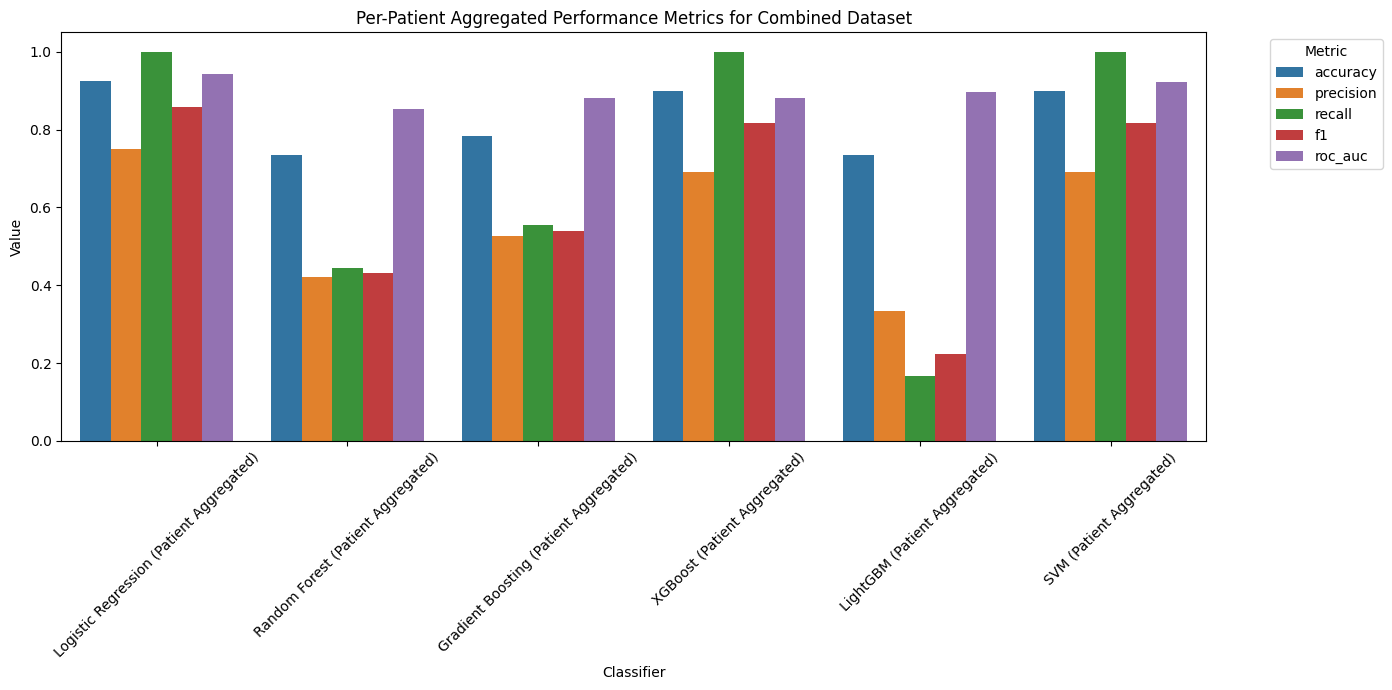

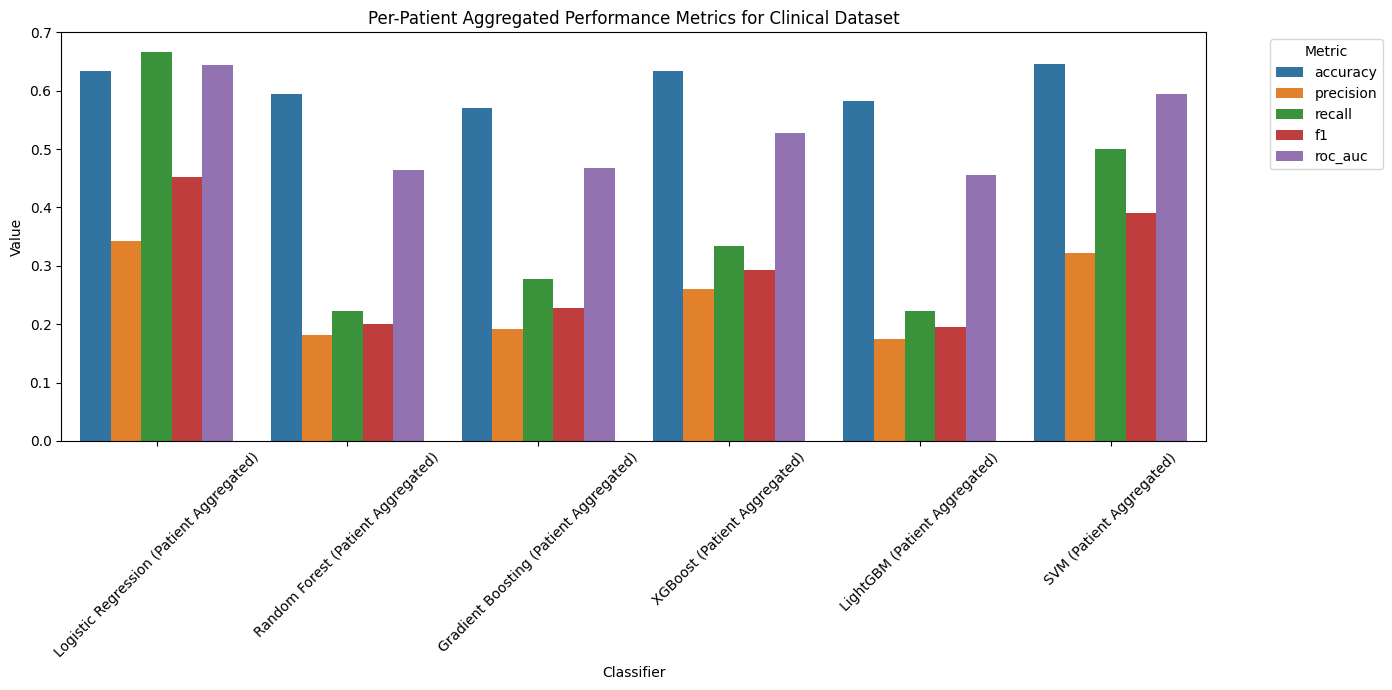

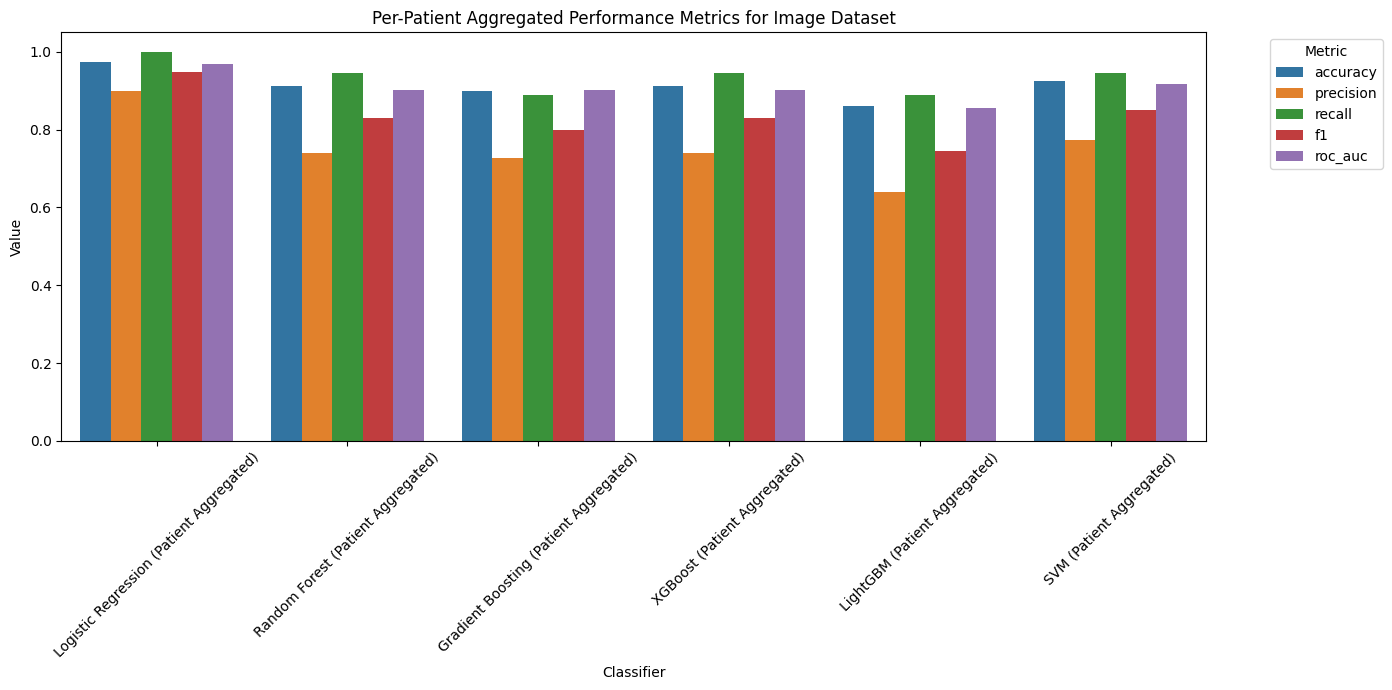

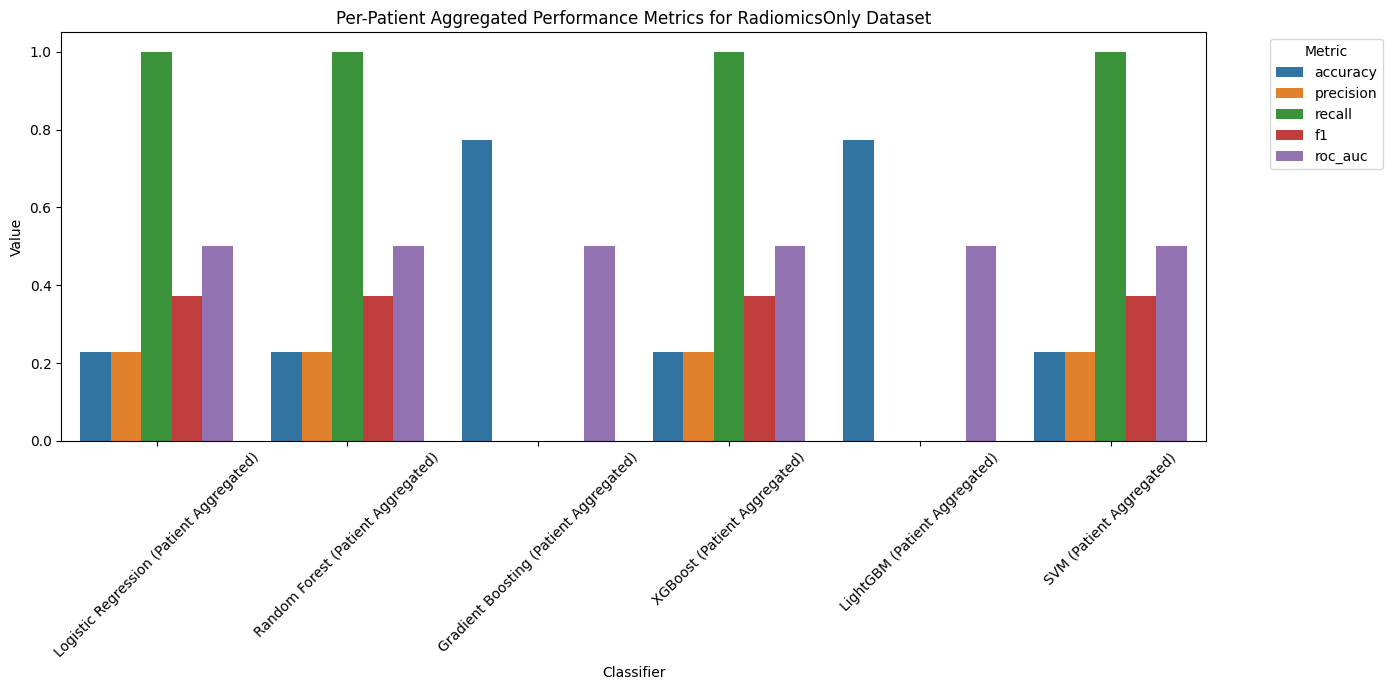

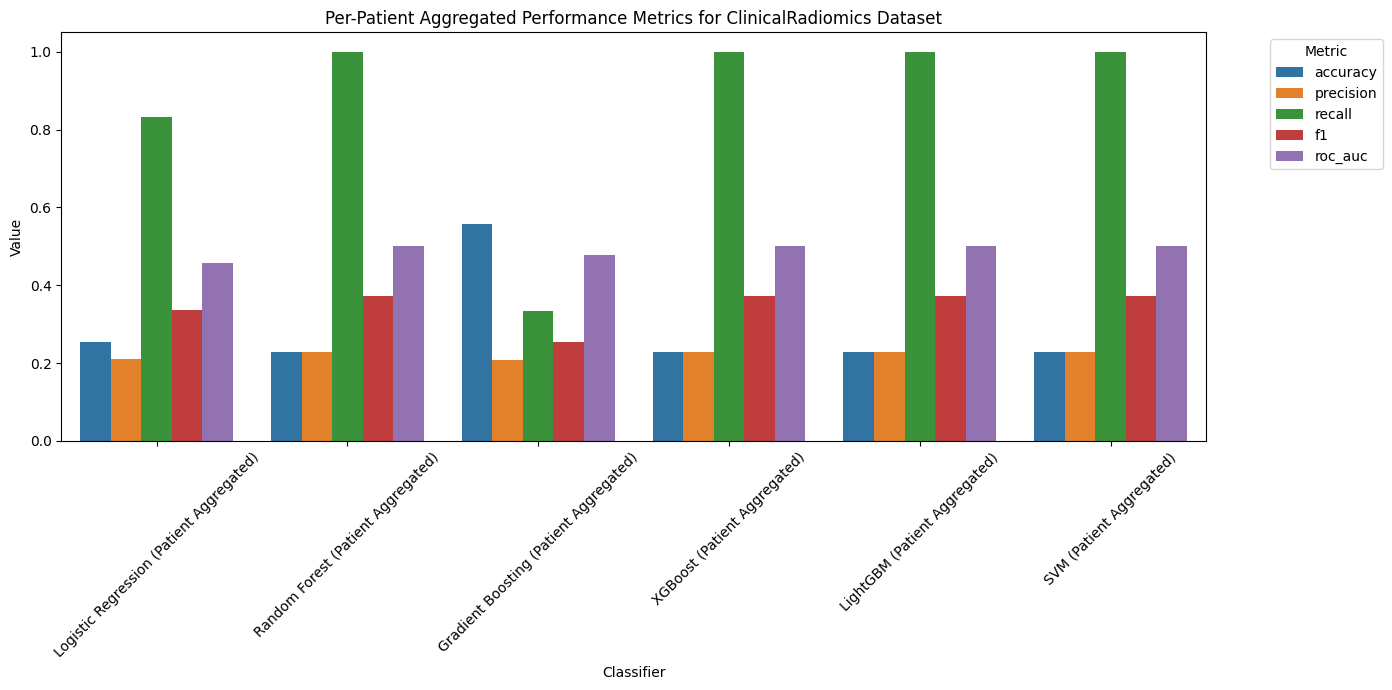

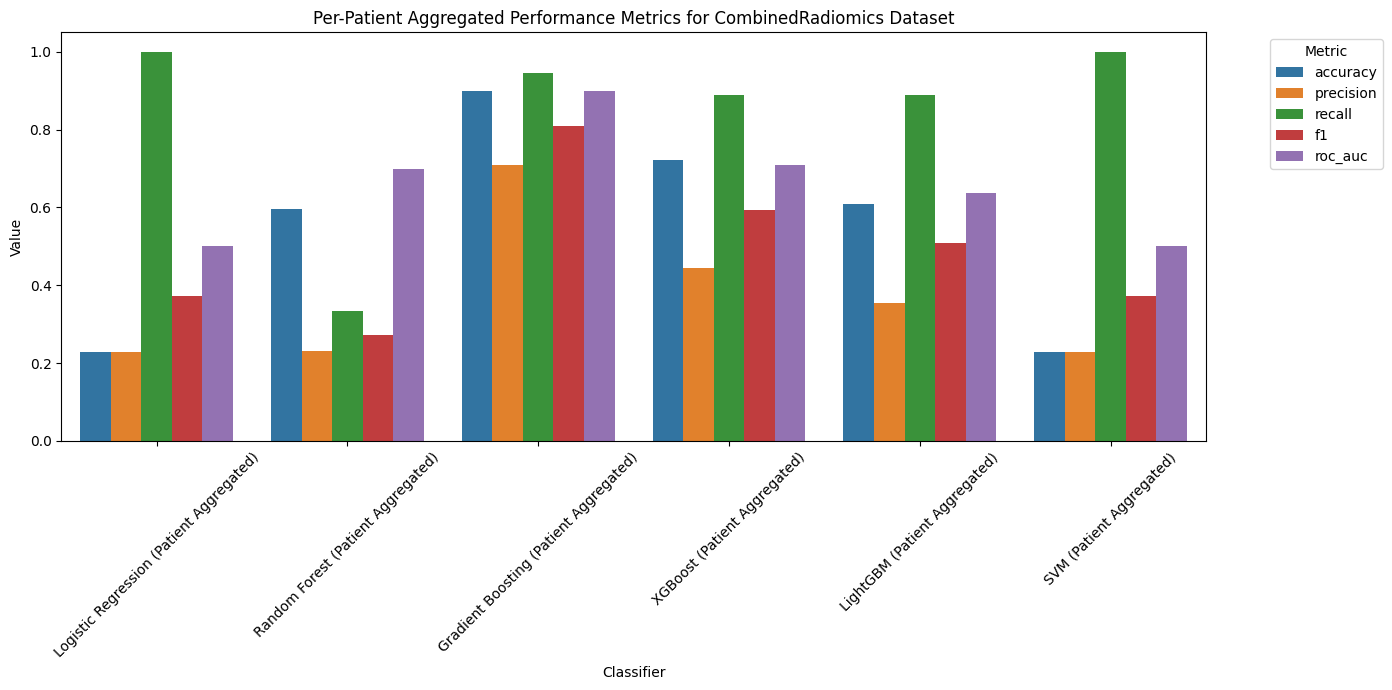

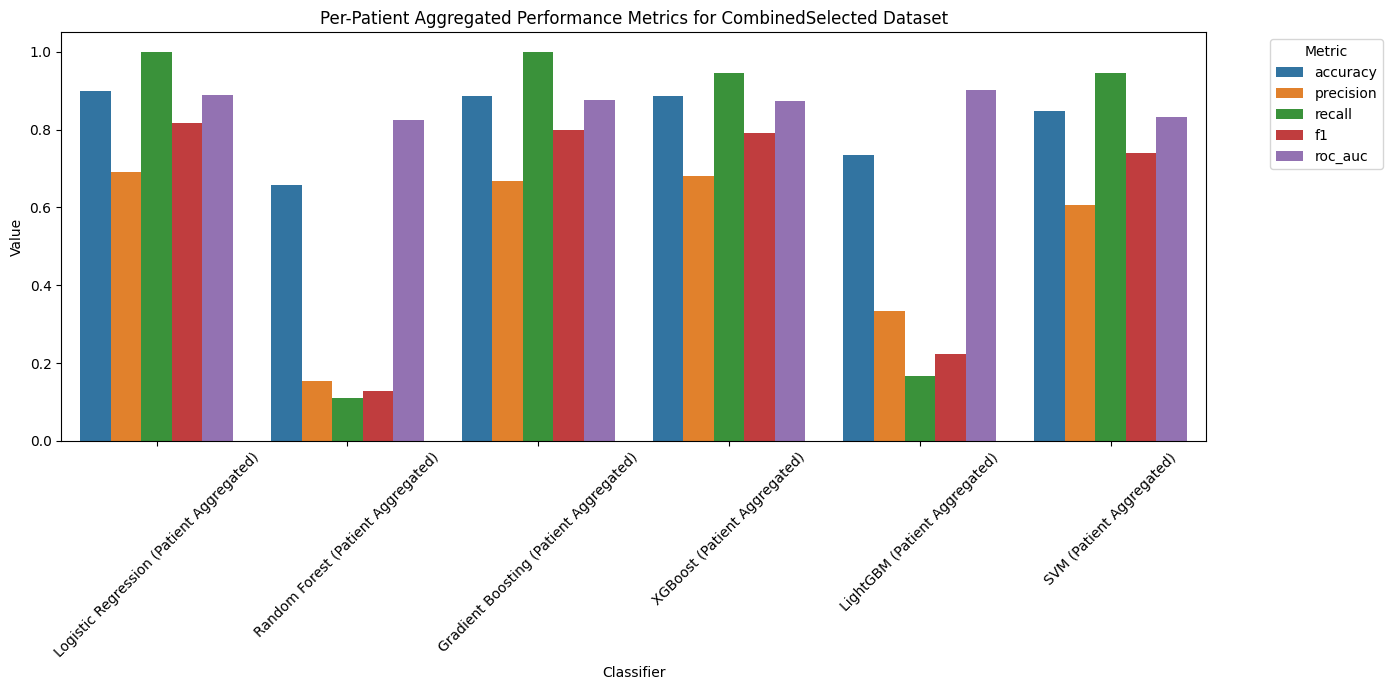

In [20]:
# Visualize Per-Patient Performance Metrics

import matplotlib.pyplot as plt
import seaborn as sns

# Function to plot metrics for each classifier in a dataset
def plot_metrics(dataset_name, classifiers_results):
    metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    classifier_names = list(classifiers_results.keys())
    metric_values = {metric: [classifiers_results[clf][metric] for clf in classifier_names] for metric in metrics}
    
    df_metrics = pd.DataFrame(metric_values, index=classifier_names)
    df_metrics = df_metrics.reset_index().rename(columns={'index': 'Classifier'})
    
    df_melted = df_metrics.melt(id_vars='Classifier', var_name='Metric', value_name='Value')
    
    plt.figure(figsize=(14, 7))
    sns.barplot(x='Classifier', y='Value', hue='Metric', data=df_melted)
    plt.title(f'Per-Patient Aggregated Performance Metrics for {dataset_name} Dataset')
    plt.xticks(rotation=45)
    plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Plot metrics for each dataset
for dataset_name, classifiers_results in test_results_per_patient.items():
    plot_metrics(dataset_name, classifiers_results)


In [21]:
# Bootstrap Confidence Intervals for Test Metrics

import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Number of bootstrap iterations
n_bootstraps = 1000
rng = np.random.RandomState(seed=42)  # For reproducibility

# Initialize a dictionary to store bootstrap results
bootstrap_results = {}

for dataset_name in data_splits.keys():
    print(f"\nBootstrapping Test Metrics for '{dataset_name}' Dataset")
    
    # Retrieve data splits for the current dataset
    data = data_splits[dataset_name]
    X_test_full = data['X_test_full']
    y_test = data['y_test'].reset_index(drop=True)
    
    # Initialize dictionary for classifiers
    bootstrap_results[dataset_name] = {}
    
    for classifier_name in classifiers.keys():
        print(f"\nClassifier: {classifier_name}")
        
        # Retrieve the best hyperparameters from nested_cv_results
        nested_results = nested_cv_results[dataset_name]
        cv_results_all = nested_results['cv_results_all']
        cv_results = cv_results_all[classifier_name]
        
        # Find the hyperparameters with the best mean_test_score
        max_mean_test_score = cv_results['mean_test_score'].max()
        best_rows = cv_results[cv_results['mean_test_score'] == max_mean_test_score]
        
        # If multiple rows have the same max score, pick the first one
        best_row = best_rows.iloc[0]
        
        # Extract the best hyperparameters from the pipeline parameters
        best_params = best_row['params']
        
        # The params are for the entire pipeline; extract classifier's hyperparameters
        classifier_params = {}
        for param_name, param_value in best_params.items():
            if param_name.startswith('classifier__'):
                # Remove 'classifier__' prefix to get the parameter name
                param_short = param_name.replace('classifier__', '')
                classifier_params[param_short] = param_value
        
        # Get the default classifier with default parameters
        default_classifier = classifiers[classifier_name]
        
        # Clone the default classifier to avoid modifying the original
        classifier = clone(default_classifier)
        
        # Update the classifier's parameters with the best hyperparameters
        classifier.set_params(**classifier_params)
        
        # **Compute scale_pos_weight for XGBoost and LightGBM**
        if classifier_name == 'XGBoost' or classifier_name == 'LightGBM':
            scale_pos_weight = (y_train_full == 0).sum() / (y_train_full == 1).sum()
            print(f"Computed scale_pos_weight: {scale_pos_weight:.4f} for {classifier_name}")
            classifier.set_params(scale_pos_weight=scale_pos_weight)

        # Handle compatibility between solver and penalty for Logistic Regression
        if classifier_name == 'Logistic Regression':
            penalty = classifier.get_params().get('penalty', 'l2')
            solver = classifier.get_params().get('solver', 'lbfgs')
            if penalty == 'l1' and solver not in ['liblinear', 'saga']:
                # Change solver to 'liblinear' if penalty is 'l1'
                classifier.set_params(solver='liblinear')
                print(f"Adjusted solver to 'liblinear' for 'l1' penalty.")
            elif penalty == 'elasticnet' and solver != 'saga':
                # 'elasticnet' penalty requires 'saga' solver
                classifier.set_params(solver='saga')
                print(f"Adjusted solver to 'saga' for 'elasticnet' penalty.")
            elif penalty == 'l2' and solver == 'liblinear' and classifier.get_params().get('dual', False):
                # Dual formulation is only implemented for l2 penalty with liblinear solver
                classifier.set_params(dual=True)
            else:
                # Ensure dual is False for other solvers
                classifier.set_params(dual=False)
        
        # Retrieve training data
        X_train_full = data['X_train_full']
        y_train_full = data['y_train_full']
        
        # Apply SMOTE to training data only
        #print("\nApplying SMOTE to balance the classes in the training data...")
        #smote = SMOTE(random_state=42)
        #X_train_resampled, y_train_resampled = smote.fit_resample(X_train_full, y_train_full)
        
        # Define the pipeline without SMOTE
        pipeline = Pipeline(steps=[
            ('scaler', MinMaxScaler()),
            ('classifier', classifier)
        ])
        
        # Fit the pipeline on the entire training set
        pipeline.fit(X_train_full, y_train_full)
        
        # Initialize lists to store bootstrap metrics
        bootstrap_accuracies = []
        bootstrap_precisions = []
        bootstrap_recalls = []
        bootstrap_f1s = []
        bootstrap_roc_aucs = []
        
        # Convert y_test to numpy array
        y_test_array = y_test.values
        
        # Compute predicted probabilities once (since the model is fixed)
        if hasattr(pipeline.named_steps['classifier'], "predict_proba"):
            y_proba_full = pipeline.predict_proba(X_test_full)[:, 1]
        else:
            # For classifiers that do not have predict_proba, skip ROC AUC
            y_proba_full = None
        
        # Perform bootstrap resampling
        for i in range(n_bootstraps):
            # Sample indices with replacement
            indices = rng.choice(len(X_test_full), size=len(X_test_full), replace=True)
            X_test_bootstrap = X_test_full.iloc[indices]
            y_test_bootstrap = y_test_array[indices]
            
            # Make predictions on the bootstrap sample
            y_pred_bootstrap = pipeline.predict(X_test_bootstrap)
            
            # Compute metrics
            accuracy = accuracy_score(y_test_bootstrap, y_pred_bootstrap)
            precision = precision_score(y_test_bootstrap, y_pred_bootstrap, zero_division=0)
            recall = recall_score(y_test_bootstrap, y_pred_bootstrap)
            f1 = f1_score(y_test_bootstrap, y_pred_bootstrap)
            if y_proba_full is not None:
                y_proba_bootstrap = y_proba_full[indices]
                roc_auc = roc_auc_score(y_test_bootstrap, y_proba_bootstrap)
            else:
                roc_auc = np.nan  # Not available for this classifier
                
            # Append metrics
            bootstrap_accuracies.append(accuracy)
            bootstrap_precisions.append(precision)
            bootstrap_recalls.append(recall)
            bootstrap_f1s.append(f1)
            bootstrap_roc_aucs.append(roc_auc)
        
        # Compute confidence intervals (e.g., 95% CI)
        def compute_confidence_interval(metric_values):
            sorted_values = np.sort(metric_values)
            lower = np.percentile(sorted_values, 2.5)
            upper = np.percentile(sorted_values, 97.5)
            mean = np.mean(metric_values)
            return mean, lower, upper
        
        accuracy_mean, accuracy_lower, accuracy_upper = compute_confidence_interval(bootstrap_accuracies)
        precision_mean, precision_lower, precision_upper = compute_confidence_interval(bootstrap_precisions)
        recall_mean, recall_lower, recall_upper = compute_confidence_interval(bootstrap_recalls)
        f1_mean, f1_lower, f1_upper = compute_confidence_interval(bootstrap_f1s)
        roc_auc_mean, roc_auc_lower, roc_auc_upper = compute_confidence_interval(bootstrap_roc_aucs)
        
        # Store the bootstrap results
        bootstrap_results[dataset_name][classifier_name] = {
            'accuracy': (accuracy_mean, accuracy_lower, accuracy_upper),
            'precision': (precision_mean, precision_lower, precision_upper),
            'recall': (recall_mean, recall_lower, recall_upper),
            'f1': (f1_mean, f1_lower, f1_upper),
            'roc_auc': (roc_auc_mean, roc_auc_lower, roc_auc_upper),
        }
        
        # Print the results
        print(f"{classifier_name} Bootstrap Confidence Intervals:")
        print(f"Accuracy: {accuracy_mean:.4f} (95% CI: {accuracy_lower:.4f} - {accuracy_upper:.4f})")
        print(f"Precision: {precision_mean:.4f} (95% CI: {precision_lower:.4f} - {precision_upper:.4f})")
        print(f"Recall: {recall_mean:.4f} (95% CI: {recall_lower:.4f} - {recall_upper:.4f})")
        print(f"F1 Score: {f1_mean:.4f} (95% CI: {f1_lower:.4f} - {f1_upper:.4f})")
        if not np.isnan(roc_auc_mean):
            print(f"ROC AUC: {roc_auc_mean:.4f} (95% CI: {roc_auc_lower:.4f} - {roc_auc_upper:.4f})")
        else:
            print("ROC AUC: Not available for this classifier")



Bootstrapping Test Metrics for 'Combined' Dataset

Classifier: Logistic Regression
Logistic Regression Bootstrap Confidence Intervals:
Accuracy: 0.8169 (95% CI: 0.7960 - 0.8377)
Precision: 0.8570 (95% CI: 0.8321 - 0.8813)
Recall: 0.7952 (95% CI: 0.7669 - 0.8239)
F1 Score: 0.8248 (95% CI: 0.8035 - 0.8454)
ROC AUC: 0.8967 (95% CI: 0.8807 - 0.9135)

Classifier: Random Forest
Random Forest Bootstrap Confidence Intervals:
Accuracy: 0.8105 (95% CI: 0.7893 - 0.8317)
Precision: 0.8540 (95% CI: 0.8270 - 0.8813)
Recall: 0.7847 (95% CI: 0.7549 - 0.8128)
F1 Score: 0.8178 (95% CI: 0.7959 - 0.8390)
ROC AUC: 0.8798 (95% CI: 0.8615 - 0.8984)

Classifier: Gradient Boosting
Gradient Boosting Bootstrap Confidence Intervals:
Accuracy: 0.8067 (95% CI: 0.7863 - 0.8273)
Precision: 0.8365 (95% CI: 0.8094 - 0.8620)
Recall: 0.7999 (95% CI: 0.7700 - 0.8293)
F1 Score: 0.8177 (95% CI: 0.7949 - 0.8385)
ROC AUC: 0.8846 (95% CI: 0.8663 - 0.9017)

Classifier: XGBoost
Computed scale_pos_weight: 0.8441 for XGBoost
XGBo

In [22]:
# Bootstrap Confidence Intervals with Patient-Level and Slice-Level Thresholding

import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, classification_report
)
from sklearn.base import clone

# Number of bootstrap iterations
n_bootstraps = 1000
rng = np.random.RandomState(seed=42)  # For reproducibility

# Initialize a dictionary to store bootstrap results
bootstrap_results_per_patient = {}

for dataset_name in data_splits.keys():
    print(f"\nBootstrapping Test Metrics for '{dataset_name}' Dataset")
    
    # Retrieve data splits for the current dataset
    data = data_splits[dataset_name]
    X_test_full = data['X_test_full'].reset_index(drop=True)
    y_test = data['y_test'].reset_index(drop=True)
    patient_ids_test = data['patient_ids_test'].reset_index(drop=True)
    
    # Combine test data into a single DataFrame
    test_df = X_test_full.copy()
    test_df['y_true'] = y_test
    test_df['patient_id'] = patient_ids_test
    
    # Get unique patient IDs
    unique_patient_ids = test_df['patient_id'].unique()
    
    # Initialize dictionary for classifiers
    bootstrap_results_per_patient[dataset_name] = {}
    
    for classifier_name in classifiers.keys():
        print(f"\nClassifier: {classifier_name}")
        
        # Retrieve the best hyperparameters from nested_cv_results
        nested_results = nested_cv_results[dataset_name]
        cv_results_all = nested_results['cv_results_all']
        cv_results = cv_results_all[classifier_name]
        
        # Find the hyperparameters with the best mean_test_score
        max_mean_test_score = cv_results['mean_test_score'].max()
        best_rows = cv_results[cv_results['mean_test_score'] == max_mean_test_score]
        
        # If multiple rows have the same max score, pick the first one
        best_row = best_rows.iloc[0]
        
        # Extract the best hyperparameters from the pipeline parameters
        best_params = best_row['params']
        
        # The params are for the entire pipeline; extract classifier's hyperparameters
        classifier_params = {}
        for param_name, param_value in best_params.items():
            if param_name.startswith('classifier__'):
                # Remove 'classifier__' prefix to get the parameter name
                param_short = param_name.replace('classifier__', '')
                classifier_params[param_short] = param_value
        
        # Get the default classifier with default parameters
        default_classifier = classifiers[classifier_name]
        
        # Clone the default classifier to avoid modifying the original
        classifier = clone(default_classifier)
        
        # Update the classifier's parameters with the best hyperparameters
        classifier.set_params(**classifier_params)

        # **Compute scale_pos_weight for XGBoost and LightGBM**
        if classifier_name == 'XGBoost' or classifier_name == 'LightGBM':
            scale_pos_weight = (y_train_full == 0).sum() / (y_train_full == 1).sum()
            print(f"Computed scale_pos_weight: {scale_pos_weight:.4f} for {classifier_name}")
            classifier.set_params(scale_pos_weight=scale_pos_weight)
        
        # Handle compatibility between solver and penalty for Logistic Regression
        if classifier_name == 'Logistic Regression':
            penalty = classifier.get_params().get('penalty', 'l2')
            solver = classifier.get_params().get('solver', 'lbfgs')
            if penalty == 'l1' and solver not in ['liblinear', 'saga']:
                # Change solver to 'liblinear' if penalty is 'l1'
                classifier.set_params(solver='liblinear')
                print(f"Adjusted solver to 'liblinear' for 'l1' penalty.")
            elif penalty == 'elasticnet' and solver != 'saga':
                # 'elasticnet' penalty requires 'saga' solver
                classifier.set_params(solver='saga')
                print(f"Adjusted solver to 'saga' for 'elasticnet' penalty.")
            elif penalty == 'l2' and solver == 'liblinear' and classifier.get_params().get('dual', False):
                # Dual formulation is only implemented for l2 penalty with liblinear solver
                classifier.set_params(dual=True)
            else:
                # Ensure dual is False for other solvers
                classifier.set_params(dual=False)
        
        # Retrieve training data
        X_train_full = data['X_train_full']
        y_train_full = data['y_train_full']
        
        # Apply SMOTE to training data only
        #print("\nApplying SMOTE to balance the classes in the training data...")
        #smote = SMOTE(random_state=42)
        #X_train_resampled, y_train_resampled = smote.fit_resample(X_train_full, y_train_full)
        
        # Define the pipeline without SMOTE
        pipeline = Pipeline(steps=[
            ('scaler', MinMaxScaler()),
            ('classifier', classifier)
        ])
        
        # Fit the pipeline on the entire training set
        pipeline.fit(X_train_full, y_train_full)
        
        # Compute predicted probabilities on the full test set
        if hasattr(pipeline.named_steps['classifier'], "predict_proba"):
            y_proba_full = pipeline.predict_proba(X_test_full)[:, 1]
        else:
            print(f"Classifier '{classifier_name}' does not support probability estimates. Skipping.")
            continue
        
        # Add predicted probabilities to test_df
        test_df['y_proba'] = y_proba_full
        
        # Initialize lists to store bootstrap metrics
        bootstrap_accuracies = []
        bootstrap_precisions = []
        bootstrap_recalls = []
        bootstrap_f1s = []
        bootstrap_roc_aucs = []

        # Compute predicted probabilities on training data
        y_proba_train = pipeline.predict_proba(X_train_full)[:, 1]
        
        # Create train_df similar to test_df
        train_df = X_train_full.copy()
        train_df['y_true'] = y_train_full.values
        
        # Number of original samples before SMOTE
        n_original_samples = len(X_train_full)
        
        # Assign patient IDs to original samples
        train_df.loc[:n_original_samples - 1, 'patient_id'] = data['patient_ids_train'].values
        
        # Number of synthetic samples added by SMOTE
        n_synthetic_samples = len(X_train_full) - n_original_samples
        
        # Identify the minority class in the original training data
        minority_class = y_train_full.value_counts().idxmin()
        
        # Get indices and patient IDs of minority class samples
        minority_indices = y_train_full[y_train_full == minority_class].index
        minority_patient_ids = data['patient_ids_train'].loc[minority_indices].values
        
        # Randomly assign patient IDs from minority class to synthetic samples
        synthetic_patient_ids = np.random.choice(
            minority_patient_ids, size=n_synthetic_samples, replace=True
        )
        
        # Assign patient IDs to synthetic samples
        train_df.loc[n_original_samples:, 'patient_id'] = synthetic_patient_ids
        
        # Ensure the 'patient_id' column is of the correct data type
        train_df['patient_id'] = train_df['patient_id'].astype(data['patient_ids_train'].dtype)



        train_df['y_proba'] = y_proba_train
        
        # Compute optimal slice_threshold using training data
        slice_threshold = find_optimal_threshold(train_df['y_true'], train_df['y_proba'])
        print(f"Optimal Slice Threshold (Youden's J) from training data: {slice_threshold:.4f}")
        
        # Assign per-slice predictions on training data
        train_df['y_pred_slice'] = (train_df['y_proba'] >= slice_threshold).astype(int)
        
        # Aggregate predictions per patient in training data
        slice_proportions_train = train_df.groupby('patient_id')['y_pred_slice'].mean()
        y_true_per_patient_train = train_df.groupby('patient_id')['y_true'].first()
        
        # Compute patient_threshold using training data
        patient_threshold = find_optimal_threshold(y_true_per_patient_train, slice_proportions_train)
        print(f"Optimal Patient Threshold (Youden's J) from training data: {patient_threshold:.4f}")

        
        # Perform bootstrap resampling
        for i in range(n_bootstraps):
            # Sample patient IDs with replacement
            sampled_patient_ids = rng.choice(unique_patient_ids, size=len(unique_patient_ids), replace=True)
            
            # Get the indices of the slices corresponding to the sampled patient IDs
            sampled_indices = test_df[test_df['patient_id'].isin(sampled_patient_ids)].index
            
            # Create bootstrap sample
            test_df_bootstrap = test_df.loc[sampled_indices].reset_index(drop=True)
            
            # Get true labels and predicted probabilities
            y_true_bootstrap = test_df_bootstrap['y_true']
            y_proba_bootstrap = test_df_bootstrap['y_proba']
            
            # Use the thresholds computed from training data
            # Apply optimal slice threshold
            test_df_bootstrap['y_pred_slice'] = (test_df_bootstrap['y_proba'] >= slice_threshold).astype(int)

            # Aggregate predictions per patient
            slice_proportions = test_df_bootstrap.groupby('patient_id')['y_pred_slice'].mean()
            y_true_per_patient_bootstrap = test_df_bootstrap.groupby('patient_id')['y_true'].first()

            # Apply optimal patient threshold
            y_pred_per_patient_bootstrap = (slice_proportions >= patient_threshold).astype(int)

            # Compute performance metrics at the patient level
            accuracy = accuracy_score(y_true_per_patient_bootstrap, y_pred_per_patient_bootstrap)
            precision = precision_score(y_true_per_patient_bootstrap, y_pred_per_patient_bootstrap, zero_division=0)
            recall = recall_score(y_true_per_patient_bootstrap, y_pred_per_patient_bootstrap)
            f1 = f1_score(y_true_per_patient_bootstrap, y_pred_per_patient_bootstrap)
            roc_auc = roc_auc_score(y_true_per_patient_bootstrap, slice_proportions)
            
            # Append metrics
            bootstrap_accuracies.append(accuracy)
            bootstrap_precisions.append(precision)
            bootstrap_recalls.append(recall)
            bootstrap_f1s.append(f1)
            bootstrap_roc_aucs.append(roc_auc)
        
        # Compute confidence intervals (e.g., 95% CI)
        def compute_confidence_interval(metric_values):
            sorted_values = np.sort(metric_values)
            lower = np.percentile(sorted_values, 2.5)
            upper = np.percentile(sorted_values, 97.5)
            mean = np.mean(metric_values)
            return mean, lower, upper
        
        accuracy_mean, accuracy_lower, accuracy_upper = compute_confidence_interval(bootstrap_accuracies)
        precision_mean, precision_lower, precision_upper = compute_confidence_interval(bootstrap_precisions)
        recall_mean, recall_lower, recall_upper = compute_confidence_interval(bootstrap_recalls)
        f1_mean, f1_lower, f1_upper = compute_confidence_interval(bootstrap_f1s)
        roc_auc_mean, roc_auc_lower, roc_auc_upper = compute_confidence_interval(bootstrap_roc_aucs)
        
        # Store the bootstrap results
        bootstrap_results_per_patient[dataset_name][classifier_name] = {
            'accuracy': (accuracy_mean, accuracy_lower, accuracy_upper),
            'precision': (precision_mean, precision_lower, precision_upper),
            'recall': (recall_mean, recall_lower, recall_upper),
            'f1': (f1_mean, f1_lower, f1_upper),
            'roc_auc': (roc_auc_mean, roc_auc_lower, roc_auc_upper),
        }
        
        # Print the results
        print(f"\n{classifier_name} Bootstrap Confidence Intervals (Patient-Level):")
        print(f"Accuracy: {accuracy_mean:.4f} (95% CI: {accuracy_lower:.4f} - {accuracy_upper:.4f})")
        print(f"Precision: {precision_mean:.4f} (95% CI: {precision_lower:.4f} - {precision_upper:.4f})")
        print(f"Recall: {recall_mean:.4f} (95% CI: {recall_lower:.4f} - {recall_upper:.4f})")
        print(f"F1 Score: {f1_mean:.4f} (95% CI: {f1_lower:.4f} - {f1_upper:.4f})")
        print(f"ROC AUC: {roc_auc_mean:.4f} (95% CI: {roc_auc_lower:.4f} - {roc_auc_upper:.4f})")



Bootstrapping Test Metrics for 'Combined' Dataset

Classifier: Logistic Regression
Optimal Slice Threshold (Youden's J) from training data: 0.5858
Optimal Patient Threshold (Youden's J) from training data: 0.5750

Logistic Regression Bootstrap Confidence Intervals (Patient-Level):
Accuracy: 0.9235 (95% CI: 0.8824 - 0.9640)
Precision: 0.7481 (95% CI: 0.6248 - 0.8949)
Recall: 1.0000 (95% CI: 1.0000 - 1.0000)
F1 Score: 0.8541 (95% CI: 0.7690 - 0.9445)
ROC AUC: 0.9412 (95% CI: 0.9016 - 0.9823)

Classifier: Random Forest
Optimal Slice Threshold (Youden's J) from training data: 0.3135
Optimal Patient Threshold (Youden's J) from training data: 0.8000

Random Forest Bootstrap Confidence Intervals (Patient-Level):
Accuracy: 0.7340 (95% CI: 0.6604 - 0.8114)
Precision: 0.4222 (95% CI: 0.2500 - 0.6000)
Recall: 0.4448 (95% CI: 0.2727 - 0.6250)
F1 Score: 0.4291 (95% CI: 0.2727 - 0.5714)
ROC AUC: 0.8526 (95% CI: 0.7887 - 0.9187)

Classifier: Gradient Boosting
Optimal Slice Threshold (Youden's J) fro

In [23]:
# Prepare the base classifiers with their best hyperparameters
# Import necessary libraries
from sklearn.ensemble import StackingClassifier, VotingClassifier
from sklearn.base import clone
# Prepare the base classifiers with their best hyperparameters
def get_best_classifier(classifier_name, dataset_name):
    # Retrieve the best hyperparameters from nested_cv_results
    nested_results = nested_cv_results[dataset_name]
    cv_results_all = nested_results['cv_results_all']
    cv_results = cv_results_all[classifier_name]
    
    # Find the hyperparameters with the best mean_test_score
    max_mean_test_score = cv_results['mean_test_score'].max()
    best_rows = cv_results[cv_results['mean_test_score'] == max_mean_test_score]
    
    # If multiple rows have the same max score, pick the first one
    best_row = best_rows.iloc[0]
    
    # Extract the best hyperparameters from the pipeline parameters
    best_params = best_row['params']
    
    # The params are for the entire pipeline; extract classifier's hyperparameters
    classifier_params = {}
    for param_name, param_value in best_params.items():
        if param_name.startswith('classifier__'):
            # Remove 'classifier__' prefix to get the parameter name
            param_short = param_name.replace('classifier__', '')
            classifier_params[param_short] = param_value
    
    # Get the default classifier with default parameters
    default_classifier = classifiers[classifier_name]
    
    # Clone the default classifier to avoid modifying the original
    classifier = clone(default_classifier)
    
    # Update the classifier's parameters with the best hyperparameters
    classifier.set_params(**classifier_params)

    # **Compute scale_pos_weight for XGBoost and LightGBM**
    if classifier_name == 'XGBoost' or classifier_name == 'LightGBM':
        scale_pos_weight = (y_train_full == 0).sum() / (y_train_full == 1).sum()
        print(f"Computed scale_pos_weight: {scale_pos_weight:.4f} for {classifier_name}")
        classifier.set_params(scale_pos_weight=scale_pos_weight)
    
    # Handle compatibility between solver and penalty for Logistic Regression
    if classifier_name == 'Logistic Regression':
        penalty = classifier.get_params().get('penalty', 'l2')
        solver = classifier.get_params().get('solver', 'lbfgs')
        if penalty == 'l1' and solver not in ['liblinear', 'saga']:
            # Change solver to 'liblinear' if penalty is 'l1'
            classifier.set_params(solver='liblinear')
            print(f"Adjusted solver to 'liblinear' for 'l1' penalty.")
        elif penalty == 'elasticnet' and solver != 'saga':
            # 'elasticnet' penalty requires 'saga' solver
            classifier.set_params(solver='saga')
            print(f"Adjusted solver to 'saga' for 'elasticnet' penalty.")
        elif penalty == 'l2' and solver == 'liblinear' and classifier.get_params().get('dual', False):
            # Dual formulation is only implemented for l2 penalty with liblinear solver
            classifier.set_params(dual=True)
        else:
            # Ensure dual is False for other solvers
            classifier.set_params(dual=False)
    return classifier


In [24]:
# Function: Create the ensemble classifiers
def create_ensemble_classifiers(dataset_name):
    # Prepare base classifiers
    base_classifiers = []
    classifier_names = ['Logistic Regression', 'Random Forest', 'XGBoost', 'LightGBM']
    
    for clf_name in classifier_names:
        clf = get_best_classifier(clf_name, dataset_name)
        base_classifiers.append((clf_name.lower().replace(' ', '_'), clf))
    
    # Create the stacking classifier
    stacking_classifier = StackingClassifier(
        estimators=base_classifiers,
        final_estimator=LogisticRegression(random_state=42),
        passthrough=False,
        cv=5,
        n_jobs=-1
    )
    
    # Create the voting classifier
    voting_classifier = VotingClassifier(
        estimators=base_classifiers,
        voting='soft',  # Use 'hard' for majority voting
        n_jobs=-1
    )
    
    return stacking_classifier, voting_classifier

In [25]:
# Retrain and test on Ensemble Classifiers
test_results_ensemble = {}

for dataset_name in data_splits.keys():
    print(f"\nEvaluating Ensemble Classifiers on '{dataset_name}' Dataset")
    
    # Retrieve data splits for the current dataset
    data = data_splits[dataset_name]
    X_train_full = data['X_train_full']
    y_train_full = data['y_train_full']
    X_test_full = data['X_test_full']
    y_test = data['y_test']
    patient_ids_test = data['patient_ids_test'].reset_index(drop=True)
    
    # Create a DataFrame for test data
    test_df = X_test_full.copy()
    test_df['y_true'] = y_test.values
    test_df['patient_id'] = patient_ids_test.values
    
    # Get per-patient true labels (assuming all slices of a patient have the same label)
    y_true_per_patient = test_df.groupby('patient_id')['y_true'].first()
    
    # Create ensemble classifiers
    stacking_classifier, voting_classifier = create_ensemble_classifiers(dataset_name)
    
    ensemble_classifiers = {
        'Stacking Classifier': stacking_classifier,
        'Voting Classifier': voting_classifier
    }
    
    for ensemble_name, ensemble_clf in ensemble_classifiers.items():
        print(f"\nClassifier: {ensemble_name}")
        
        # Handle classifiers that do not support predict
        if not hasattr(ensemble_clf, "predict"):
            print(f"Classifier '{ensemble_name}' does not support predict method. Skipping.")
            continue
        
        # Apply SMOTE to training data only
        print("\nApplying SMOTE to balance the classes in the training data...")
        smote = SMOTE(random_state=42)
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train_full, y_train_full)
        
        # Define the pipeline without SMOTE
        pipeline = Pipeline(steps=[
            ('scaler', MinMaxScaler()),
            ('classifier', ensemble_clf)
        ])
        
        # Fit the pipeline on the entire training set
        pipeline.fit(X_train_resampled, y_train_resampled)
        
        # Predict per-slice labels on the test set using the model's default threshold
        y_pred_slice = pipeline.predict(X_test_full)
        
        # Add per-slice predictions to test_df
        test_df[f'{ensemble_name}_pred_slice'] = y_pred_slice
        
        # Aggregate per-slice predictions per patient using majority vote
        y_pred_per_patient = test_df.groupby('patient_id')[f'{ensemble_name}_pred_slice'].agg(lambda x: x.value_counts().idxmax())
        
        # Align the true labels
        y_true = y_true_per_patient.loc[y_pred_per_patient.index]
        
        # Compute performance metrics
        accuracy = accuracy_score(y_true, y_pred_per_patient)
        precision = precision_score(y_true, y_pred_per_patient, zero_division=0)
        recall = recall_score(y_true, y_pred_per_patient)
        f1 = f1_score(y_true, y_pred_per_patient)
        try:
            roc_auc = roc_auc_score(y_true, y_pred_per_patient)
        except ValueError:
            roc_auc = None  # Handle cases where ROC AUC is not defined
        
        conf_matrix = confusion_matrix(y_true, y_pred_per_patient)
        class_report = classification_report(y_true, y_pred_per_patient, zero_division=0)
        
        # Store the results
        test_results_ensemble[dataset_name] = test_results_ensemble.get(dataset_name, {})
        test_results_ensemble[dataset_name][ensemble_name + ' (Patient Aggregated)'] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'roc_auc': roc_auc,
            'confusion_matrix': conf_matrix,
            'classification_report': class_report
        }
        
        # Print the results
        print(f"\nAggregated Test Results for {ensemble_name} on {dataset_name} Dataset:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
        if roc_auc is not None:
            print(f"ROC AUC Score: {roc_auc:.4f}")
        print("Confusion Matrix:")
        print(conf_matrix)
        print("Classification Report:")
        print(class_report)



Evaluating Ensemble Classifiers on 'Combined' Dataset
Computed scale_pos_weight: 0.8441 for XGBoost
Computed scale_pos_weight: 0.8441 for LightGBM

Classifier: Stacking Classifier

Applying SMOTE to balance the classes in the training data...


/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:52:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[11:52:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[11:52:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[11:52:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[11:52:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[11:52:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




Aggregated Test Results for Stacking Classifier on Combined Dataset:
Accuracy: 0.8734
Precision: 0.6429
Recall: 1.0000
F1 Score: 0.7826
ROC AUC Score: 0.9180
Confusion Matrix:
[[51 10]
 [ 0 18]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.84      0.91        61
           1       0.64      1.00      0.78        18

    accuracy                           0.87        79
   macro avg       0.82      0.92      0.85        79
weighted avg       0.92      0.87      0.88        79


Classifier: Voting Classifier

Applying SMOTE to balance the classes in the training data...


/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:52:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Aggregated Test Results for Voting Classifier on Combined Dataset:
Accuracy: 0.8861
Precision: 0.6667
Recall: 1.0000
F1 Score: 0.8000
ROC AUC Score: 0.9262
Confusion Matrix:
[[52  9]
 [ 0 18]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.85      0.92        61
           1       0.67      1.00      0.80        18

    accuracy                           0.89        79
   macro avg       0.83      0.93      0.86        79
weighted avg       0.92      0.89      0.89        79


Evaluating Ensemble Classifiers on 'Clinical' Dataset
Computed scale_pos_weight: 3.3571 for XGBoost
Computed scale_pos_weight: 3.3571 for LightGBM

Classifier: Stacking Classifier

Applying SMOTE to balance the classes in the training data...


/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:52:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[11:52:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[11:52:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[11:52:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[11:52:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[11:52:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




Aggregated Test Results for Stacking Classifier on Clinical Dataset:
Accuracy: 0.5949
Precision: 0.1818
Recall: 0.2222
F1 Score: 0.2000
ROC AUC Score: 0.4636
Confusion Matrix:
[[43 18]
 [14  4]]
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.70      0.73        61
           1       0.18      0.22      0.20        18

    accuracy                           0.59        79
   macro avg       0.47      0.46      0.46        79
weighted avg       0.62      0.59      0.61        79


Classifier: Voting Classifier

Applying SMOTE to balance the classes in the training data...


/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:52:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Aggregated Test Results for Voting Classifier on Clinical Dataset:
Accuracy: 0.6329
Precision: 0.3429
Recall: 0.6667
F1 Score: 0.4528
ROC AUC Score: 0.6448
Confusion Matrix:
[[38 23]
 [ 6 12]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.62      0.72        61
           1       0.34      0.67      0.45        18

    accuracy                           0.63        79
   macro avg       0.60      0.64      0.59        79
weighted avg       0.74      0.63      0.66        79


Evaluating Ensemble Classifiers on 'Image' Dataset
Computed scale_pos_weight: 0.8441 for XGBoost
Computed scale_pos_weight: 0.8441 for LightGBM

Classifier: Stacking Classifier

Applying SMOTE to balance the classes in the training data...


/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:52:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[11:52:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[11:52:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[11:52:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[11:52:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[11:52:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




Aggregated Test Results for Stacking Classifier on Image Dataset:
Accuracy: 0.8354
Precision: 0.5806
Recall: 1.0000
F1 Score: 0.7347
ROC AUC Score: 0.8934
Confusion Matrix:
[[48 13]
 [ 0 18]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.79      0.88        61
           1       0.58      1.00      0.73        18

    accuracy                           0.84        79
   macro avg       0.79      0.89      0.81        79
weighted avg       0.90      0.84      0.85        79


Classifier: Voting Classifier

Applying SMOTE to balance the classes in the training data...


/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:52:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Aggregated Test Results for Voting Classifier on Image Dataset:
Accuracy: 0.9367
Precision: 0.7826
Recall: 1.0000
F1 Score: 0.8780
ROC AUC Score: 0.9590
Confusion Matrix:
[[56  5]
 [ 0 18]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.92      0.96        61
           1       0.78      1.00      0.88        18

    accuracy                           0.94        79
   macro avg       0.89      0.96      0.92        79
weighted avg       0.95      0.94      0.94        79


Evaluating Ensemble Classifiers on 'RadiomicsOnly' Dataset
Computed scale_pos_weight: 3.2791 for XGBoost
Computed scale_pos_weight: 3.2791 for LightGBM

Classifier: Stacking Classifier

Applying SMOTE to balance the classes in the training data...


/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:52:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[11:52:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[11:52:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[11:52:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[11:52:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[11:52:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




Aggregated Test Results for Stacking Classifier on RadiomicsOnly Dataset:
Accuracy: 0.2278
Precision: 0.2278
Recall: 1.0000
F1 Score: 0.3711
ROC AUC Score: 0.5000
Confusion Matrix:
[[ 0 61]
 [ 0 18]]
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        61
           1       0.23      1.00      0.37        18

    accuracy                           0.23        79
   macro avg       0.11      0.50      0.19        79
weighted avg       0.05      0.23      0.08        79


Classifier: Voting Classifier

Applying SMOTE to balance the classes in the training data...


/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:52:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Aggregated Test Results for Voting Classifier on RadiomicsOnly Dataset:
Accuracy: 0.2278
Precision: 0.2278
Recall: 1.0000
F1 Score: 0.3711
ROC AUC Score: 0.5000
Confusion Matrix:
[[ 0 61]
 [ 0 18]]
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        61
           1       0.23      1.00      0.37        18

    accuracy                           0.23        79
   macro avg       0.11      0.50      0.19        79
weighted avg       0.05      0.23      0.08        79


Evaluating Ensemble Classifiers on 'ClinicalRadiomics' Dataset
Computed scale_pos_weight: 3.2791 for XGBoost
Computed scale_pos_weight: 3.2791 for LightGBM

Classifier: Stacking Classifier

Applying SMOTE to balance the classes in the training data...


/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:52:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[11:52:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[11:52:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[11:52:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[11:52:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[11:52:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




Aggregated Test Results for Stacking Classifier on ClinicalRadiomics Dataset:
Accuracy: 0.2658
Precision: 0.2143
Recall: 0.8333
F1 Score: 0.3409
ROC AUC Score: 0.4658
Confusion Matrix:
[[ 6 55]
 [ 3 15]]
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.10      0.17        61
           1       0.21      0.83      0.34        18

    accuracy                           0.27        79
   macro avg       0.44      0.47      0.26        79
weighted avg       0.56      0.27      0.21        79


Classifier: Voting Classifier

Applying SMOTE to balance the classes in the training data...


/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:52:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Aggregated Test Results for Voting Classifier on ClinicalRadiomics Dataset:
Accuracy: 0.2278
Precision: 0.2278
Recall: 1.0000
F1 Score: 0.3711
ROC AUC Score: 0.5000
Confusion Matrix:
[[ 0 61]
 [ 0 18]]
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        61
           1       0.23      1.00      0.37        18

    accuracy                           0.23        79
   macro avg       0.11      0.50      0.19        79
weighted avg       0.05      0.23      0.08        79


Evaluating Ensemble Classifiers on 'CombinedRadiomics' Dataset
Computed scale_pos_weight: 0.8441 for XGBoost
Computed scale_pos_weight: 0.8441 for LightGBM

Classifier: Stacking Classifier

Applying SMOTE to balance the classes in the training data...


/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:52:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[11:52:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[11:52:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[11:52:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[11:52:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[11:52:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




Aggregated Test Results for Stacking Classifier on CombinedRadiomics Dataset:
Accuracy: 0.7342
Precision: 0.4615
Recall: 1.0000
F1 Score: 0.6316
ROC AUC Score: 0.8279
Confusion Matrix:
[[40 21]
 [ 0 18]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.66      0.79        61
           1       0.46      1.00      0.63        18

    accuracy                           0.73        79
   macro avg       0.73      0.83      0.71        79
weighted avg       0.88      0.73      0.76        79


Classifier: Voting Classifier

Applying SMOTE to balance the classes in the training data...


/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:52:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Aggregated Test Results for Voting Classifier on CombinedRadiomics Dataset:
Accuracy: 0.4304
Precision: 0.2857
Recall: 1.0000
F1 Score: 0.4444
ROC AUC Score: 0.6311
Confusion Matrix:
[[16 45]
 [ 0 18]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.26      0.42        61
           1       0.29      1.00      0.44        18

    accuracy                           0.43        79
   macro avg       0.64      0.63      0.43        79
weighted avg       0.84      0.43      0.42        79


Evaluating Ensemble Classifiers on 'CombinedSelected' Dataset
Computed scale_pos_weight: 0.8401 for XGBoost
Computed scale_pos_weight: 0.8401 for LightGBM

Classifier: Stacking Classifier

Applying SMOTE to balance the classes in the training data...


/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:52:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[11:52:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[11:52:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[11:52:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[11:52:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[11:52:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




Aggregated Test Results for Stacking Classifier on CombinedSelected Dataset:
Accuracy: 0.8481
Precision: 0.6000
Recall: 1.0000
F1 Score: 0.7500
ROC AUC Score: 0.9016
Confusion Matrix:
[[49 12]
 [ 0 18]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.80      0.89        61
           1       0.60      1.00      0.75        18

    accuracy                           0.85        79
   macro avg       0.80      0.90      0.82        79
weighted avg       0.91      0.85      0.86        79


Classifier: Voting Classifier

Applying SMOTE to balance the classes in the training data...


/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:52:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Aggregated Test Results for Voting Classifier on CombinedSelected Dataset:
Accuracy: 0.8734
Precision: 0.6429
Recall: 1.0000
F1 Score: 0.7826
ROC AUC Score: 0.9180
Confusion Matrix:
[[51 10]
 [ 0 18]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.84      0.91        61
           1       0.64      1.00      0.78        18

    accuracy                           0.87        79
   macro avg       0.82      0.92      0.85        79
weighted avg       0.92      0.87      0.88        79



In [26]:
# Bootstrap Confidence Intervals for Ensemble Classifiers without Thresholding

import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Number of bootstrap iterations
n_bootstraps = 1000
rng = np.random.RandomState(seed=42)  # For reproducibility

# Initialize a dictionary to store bootstrap results
bootstrap_results_ensemble = {}

for dataset_name in data_splits.keys():
    print(f"\nBootstrapping Test Metrics for Ensemble Classifiers on '{dataset_name}' Dataset")
    
    # Retrieve data splits for the current dataset
    data = data_splits[dataset_name]
    X_test_full = data['X_test_full'].reset_index(drop=True)
    y_test = data['y_test'].reset_index(drop=True)
    patient_ids_test = data['patient_ids_test'].reset_index(drop=True)
    
    # Combine test data into a single DataFrame
    test_df = X_test_full.copy()
    test_df['y_true'] = y_test
    test_df['patient_id'] = patient_ids_test
    
    # Get unique patient IDs
    unique_patient_ids = test_df['patient_id'].unique()
    
    # Create ensemble classifiers
    stacking_classifier, voting_classifier = create_ensemble_classifiers(dataset_name)
    
    ensemble_classifiers = {
        'Stacking Classifier': stacking_classifier,
        'Voting Classifier': voting_classifier
    }
    
    for ensemble_name, ensemble_clf in ensemble_classifiers.items():
        print(f"\nClassifier: {ensemble_name}")
        
        # Handle classifiers that do not support predict_proba
        if not hasattr(ensemble_clf, "predict_proba"):
            print(f"Classifier '{ensemble_name}' does not support probability estimates. Skipping.")
            continue
        
        # Apply SMOTE to training data only
        print("\nApplying SMOTE to balance the classes in the training data...")
        smote = SMOTE(random_state=42)
        X_train_resampled, y_train_resampled = smote.fit_resample(data['X_train_full'], data['y_train_full'])
        
        # Define the pipeline without SMOTE
        pipeline = Pipeline(steps=[
            ('scaler', MinMaxScaler()),
            ('classifier', ensemble_clf)
        ])
        
        # Fit the pipeline on the entire training set
        pipeline.fit(X_train_resampled, y_train_resampled)
        
        # Compute predicted probabilities on the full test set
        y_proba_full = pipeline.predict_proba(X_test_full)[:, 1]
        
        # Add predicted probabilities to test_df
        test_df['y_proba'] = y_proba_full
        
        # Initialize lists to store bootstrap metrics
        bootstrap_accuracies = []
        bootstrap_precisions = []
        bootstrap_recalls = []
        bootstrap_f1s = []
        bootstrap_roc_aucs = []
        
        # Perform bootstrap resampling
        for i in range(n_bootstraps):
            # Sample patient IDs with replacement
            sampled_patient_ids = rng.choice(unique_patient_ids, size=len(unique_patient_ids), replace=True)
            
            # Get the indices of the slices corresponding to the sampled patient IDs
            sampled_indices = test_df[test_df['patient_id'].isin(sampled_patient_ids)].index
            
            # Create bootstrap sample
            test_df_bootstrap = test_df.loc[sampled_indices].reset_index(drop=True)
            
            # Get true labels and predicted probabilities
            y_true_bootstrap = test_df_bootstrap['y_true']
            y_proba_bootstrap = test_df_bootstrap['y_proba']
            
            # Use the model's default predictions for per-slice predictions
            X_test_bootstrap = test_df_bootstrap.drop(columns=['y_true', 'y_proba', 'patient_id'])
            test_df_bootstrap['y_pred_slice'] = pipeline.predict(X_test_bootstrap)
            
            # Aggregate per-slice predictions per patient using majority vote
            y_pred_per_patient_bootstrap = test_df_bootstrap.groupby('patient_id')['y_pred_slice'].agg(lambda x: x.value_counts().idxmax())
            y_true_per_patient_bootstrap = test_df_bootstrap.groupby('patient_id')['y_true'].first()
            
            # Optionally, compute per-patient probabilities for ROC AUC
            per_patient_proba = test_df_bootstrap.groupby('patient_id')['y_proba'].mean()
            
            # Compute performance metrics at the patient level
            accuracy = accuracy_score(y_true_per_patient_bootstrap, y_pred_per_patient_bootstrap)
            precision = precision_score(y_true_per_patient_bootstrap, y_pred_per_patient_bootstrap, zero_division=0)
            recall = recall_score(y_true_per_patient_bootstrap, y_pred_per_patient_bootstrap)
            f1 = f1_score(y_true_per_patient_bootstrap, y_pred_per_patient_bootstrap)
            roc_auc = roc_auc_score(y_true_per_patient_bootstrap, per_patient_proba)
            
            # Append metrics
            bootstrap_accuracies.append(accuracy)
            bootstrap_precisions.append(precision)
            bootstrap_recalls.append(recall)
            bootstrap_f1s.append(f1)
            bootstrap_roc_aucs.append(roc_auc)
        
        # Compute confidence intervals (e.g., 95% CI)
        def compute_confidence_interval(metric_values):
            sorted_values = np.sort(metric_values)
            lower = np.percentile(sorted_values, 2.5)
            upper = np.percentile(sorted_values, 97.5)
            mean = np.mean(metric_values)
            return mean, lower, upper
        
        accuracy_mean, accuracy_lower, accuracy_upper = compute_confidence_interval(bootstrap_accuracies)
        precision_mean, precision_lower, precision_upper = compute_confidence_interval(bootstrap_precisions)
        recall_mean, recall_lower, recall_upper = compute_confidence_interval(bootstrap_recalls)
        f1_mean, f1_lower, f1_upper = compute_confidence_interval(bootstrap_f1s)
        roc_auc_mean, roc_auc_lower, roc_auc_upper = compute_confidence_interval(bootstrap_roc_aucs)
        
        # Store the bootstrap results
        bootstrap_results_ensemble[dataset_name] = bootstrap_results_ensemble.get(dataset_name, {})
        bootstrap_results_ensemble[dataset_name][ensemble_name] = {
            'accuracy': (accuracy_mean, accuracy_lower, accuracy_upper),
            'precision': (precision_mean, precision_lower, precision_upper),
            'recall': (recall_mean, recall_lower, recall_upper),
            'f1': (f1_mean, f1_lower, f1_upper),
            'roc_auc': (roc_auc_mean, roc_auc_lower, roc_auc_upper),
        }
        
        # Print the results
        print(f"\n{ensemble_name} Bootstrap Confidence Intervals (Patient-Level):")
        print(f"Accuracy: {accuracy_mean:.4f} (95% CI: {accuracy_lower:.4f} - {accuracy_upper:.4f})")
        print(f"Precision: {precision_mean:.4f} (95% CI: {precision_lower:.4f} - {precision_upper:.4f})")
        print(f"Recall: {recall_mean:.4f} (95% CI: {recall_lower:.4f} - {recall_upper:.4f})")
        print(f"F1 Score: {f1_mean:.4f} (95% CI: {f1_lower:.4f} - {f1_upper:.4f})")
        print(f"ROC AUC: {roc_auc_mean:.4f} (95% CI: {roc_auc_lower:.4f} - {roc_auc_upper:.4f})")



Bootstrapping Test Metrics for Ensemble Classifiers on 'Combined' Dataset
Computed scale_pos_weight: 0.8401 for XGBoost
Computed scale_pos_weight: 0.8401 for LightGBM

Classifier: Stacking Classifier

Applying SMOTE to balance the classes in the training data...


/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:52:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[11:52:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[11:52:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[11:52:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[11:52:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[11:52:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




Stacking Classifier Bootstrap Confidence Intervals (Patient-Level):
Accuracy: 0.8720 (95% CI: 0.8200 - 0.9287)
Precision: 0.6395 (95% CI: 0.5000 - 0.7778)
Recall: 1.0000 (95% CI: 1.0000 - 1.0000)
F1 Score: 0.7778 (95% CI: 0.6667 - 0.8750)
ROC AUC: 0.9022 (95% CI: 0.8483 - 0.9571)

Classifier: Voting Classifier

Applying SMOTE to balance the classes in the training data...


/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:54:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Voting Classifier Bootstrap Confidence Intervals (Patient-Level):
Accuracy: 0.8863 (95% CI: 0.8333 - 0.9400)
Precision: 0.6679 (95% CI: 0.5294 - 0.8125)
Recall: 1.0000 (95% CI: 1.0000 - 1.0000)
F1 Score: 0.7985 (95% CI: 0.6923 - 0.8966)
ROC AUC: 0.9769 (95% CI: 0.9551 - 0.9951)

Bootstrapping Test Metrics for Ensemble Classifiers on 'Clinical' Dataset
Computed scale_pos_weight: 0.8401 for XGBoost
Computed scale_pos_weight: 0.8401 for LightGBM

Classifier: Stacking Classifier

Applying SMOTE to balance the classes in the training data...


/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:55:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[11:55:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[11:55:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[11:55:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[11:55:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[11:55:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




Stacking Classifier Bootstrap Confidence Intervals (Patient-Level):
Accuracy: 0.6458 (95% CI: 0.5625 - 0.7292)
Precision: 0.2210 (95% CI: 0.0833 - 0.3750)
Recall: 0.2234 (95% CI: 0.0833 - 0.3750)
F1 Score: 0.2192 (95% CI: 0.0870 - 0.3478)
ROC AUC: 0.6360 (95% CI: 0.5420 - 0.7288)

Classifier: Voting Classifier

Applying SMOTE to balance the classes in the training data...


/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:56:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Voting Classifier Bootstrap Confidence Intervals (Patient-Level):
Accuracy: 0.6211 (95% CI: 0.5400 - 0.7021)
Precision: 0.2258 (95% CI: 0.0769 - 0.3636)
Recall: 0.2750 (95% CI: 0.1000 - 0.4444)
F1 Score: 0.2453 (95% CI: 0.0909 - 0.3704)
ROC AUC: 0.6437 (95% CI: 0.5470 - 0.7351)

Bootstrapping Test Metrics for Ensemble Classifiers on 'Image' Dataset
Computed scale_pos_weight: 0.8401 for XGBoost
Computed scale_pos_weight: 0.8401 for LightGBM

Classifier: Stacking Classifier

Applying SMOTE to balance the classes in the training data...


/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:57:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[11:57:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[11:57:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[11:57:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[11:57:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[11:57:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




Stacking Classifier Bootstrap Confidence Intervals (Patient-Level):
Accuracy: 0.8368 (95% CI: 0.7800 - 0.9000)
Precision: 0.5829 (95% CI: 0.4500 - 0.7273)
Recall: 1.0000 (95% CI: 1.0000 - 1.0000)
F1 Score: 0.7341 (95% CI: 0.6207 - 0.8421)
ROC AUC: 0.9196 (95% CI: 0.8734 - 0.9744)

Classifier: Voting Classifier

Applying SMOTE to balance the classes in the training data...


/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:59:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Voting Classifier Bootstrap Confidence Intervals (Patient-Level):
Accuracy: 0.9363 (95% CI: 0.8958 - 0.9800)
Precision: 0.7811 (95% CI: 0.6429 - 0.9231)
Recall: 1.0000 (95% CI: 1.0000 - 1.0000)
F1 Score: 0.8754 (95% CI: 0.7826 - 0.9600)
ROC AUC: 0.9682 (95% CI: 0.9449 - 1.0000)

Bootstrapping Test Metrics for Ensemble Classifiers on 'RadiomicsOnly' Dataset
Computed scale_pos_weight: 0.8401 for XGBoost
Computed scale_pos_weight: 0.8401 for LightGBM

Classifier: Stacking Classifier

Applying SMOTE to balance the classes in the training data...


/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:01:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[12:01:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[12:01:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[12:01:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[12:01:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[12:01:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




Stacking Classifier Bootstrap Confidence Intervals (Patient-Level):
Accuracy: 0.2285 (95% CI: 0.1538 - 0.2979)
Precision: 0.2285 (95% CI: 0.1538 - 0.2979)
Recall: 1.0000 (95% CI: 1.0000 - 1.0000)
F1 Score: 0.3706 (95% CI: 0.2667 - 0.4590)
ROC AUC: 0.5398 (95% CI: 0.4025 - 0.6724)

Classifier: Voting Classifier

Applying SMOTE to balance the classes in the training data...


/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:02:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Voting Classifier Bootstrap Confidence Intervals (Patient-Level):
Accuracy: 0.2283 (95% CI: 0.1600 - 0.2979)
Precision: 0.2283 (95% CI: 0.1600 - 0.2979)
Recall: 1.0000 (95% CI: 1.0000 - 1.0000)
F1 Score: 0.3702 (95% CI: 0.2759 - 0.4590)
ROC AUC: 0.5292 (95% CI: 0.4000 - 0.6644)

Bootstrapping Test Metrics for Ensemble Classifiers on 'ClinicalRadiomics' Dataset
Computed scale_pos_weight: 0.8401 for XGBoost
Computed scale_pos_weight: 0.8401 for LightGBM

Classifier: Stacking Classifier

Applying SMOTE to balance the classes in the training data...


/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:03:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[12:03:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[12:03:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[12:03:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[12:03:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[12:03:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




Stacking Classifier Bootstrap Confidence Intervals (Patient-Level):
Accuracy: 0.2268 (95% CI: 0.1521 - 0.3000)
Precision: 0.2268 (95% CI: 0.1521 - 0.3000)
Recall: 1.0000 (95% CI: 1.0000 - 1.0000)
F1 Score: 0.3683 (95% CI: 0.2641 - 0.4615)
ROC AUC: 0.4563 (95% CI: 0.3242 - 0.5762)

Classifier: Voting Classifier

Applying SMOTE to balance the classes in the training data...


/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:05:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Voting Classifier Bootstrap Confidence Intervals (Patient-Level):
Accuracy: 0.2290 (95% CI: 0.1600 - 0.2955)
Precision: 0.2290 (95% CI: 0.1600 - 0.2955)
Recall: 1.0000 (95% CI: 1.0000 - 1.0000)
F1 Score: 0.3714 (95% CI: 0.2759 - 0.4561)
ROC AUC: 0.4315 (95% CI: 0.3062 - 0.5653)

Bootstrapping Test Metrics for Ensemble Classifiers on 'CombinedRadiomics' Dataset
Computed scale_pos_weight: 0.8401 for XGBoost
Computed scale_pos_weight: 0.8401 for LightGBM

Classifier: Stacking Classifier

Applying SMOTE to balance the classes in the training data...


/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:06:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[12:06:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[12:06:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[12:06:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[12:06:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[12:06:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




Stacking Classifier Bootstrap Confidence Intervals (Patient-Level):
Accuracy: 0.7342 (95% CI: 0.6600 - 0.8077)
Precision: 0.4615 (95% CI: 0.3333 - 0.5833)
Recall: 1.0000 (95% CI: 1.0000 - 1.0000)
F1 Score: 0.6290 (95% CI: 0.5000 - 0.7368)
ROC AUC: 0.8002 (95% CI: 0.7262 - 0.8778)

Classifier: Voting Classifier

Applying SMOTE to balance the classes in the training data...


/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:08:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Voting Classifier Bootstrap Confidence Intervals (Patient-Level):
Accuracy: 0.4286 (95% CI: 0.3469 - 0.5002)
Precision: 0.2836 (95% CI: 0.1944 - 0.3636)
Recall: 1.0000 (95% CI: 1.0000 - 1.0000)
F1 Score: 0.4401 (95% CI: 0.3256 - 0.5333)
ROC AUC: 0.9309 (95% CI: 0.8889 - 0.9742)

Bootstrapping Test Metrics for Ensemble Classifiers on 'CombinedSelected' Dataset
Computed scale_pos_weight: 0.8401 for XGBoost
Computed scale_pos_weight: 0.8401 for LightGBM

Classifier: Stacking Classifier

Applying SMOTE to balance the classes in the training data...


/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:09:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[12:10:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[12:10:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[12:10:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[12:10:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[12:10:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




Stacking Classifier Bootstrap Confidence Intervals (Patient-Level):
Accuracy: 0.8468 (95% CI: 0.7916 - 0.9038)
Precision: 0.5997 (95% CI: 0.4706 - 0.7333)
Recall: 1.0000 (95% CI: 1.0000 - 1.0000)
F1 Score: 0.7475 (95% CI: 0.6400 - 0.8462)
ROC AUC: 0.9094 (95% CI: 0.8625 - 0.9587)

Classifier: Voting Classifier

Applying SMOTE to balance the classes in the training data...


/Users/mohammad.enayet/Documents/Personal/Research/sparkMLproject/myenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:11:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Voting Classifier Bootstrap Confidence Intervals (Patient-Level):
Accuracy: 0.8761 (95% CI: 0.8163 - 0.9388)
Precision: 0.6503 (95% CI: 0.5000 - 0.8000)
Recall: 1.0000 (95% CI: 1.0000 - 1.0000)
F1 Score: 0.7859 (95% CI: 0.6667 - 0.8889)
ROC AUC: 0.9711 (95% CI: 0.9470 - 1.0000)


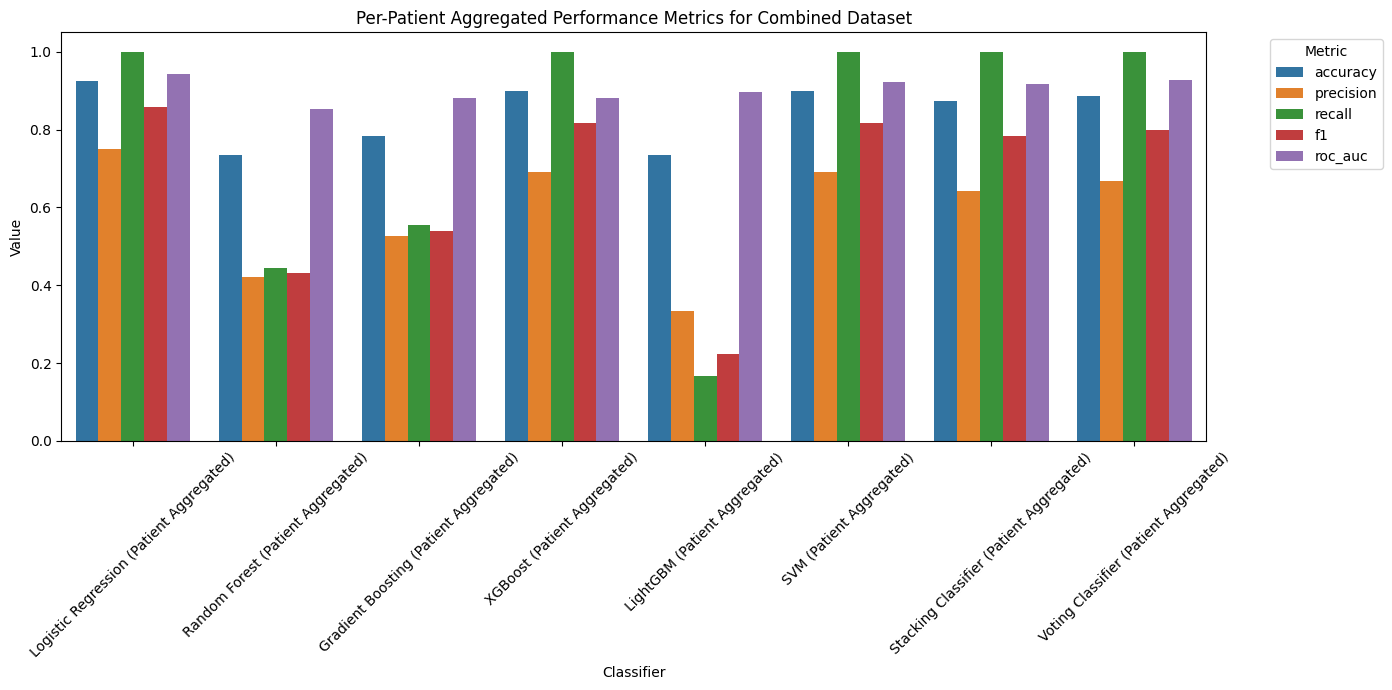

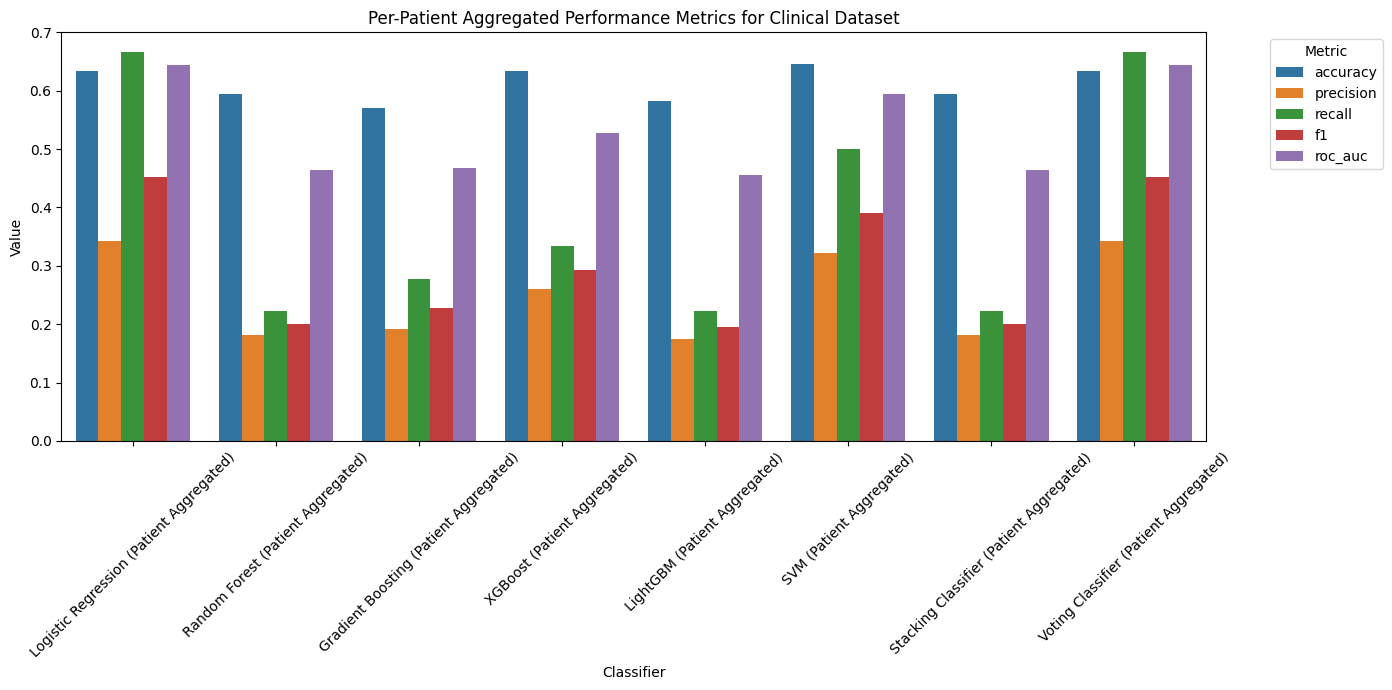

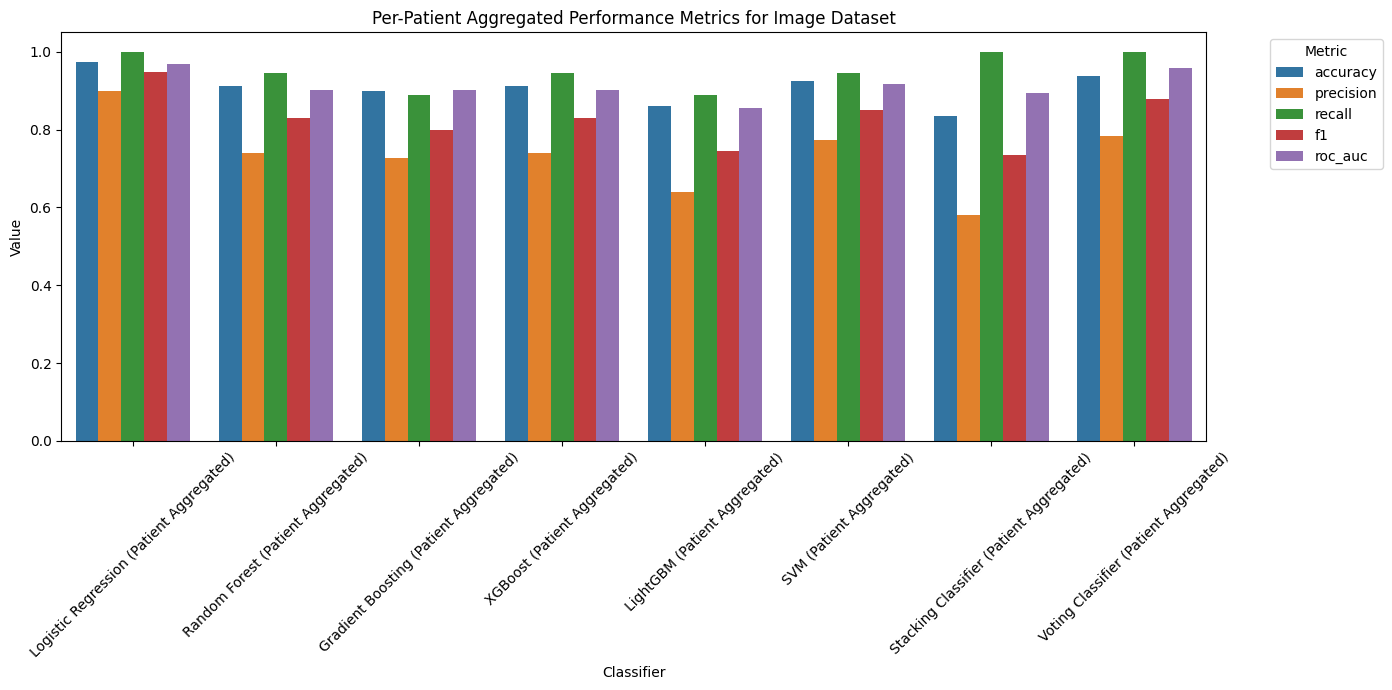

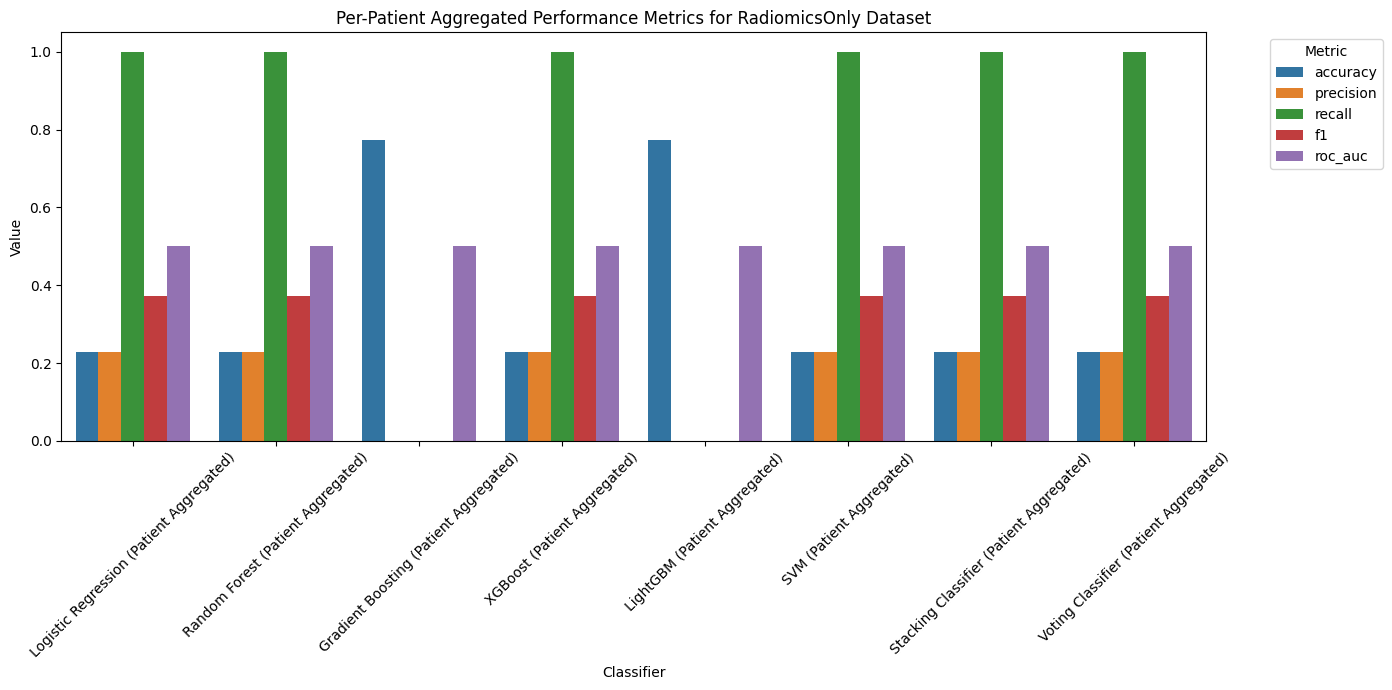

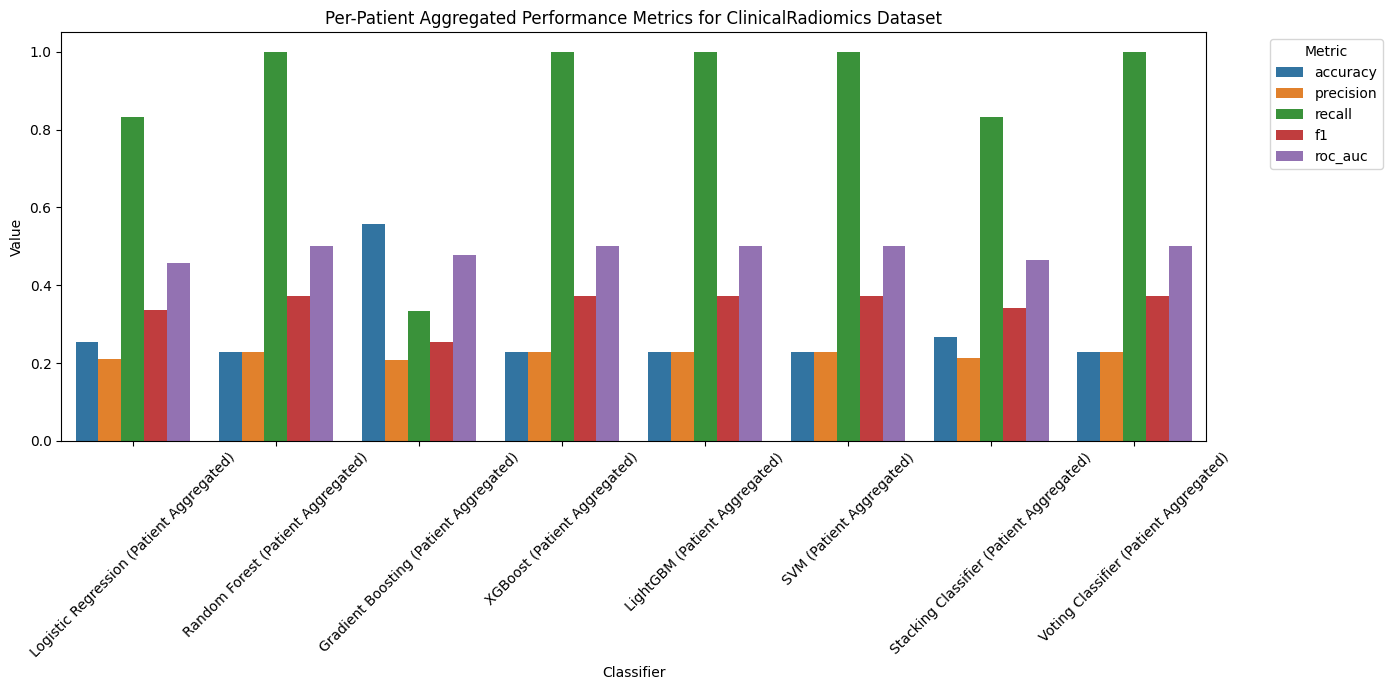

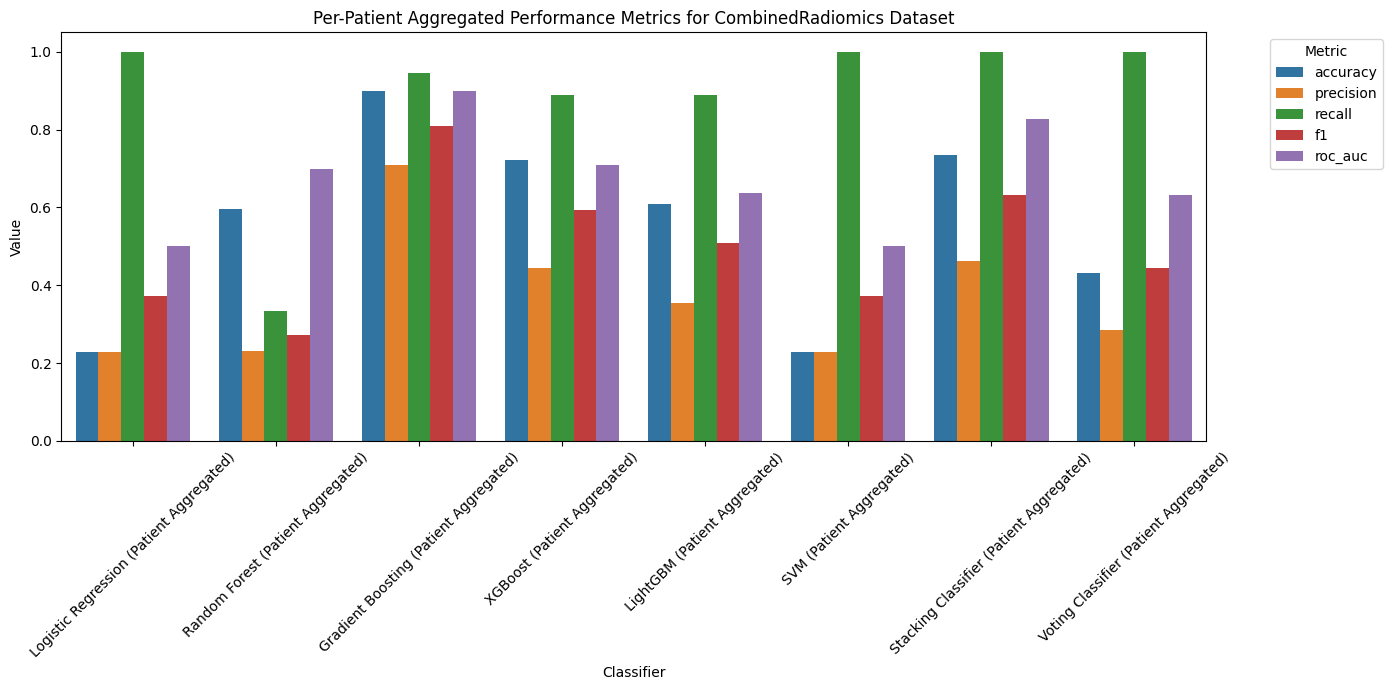

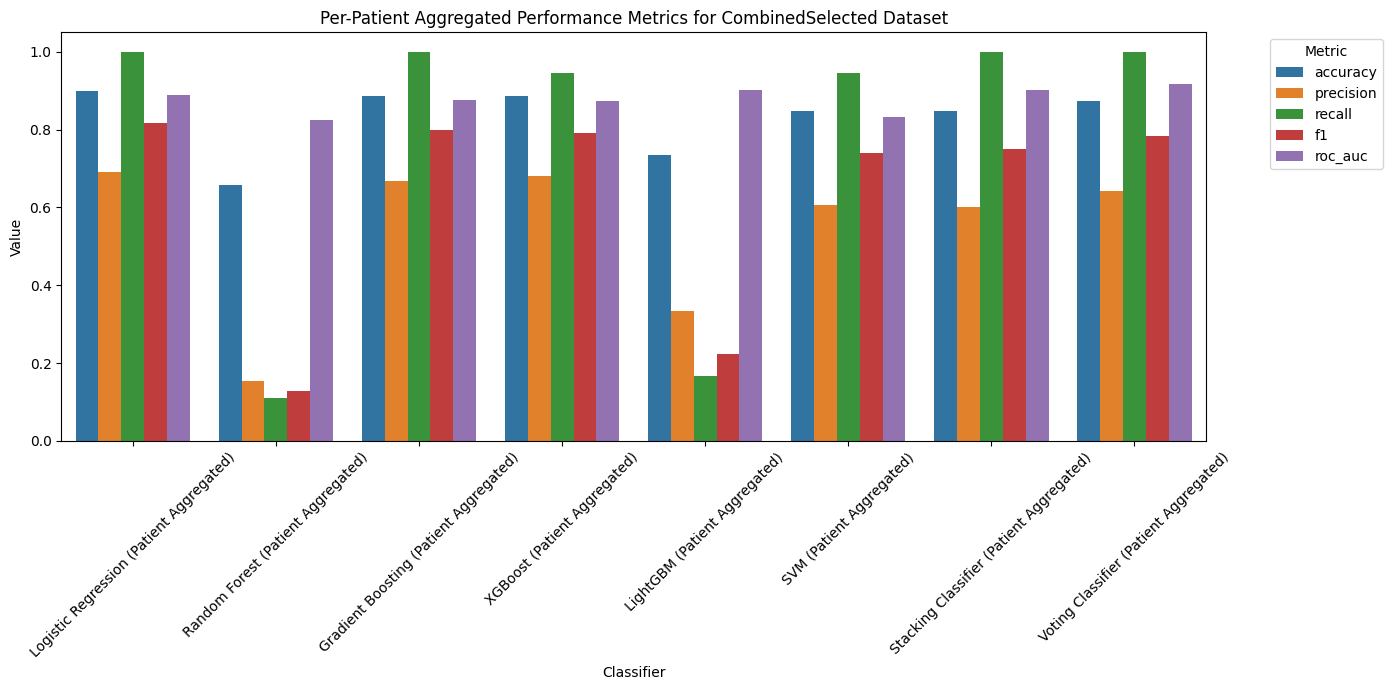

In [27]:
# Visualize Ensemble Classifier Performance

import matplotlib.pyplot as plt
import seaborn as sns

# Update your plotting function to include ensemble classifiers
def plot_metrics_with_ensembles(dataset_name, classifiers_results, ensemble_results):
    metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    classifier_names = list(classifiers_results.keys()) + list(ensemble_results.keys())
    metric_values = {metric: [] for metric in metrics}
    
    for clf_name in classifier_names:
        if clf_name in classifiers_results:
            results = classifiers_results[clf_name]
        else:
            results = ensemble_results[clf_name]
        for metric in metrics:
            metric_values[metric].append(results[metric])
    
    df_metrics = pd.DataFrame(metric_values, index=classifier_names)
    df_metrics = df_metrics.reset_index().rename(columns={'index': 'Classifier'})
    
    df_melted = df_metrics.melt(id_vars='Classifier', var_name='Metric', value_name='Value')
    
    plt.figure(figsize=(14, 7))
    sns.barplot(x='Classifier', y='Value', hue='Metric', data=df_melted)
    plt.title(f'Per-Patient Aggregated Performance Metrics for {dataset_name} Dataset')
    plt.xticks(rotation=45)
    plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Plot metrics for each dataset
for dataset_name in data_splits.keys():
    classifiers_results = test_results_per_patient[dataset_name]
    ensemble_results = test_results_ensemble.get(dataset_name, {})
    plot_metrics_with_ensembles(dataset_name, classifiers_results, ensemble_results)


In [28]:
# SHAP Analysis

#import shap
#import matplotlib.pyplot as plt
#
## For computational efficiency, we can sample a subset of data
## Number of samples to use for SHAP analysis
#n_samples = 100
#
#for dataset_name in data_splits.keys():
#    print(f"\nPerforming SHAP Analysis for '{dataset_name}' Dataset")
#    
#    # Retrieve data splits for the current dataset
#    data = data_splits[dataset_name]
#    X_train_full = data['X_train_full']
#    y_train_full = data['y_train_full']
#    X_test_full = data['X_test_full']
#    y_test = data['y_test']
#    
#    # For SHAP analysis, we'll use a small sample of the test data
#    if len(X_test_full) > n_samples:
#        X_test_sample = X_test_full.sample(n=n_samples, random_state=42)
#    else:
#        X_test_sample = X_test_full.copy()
#    
#    for classifier_name in classifiers.keys():
#        print(f"\nClassifier: {classifier_name}")
#        
#        # Retrieve the best hyperparameters from nested_cv_results
#        nested_results = nested_cv_results[dataset_name]
#        cv_results_all = nested_results['cv_results_all']
#        cv_results = cv_results_all[classifier_name]
#        
#        # Find the hyperparameters with the best mean_test_score
#        max_mean_test_score = cv_results['mean_test_score'].max()
#        best_rows = cv_results[cv_results['mean_test_score'] == max_mean_test_score]
#        
#        # If multiple rows have the same max score, pick the first one
#        best_row = best_rows.iloc[0]
#        
#        # Extract the best hyperparameters from the pipeline parameters
#        best_params = best_row['params']
#        
#        # The params are for the entire pipeline; extract classifier's hyperparameters
#        classifier_params = {}
#        for param_name, param_value in best_params.items():
#            if param_name.startswith('classifier__'):
#                # Remove 'classifier__' prefix to get the parameter name
#                param_short = param_name.replace('classifier__', '')
#                classifier_params[param_short] = param_value
#        
#        # Get the default classifier with default parameters
#        default_classifier = classifiers[classifier_name]
#        
#        # Clone the default classifier to avoid modifying the original
#        classifier = clone(default_classifier)
#        
#        # Update the classifier's parameters with the best hyperparameters
#        classifier.set_params(**classifier_params)
#        
#        # Handle compatibility between solver and penalty for Logistic Regression
#        if classifier_name == 'Logistic Regression':
#            penalty = classifier.get_params().get('penalty', 'l2')
#            solver = classifier.get_params().get('solver', 'lbfgs')
#            if penalty == 'l1' and solver not in ['liblinear', 'saga']:
#                # Change solver to 'liblinear' if penalty is 'l1'
#                classifier.set_params(solver='liblinear')
#                print(f"Adjusted solver to 'liblinear' for 'l1' penalty.")
#            elif penalty == 'elasticnet' and solver != 'saga':
#                # 'elasticnet' penalty requires 'saga' solver
#                classifier.set_params(solver='saga')
#                print(f"Adjusted solver to 'saga' for 'elasticnet' penalty.")
#            elif penalty == 'l2' and solver == 'liblinear' and classifier.get_params().get('dual', False):
#                # Dual formulation is only implemented for l2 penalty with liblinear solver
#                classifier.set_params(dual=True)
#            else:
#                # Ensure dual is False for other solvers
#                classifier.set_params(dual=False)
#        
#        # Apply SMOTE to training data only
#        print("\nApplying SMOTE to balance the classes in the training data...")
#        smote = SMOTE(random_state=42)
#        X_train_resampled, y_train_resampled = smote.fit_resample(X_train_full, y_train_full)
#        
#        # Define the pipeline without SMOTE
#        pipeline = Pipeline(steps=[
#            ('scaler', MinMaxScaler()),
#            ('classifier', classifier)
#        ])
#        
#        # Fit the pipeline on the entire training set
#        pipeline.fit(X_train_resampled, y_train_resampled)
#        
#        # Extract the classifier from the pipeline
#        trained_classifier = pipeline.named_steps['classifier']
#        
#        # Prepare the data (after scaling)
#        X_train_scaled = pipeline.named_steps['scaler'].transform(X_train_resampled)
#        X_test_scaled = pipeline.named_steps['scaler'].transform(X_test_sample)
#        
#        # For SHAP, we need to use the model and data
#        # Use appropriate SHAP explainer based on the model
#        if classifier_name in ['Random Forest', 'XGBoost', 'LightGBM']:
#            # Use TreeExplainer
#            explainer = shap.TreeExplainer(trained_classifier)
#        elif classifier_name == 'Logistic Regression':
#            explainer = shap.LinearExplainer(trained_classifier, X_train_scaled)
#        elif classifier_name == 'SVM':
#            # For SVM, use KernelExplainer (may be slow)
#            print("KernelExplainer may be slow for SVM. Using a small sample of background data.")
#            X_train_small = X_train_scaled[:100]  # Use a small subset as background
#            def model_predict(data):
#                return trained_classifier.decision_function(data)
#            explainer = shap.KernelExplainer(model_predict, X_train_small)
#        else:
#            print(f"SHAP analysis not implemented for classifier '{classifier_name}'.")
#            continue
#        
#        # Compute SHAP values
#        print("Computing SHAP values...")
#        shap_values = explainer.shap_values(X_test_scaled)
#        
#        # For multi-class classifiers, shap_values is a list
#        if isinstance(shap_values, list):
#            # For binary classification, take the SHAP values for the positive class
#            shap_values = shap_values[1]
#        
#        # Get feature names
#        feature_names = X_test_full.columns
#        
#        # Create a summary plot
#        shap.summary_plot(shap_values, X_test_scaled, feature_names=feature_names)
